# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
import os
import xai
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import log_loss


mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FactorAnalysis, PCA

# Analysis/Modeling
Do work here

In [2]:
starbucks_df = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/total/20200724_starbucksDT_beformNorm.xlsx')

In [366]:
starbucks_df.columns

Index(['지점명', '분류', '위도', '경도', '관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침',
       '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리', '아파트_거리',
       '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월', '인근_스타벅스_거리', '주유소_거리',
       '1년_영수증_개수', '6개월_영수증_개수', '3개월_영수증_개수', '2개월_영수증_개수', '1개월_영수증_개수',
       '1년_점수', '6개월_점수', '3개월_점수', '2개월_점수', '1개월_점수', '최근접_대기업_거리',
       '최근접_대기업_자본금', '1km내_대기업_개수', '2km내_대기업_개수', '3km내_대기업_개수',
       '5km내_대기업_개수', '인근_교차로_거리', '오픈일', '리뷰점수', 'DT지수', 'score_A1',
       'score_A2', 'score_A3', 'score_B1', 'score_B2', 'score_B3', '관광지명',
       '동_아파트_세대수', '위도_log', '경도_log', '관광지_거리_log', '관광지_리뷰수_log',
       '교통량_점수_log', '교통량_점수_아침_log', '교통량_점수_저녁_log', '교통량_점수_점심_log',
       '교통량_점수_주말_log', '교통량_점수_평일_log', '맥도날드_거리_log', '아파트_거리_log',
       '아파트_매매가_상한_log', '아파트_세대수_log', '아파트_준공년월_log', '인근_스타벅스_거리_log',
       '주유소_거리_log', '1년_영수증_개수_log', '6개월_영수증_개수_log', '3개월_영수증_개수_log',
       '2개월_영수증_개수_log', '1개월_영수증_개수_log', '1년_점수_log', '6개

In [209]:
def draw_all_features(feature_nums, num_cols, feature_df):
    num_rows = int(np.ceil(feature_nums / num_cols))
    print(f'num_rows, num_cols : {num_rows}, {num_cols}')
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
    for idx, col in enumerate(feature_df.columns[1:]):
        r, c = divmod(idx, num_cols)
        try:
            sns.boxplot(feature_df[col], ax=axs[r,c])
            axs[r,c].set_title(col)
        except:
            axs[r,c].set_title(col)
            continue
    fig.tight_layout()

def minmax_norm(df, row, col_name):
    return (row[col_name] - df[col_name].min())/(df[col_name].max() - df[col_name].min())

def upper_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    max_value = df.reset_index(drop=True).loc[np.where((df[col_name] <= upper_bound))][col_name].values.max()
    return np.concatenate(np.where((df[col_name] > upper_bound))), max_value

def get_bound_wrt_iqr(data, min_per, max_per):
    quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

def down_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    min_value = df.reset_index(drop=True).loc[np.where((df[col_name] >= lower_bound))][col_name].values.min()
    return np.concatenate(np.where((df[col_name] < lower_bound))), min_value

def outlier_make_one_value(df, col_name, min_per=25, max_per=75):
    temp_df = df.copy()
    outlier_up_idx, one_max = upper_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df = temp_df.reset_index(drop=True)
    temp_df.loc[outlier_up_idx, col_name] = one_max
    outlier_dw_idx, one_min = down_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df.loc[outlier_dw_idx, col_name] = one_min
    sns.boxplot(temp_df[col_name])
    return temp_df

def check_box_plot(src_df, target_df, col_name):
    plt.figure(figsize=(14,4))
    sns.boxplot(src_df[col_name])
    plt.figure(figsize=(14,4))
    target_df = outlier_make_one_value(target_df, col_name)
    return target_df

In [361]:
class OutlierHandler(object):
    def __init__(self):
        self.outliers_map = {}
        
    def percentile_based_outlier(self, data, threshold=95):
        diff = (100 - threshold) / 2.0
        (minval, maxval) = np.percentile(data, [diff, 100 - diff])
        return ((data < minval) | (data > maxval))
    
    def iqr_based_outlier(self, data, min_per=25, max_per=75):
        quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return ((data < lower_bound) | (data > upper_bound))
    
    def mad_based_outlier(self, points, threshold=3.5):
        if len(points.shape) == 1:
            points = points[:, np.newaxis]
        median_y = np.median(points)
        median_absolute_deviation_y = np.median([np.abs(y-median_y) for y in points])
        modified_z_scores = [0.6745 * (y-median_y) / median_absolute_deviation_y for y in points]

        return np.reshape(np.abs(modified_z_scores) >= threshold, (-1))

    def std_based_outlier(self, data, threshold=3):
        std = data.std()
        mean = data.mean()
        isOutlier = []
        for val in data:
            if np.abs(val-mean)/std >= threshold:
                isOutlier.append(True)
            else:
                isOutlier.append(False)
        return np.asanyarray(isOutlier)

    def voting_based_outlier(self, data, agree=2):
        x = self.percentile_based_outlier(data)[:,np.newaxis]
        y = self.mad_based_outlier(data)[:,np.newaxis]
        z = self.std_based_outlier(data)[:,np.newaxis]
        w = self.iqr_based_outlier(data)[:,np.newaxis]
        temp = np.concatenate([data.index[:,np.newaxis], x, y, z, w], axis=-1)
        final = []
        for i in range(temp.shape[0]):
            if list(temp[i, :]).count(True) >= agree:
                printing =  f' outlier voting...'
                for idx in range(temp.shape[-1]-1):
                    if (idx==0) and (temp[i, idx+1] == True):
                        printing += 'percentile, '
                    if (idx==1) and (temp[i, idx+1] == True):
                        printing += 'mad, '
                    if (idx==2) and (temp[i, idx+1] == True):
                        printing += 'std_div, '
                    if (idx==3) and (temp[i, idx+1] == True):
                        printing += 'iqr, , '
                print(f'{temp[i, 0]}th idx data, {printing}')
                final.append(True)
            else:
                final.append(False)
        return final
    
    def voting1half_based_outlier(self, data):
        print(f'voting1half_based_outlier...')
        return self.voting_based_outlier(data, 2)
        
    def voting3quarter_based_outlier(self, data):
        print(f'voting3quarter_based_outlier...')
        return self.voting_based_outlier(data, 3)

    def plotOutlier(self, x):
        functions = [self.iqr_based_outlier,
                     self.percentile_based_outlier,
                     self.mad_based_outlier,
                     self.std_based_outlier,
                     self.voting1half_based_outlier,
                     self.voting3quarter_based_outlier]
        
        fig, axes = plt.subplots(nrows=len(functions), ncols=2)
        kwargs = dict(y=1.05, x=0.01, ha='left', va='center', size=20, color='blue')
        self.outliers_map[x.name] = {}
        median = x.median()
        
        for ax, func in zip(axes[:, 0], functions):
            sns.distplot(x.values, ax=ax, rug=True, hist=False)
            outliers = x[func(x)]
            ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
            func_name = f"{str(func).split(' ')[2].split('.')[1]}"
            ax.set_title(func_name, **kwargs)
            self.outliers_map[x.name][func_name] = outliers.values
            top_outlier = list(outliers.values > median).count(True)
            bot_outlier = len(outliers.values) - top_outlier
            bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
            ax.annotate(f'top out count : {top_outlier}\nbot out count : {bot_outlier}',
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props)

        for ax, outlier in zip(axes[:, 1], self.outliers_map[x.name].values()):
            sns.boxplot(x.values, ax=ax)
            ax.plot(outlier, np.zeros_like(outlier), 'ro', clip_on=False)

        self.outliers_map[x.name]['median'] = median           
        fig.suptitle('Comparing Ourlier Tests with {}, n={}'.format(x.name, len(x)), y=1.03, x=0.5, size=24, color='black')
        axes[-1, 0].set_xlabel(f'{x.name}', fontsize=12)
        axes[-1, 1].set_xlabel(f'{x.name}', fontsize=12)
        fig = plt.gcf()
        fig.set_size_inches(16, 13)
        fig.tight_layout()
        
#     def outlier_make_one_value(self, df, col_name, min_per=25, max_per=75):
#         temp_df = df.copy()
#         outlier_up_idx, one_max = upper_outliers_iqr(temp_df, col_name, min_per, max_per)
#         temp_df = temp_df.reset_index(drop=True)
#         temp_df.loc[outlier_up_idx, col_name] = one_max
#         outlier_dw_idx, one_min = down_outliers_iqr(temp_df, col_name, min_per, max_per)
#         temp_df.loc[outlier_dw_idx, col_name] = one_min
#         sns.boxplot(temp_df[col_name])
#         return temp_df

#     def check_box_plot(self, src_df, target_df, col_name):
#         plt.figure(figsize=(14,4))
#         sns.boxplot(src_df[col_name])
#         plt.figure(figsize=(14,4))
#         target_df = outlier_make_one_value(target_df, col_name)
#         return target_df

In [362]:
list(starbucks_df['관광지_거리'].values > starbucks_df['관광지_거리'].median()).count(True)

126

In [363]:
outlier_handler = OutlierHandler()

voting1half_based_outlier...
61th idx data,  outlier voting...percentile, std_div, iqr, , 
162th idx data,  outlier voting...percentile, std_div, iqr, , 
201th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
voting3quarter_based_outlier...
61th idx data,  outlier voting...percentile, std_div, iqr, , 
162th idx data,  outlier voting...percentile, std_div, iqr, , 
201th idx data,  outlier voting...percentile, mad, std_div, iqr, , 


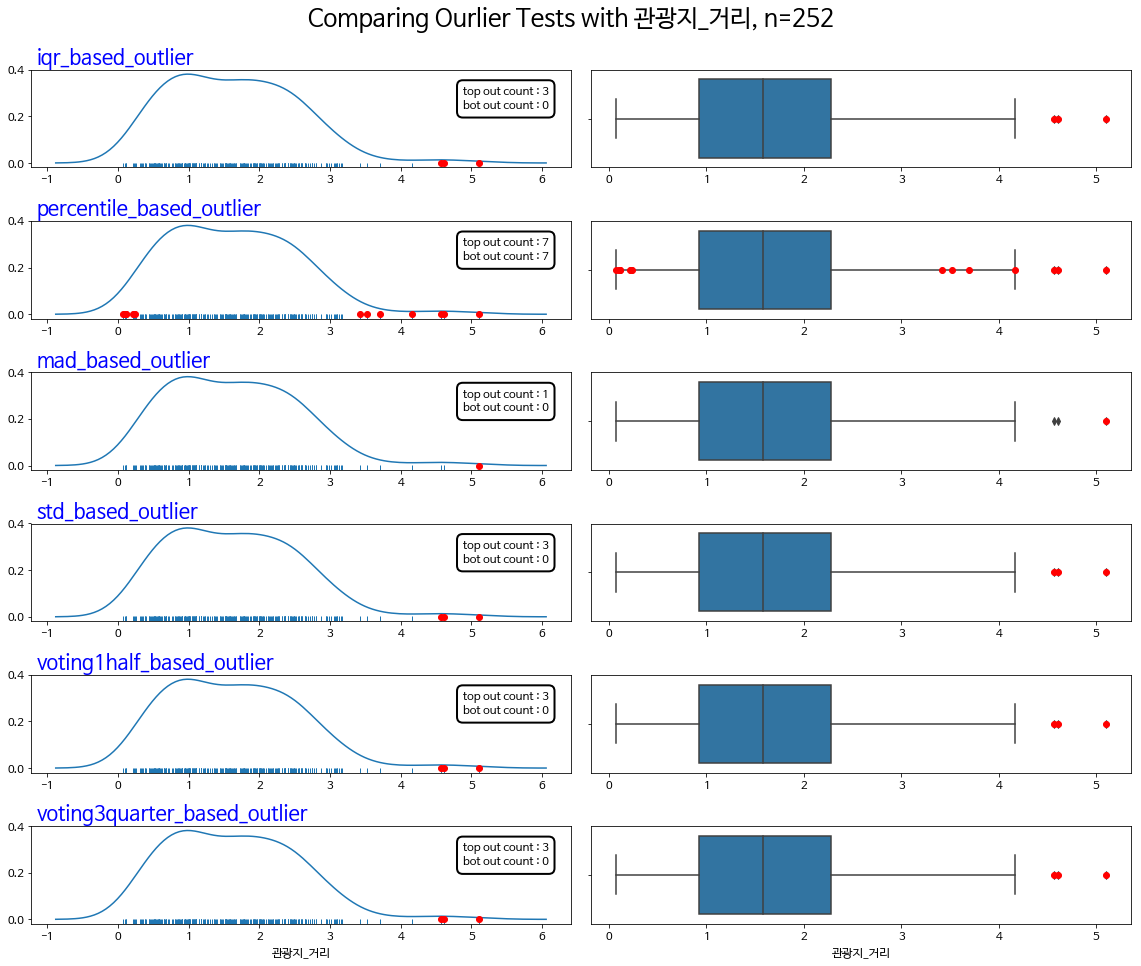

In [364]:
outlier_handler.plotOutlier(starbucks_df['관광지_거리'])

voting1half_based_outlier...
4th idx data,  outlier voting...mad, iqr, , 
9th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
46th idx data,  outlier voting...mad, iqr, , 
67th idx data,  outlier voting...mad, iqr, , 
85th idx data,  outlier voting...mad, iqr, , 
96th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
100th idx data,  outlier voting...mad, iqr, , 
110th idx data,  outlier voting...percentile, mad, iqr, , 
117th idx data,  outlier voting...mad, iqr, , 
118th idx data,  outlier voting...mad, iqr, , 
142th idx data,  outlier voting...percentile, mad, iqr, , 
161th idx data,  outlier voting...mad, iqr, , 
163th idx data,  outlier voting...mad, iqr, , 
165th idx data,  outlier voting...mad, iqr, , 
166th idx data,  outlier voting...mad, iqr, , 
191th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
214th idx data,  outlier voting...mad, iqr, , 
215th idx data,  outlier voting...mad, iqr, , 
217th idx data,  outlier voting...percentile, 

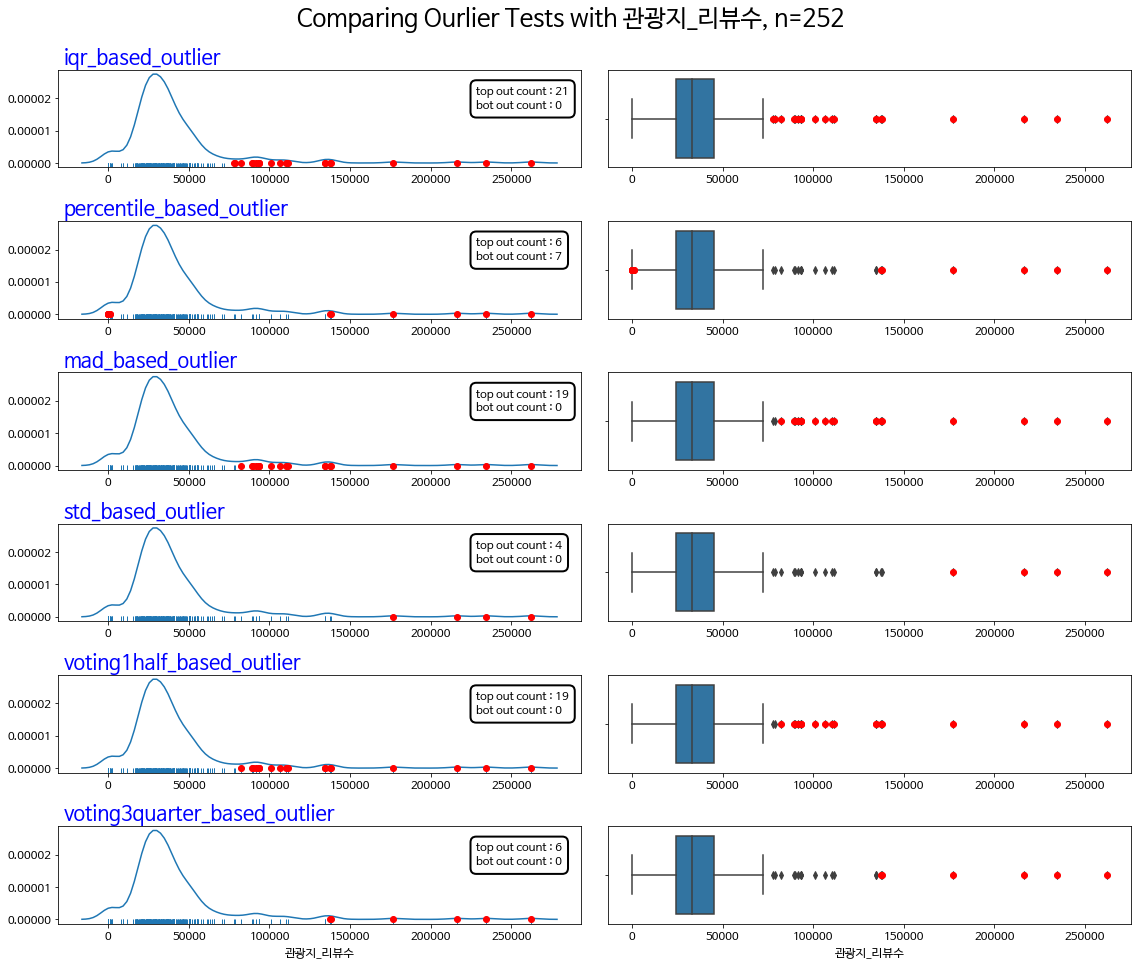

In [365]:
outlier_handler.plotOutlier(starbucks_df['관광지_리뷰수'])

voting1half_based_outlier...
55th idx data,  outlier voting...percentile, mad, iqr, , 
100th idx data,  outlier voting...percentile, mad, iqr, , 
144th idx data,  outlier voting...percentile, mad, iqr, , 
201th idx data,  outlier voting...percentile, mad, iqr, , 
218th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
220th idx data,  outlier voting...percentile, mad, iqr, , 
251th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
voting3quarter_based_outlier...
55th idx data,  outlier voting...percentile, mad, iqr, , 
100th idx data,  outlier voting...percentile, mad, iqr, , 
144th idx data,  outlier voting...percentile, mad, iqr, , 
201th idx data,  outlier voting...percentile, mad, iqr, , 
218th idx data,  outlier voting...percentile, mad, std_div, iqr, , 
220th idx data,  outlier voting...percentile, mad, iqr, , 
251th idx data,  outlier voting...percentile, mad, std_div, iqr, , 


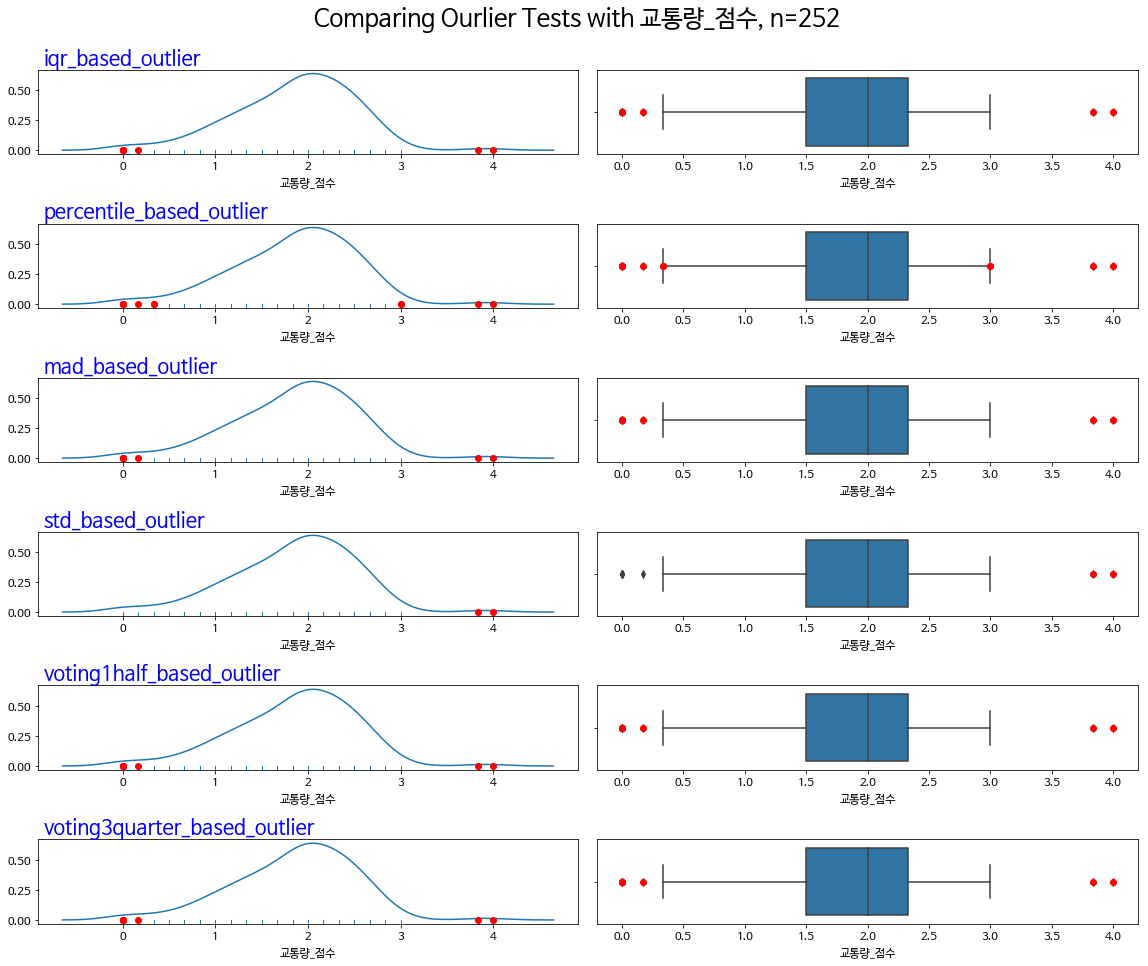

In [285]:
outlier_handler.plotOutlier(starbucks_df['교통량_점수'])

In [286]:
outlier_handler.outliers_map

{'관광지_거리': {'iqr_based_outlier': array([4.60914579, 4.57010477, 5.10562339]),
  'percentile_based_outlier': array([0.11707871, 0.07022532, 3.69961992, 4.60914579, 0.10673795,
         0.22501735, 0.20974512, 0.11634043, 3.522991  , 4.16395667,
         4.57010477, 0.23688635, 5.10562339, 3.42277747]),
  'mad_based_outlier': array([5.10562339]),
  'std_based_outlier': array([4.60914579, 4.57010477, 5.10562339]),
  'voting1half_based_outlier': array([4.60914579, 4.57010477, 5.10562339]),
  'voting3quarter_based_outlier': array([4.60914579, 4.57010477, 5.10562339])},
 '관광지_리뷰수': {'iqr_based_outlier': array([101122, 216315, 134579,  89180,  82328, 176960, 106386, 137932,
         111623,  91382,  77967, 137492, 134579,  93313,  93313,  93313,
         262135,  90099, 110149, 234633,  78917]),
  'percentile_based_outlier': array([216315,      0,      0,    886, 176960,      0, 137932,   1329,
         137492, 262135,      0, 234633,      0]),
  'mad_based_outlier': array([101122, 216315, 13

In [ ]:
starbucks_df.info()

cannot perform reduce with flexible type
ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')
cannot perform reduce with flexible type


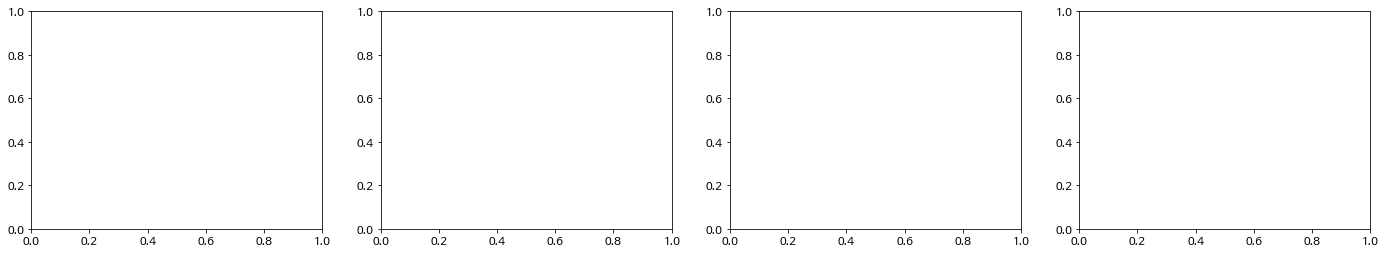

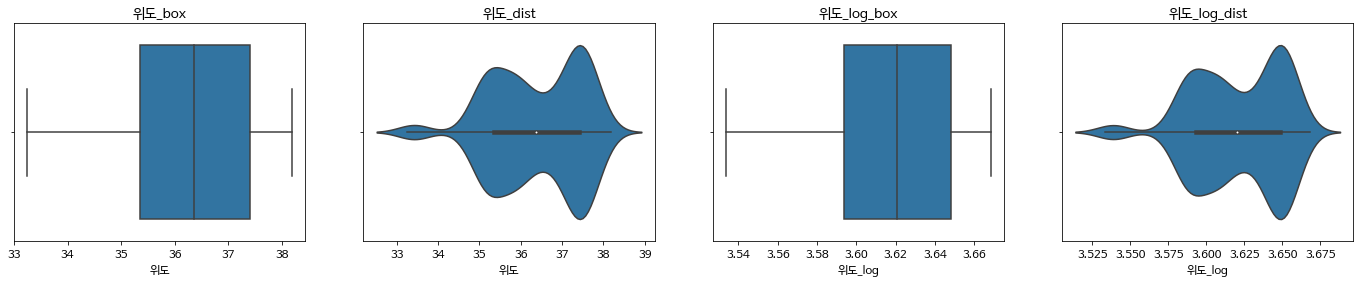

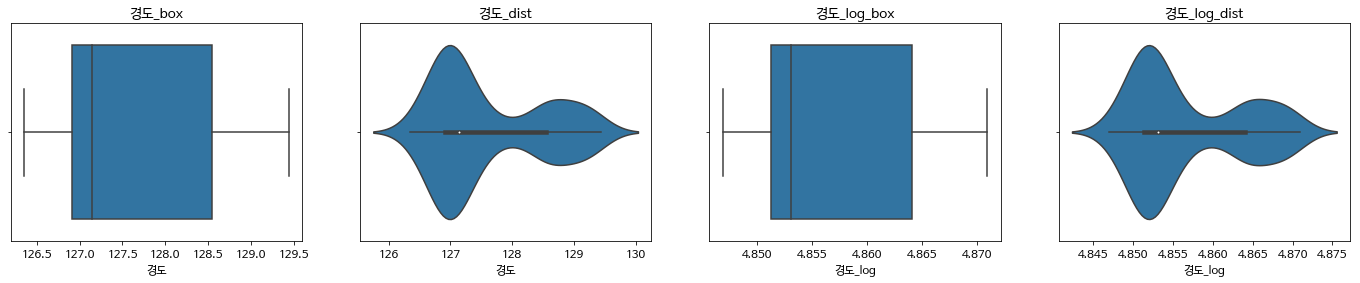

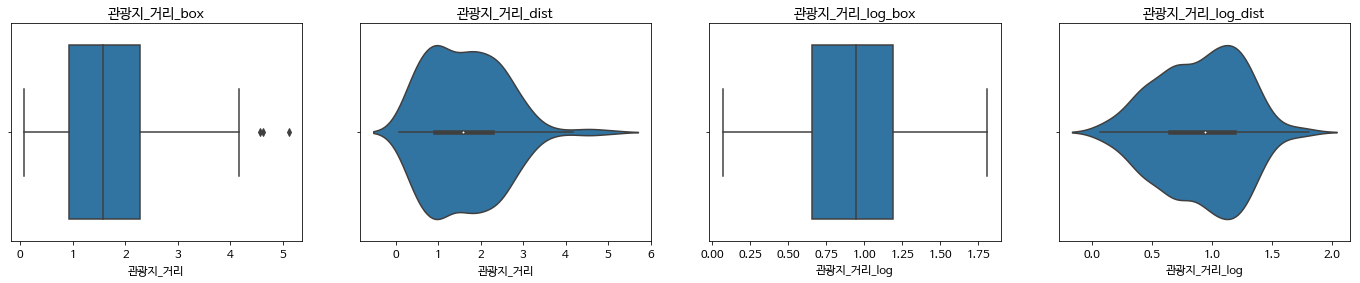

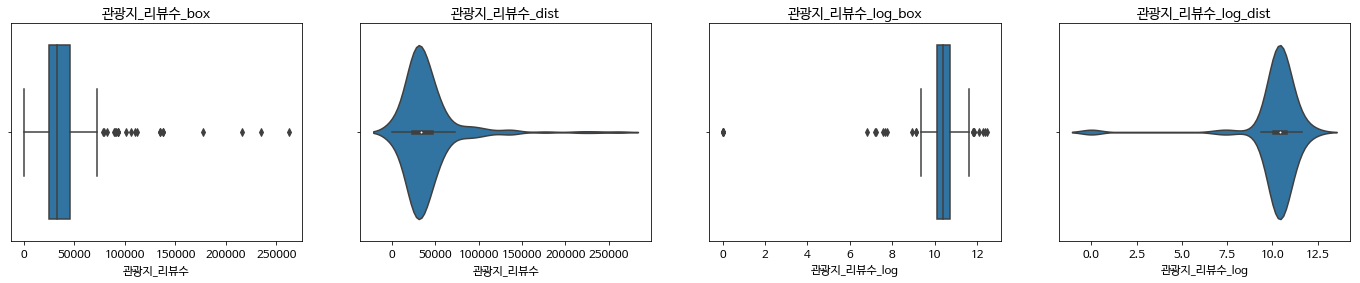

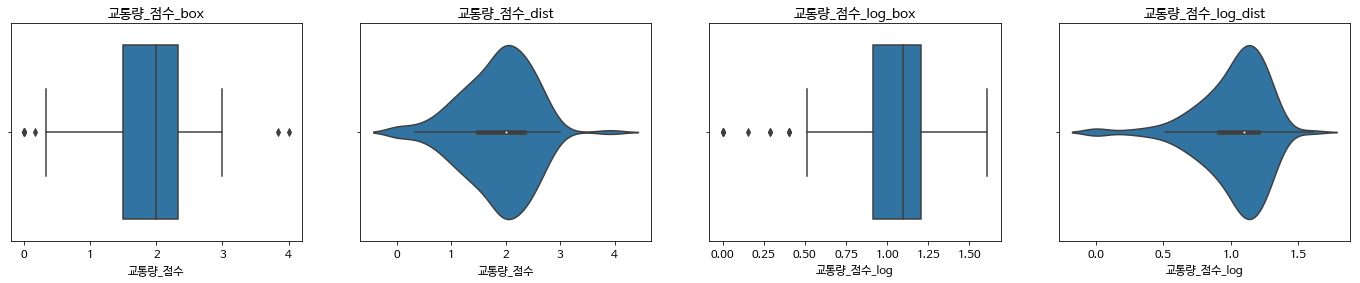

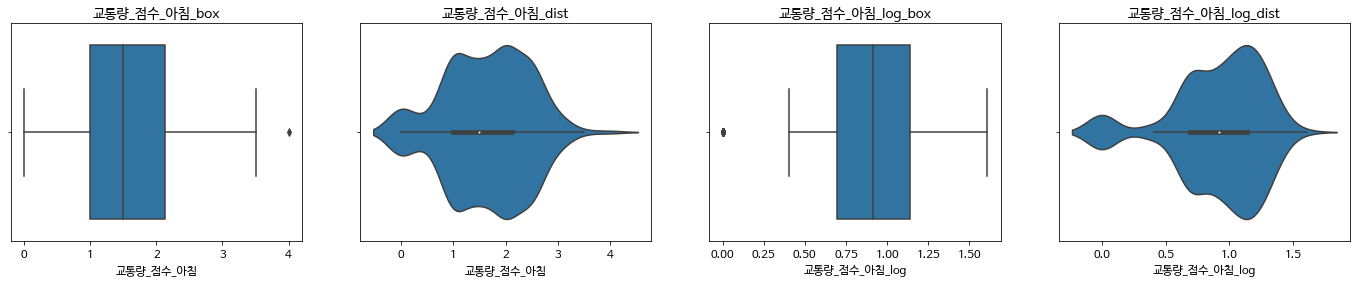

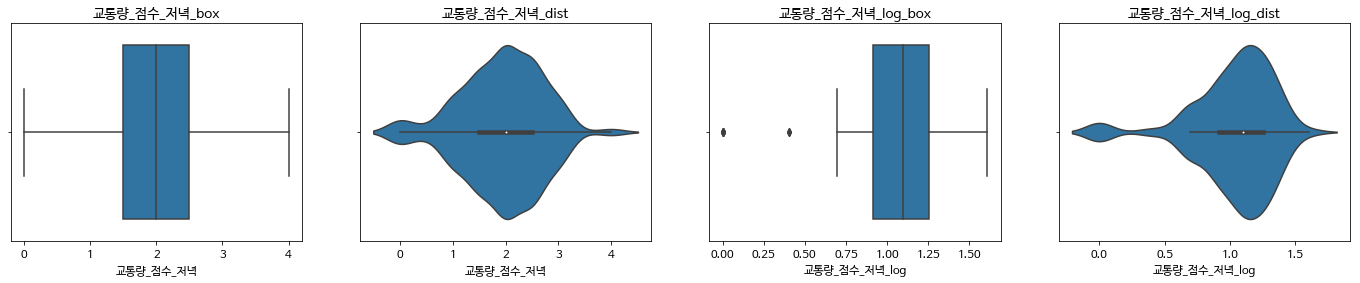

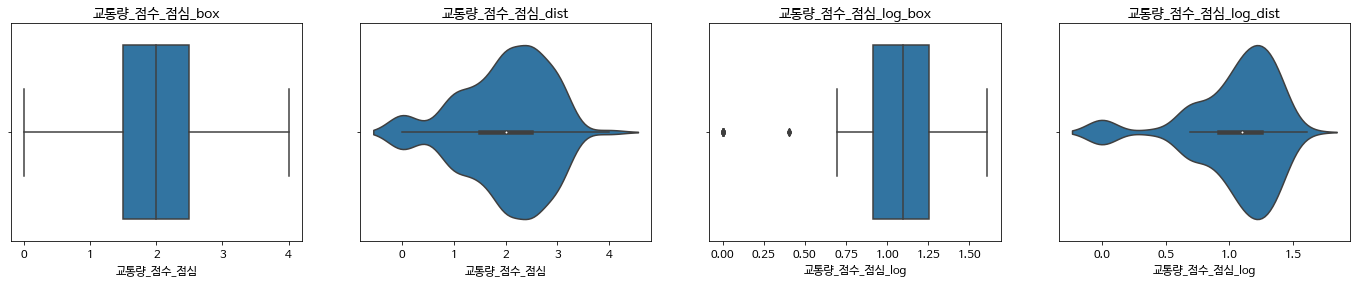

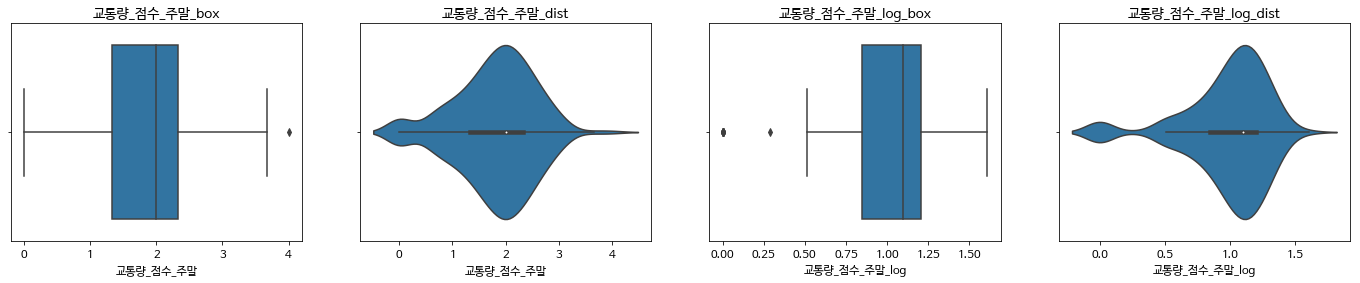

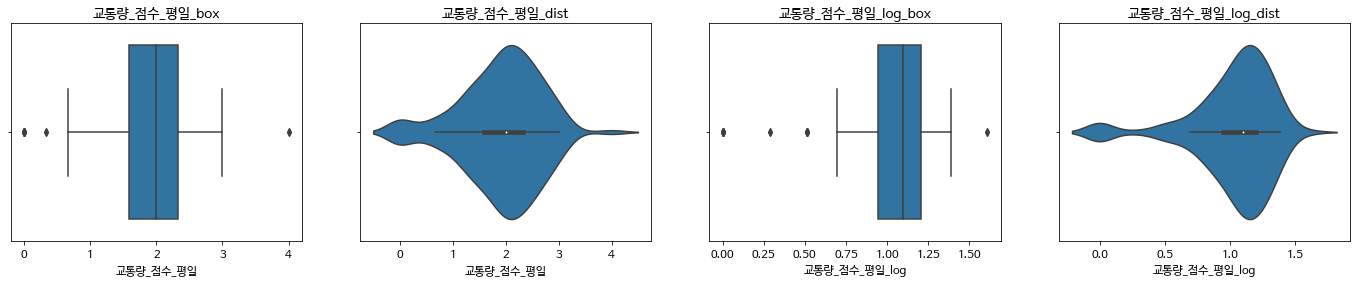

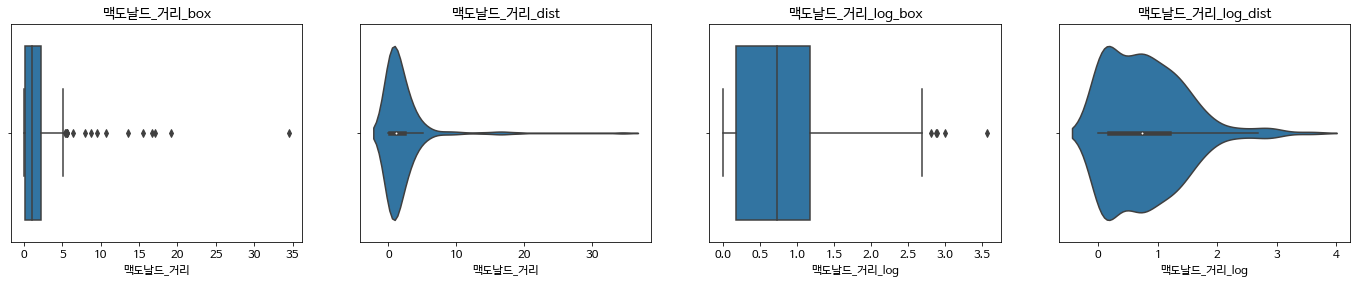

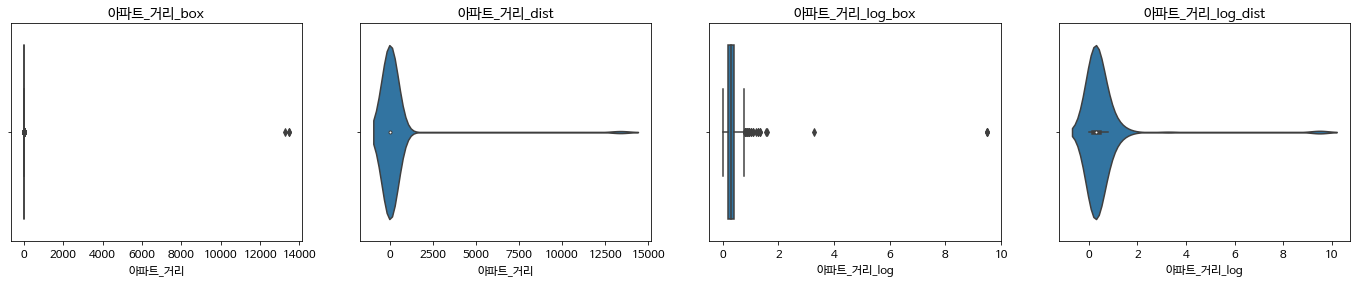

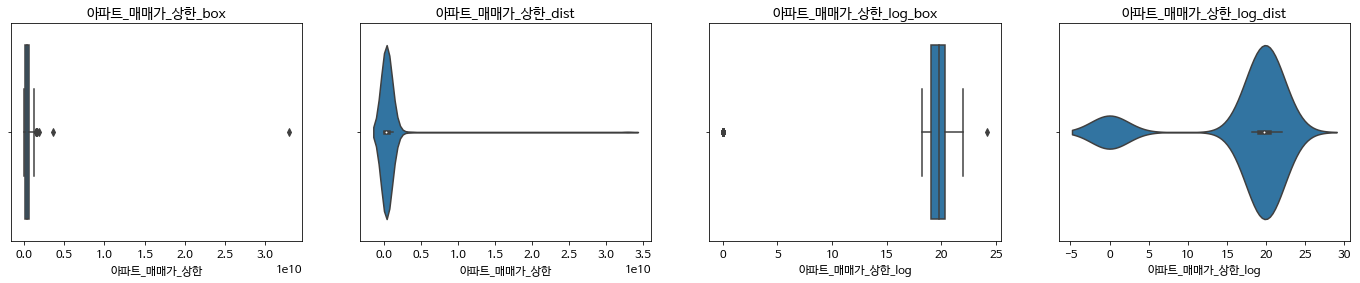

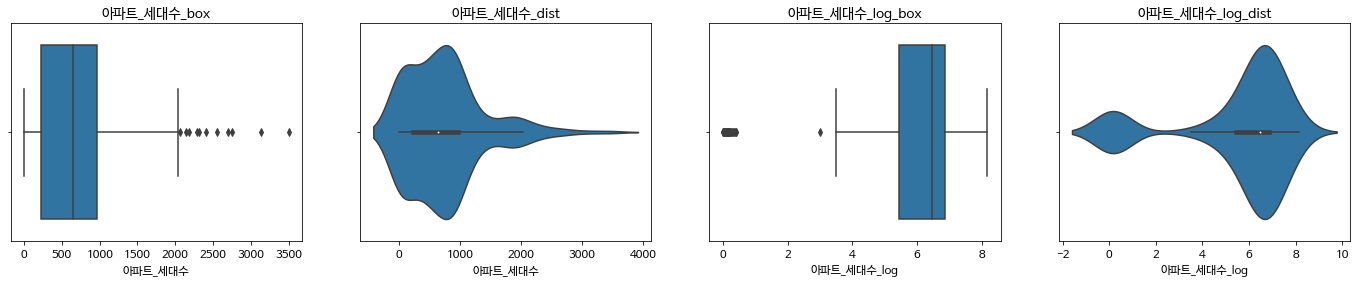

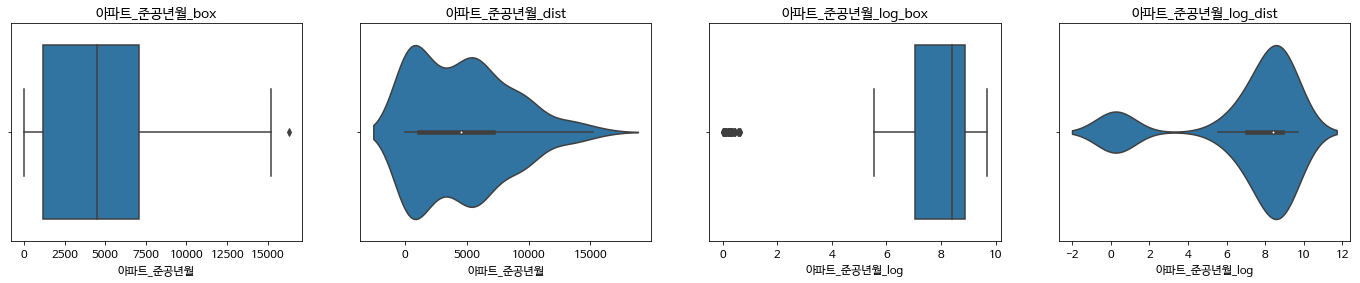

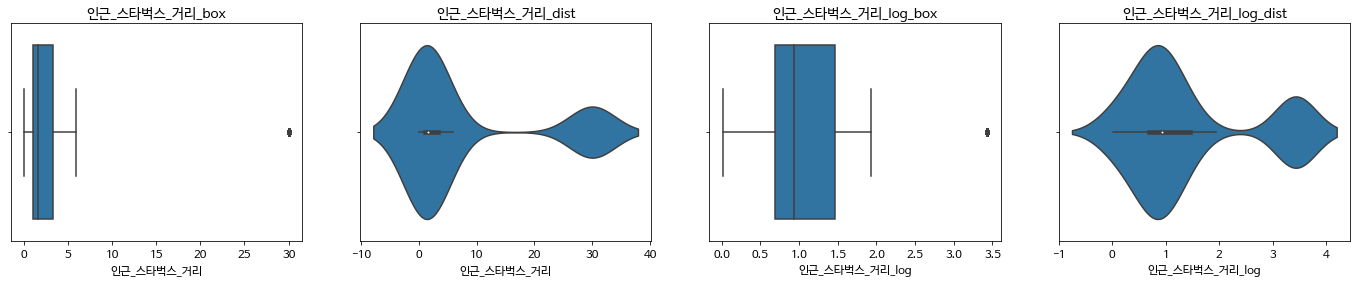

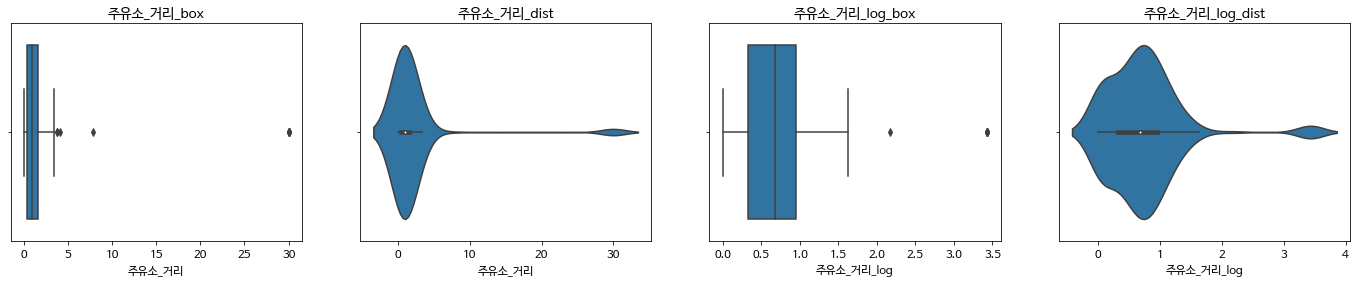

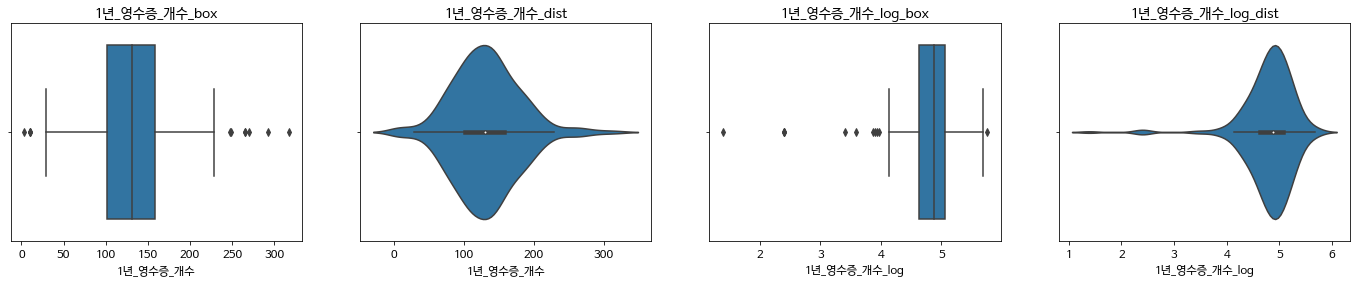

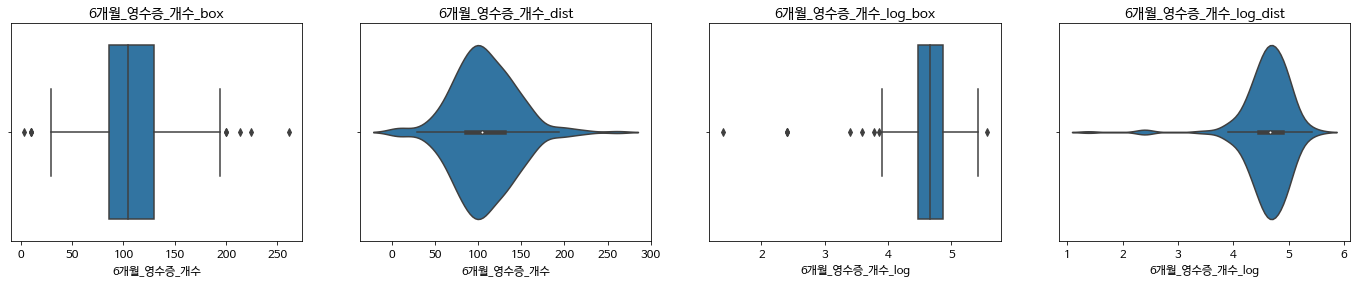

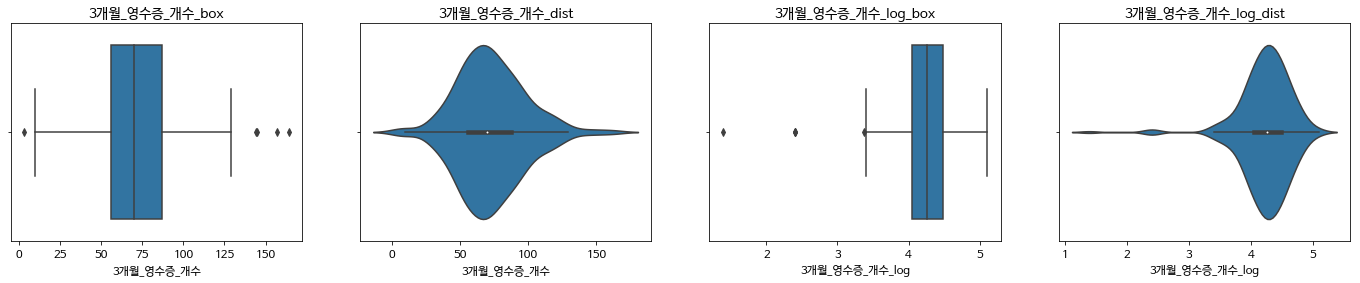

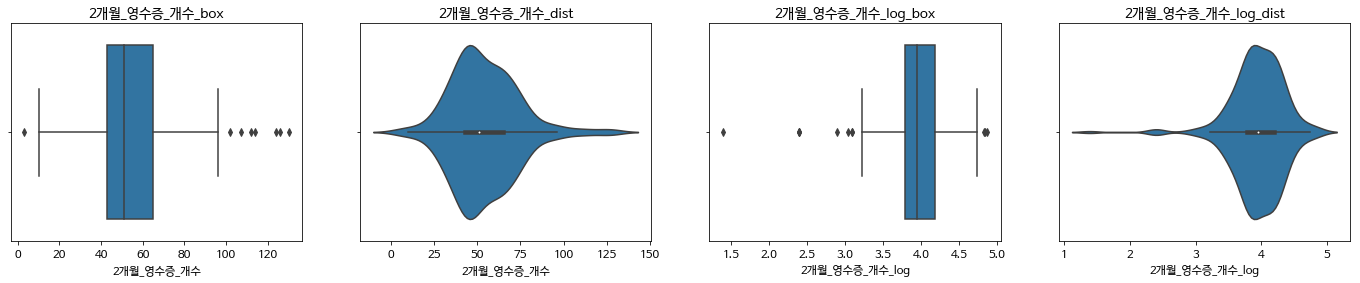

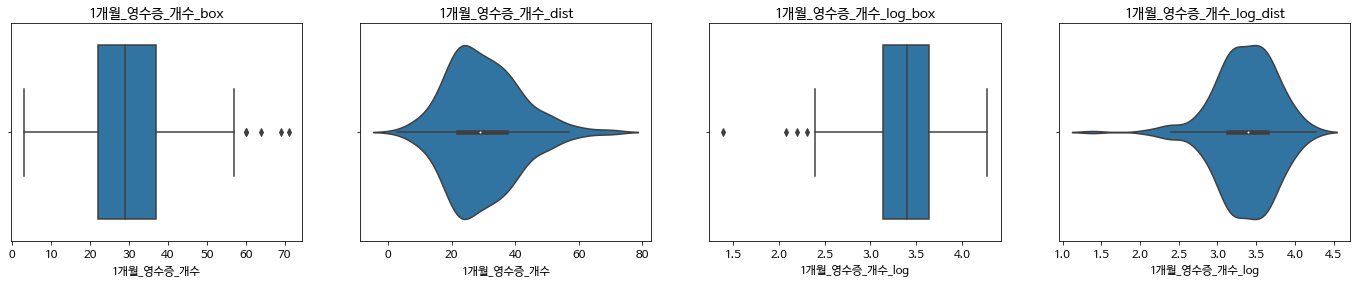

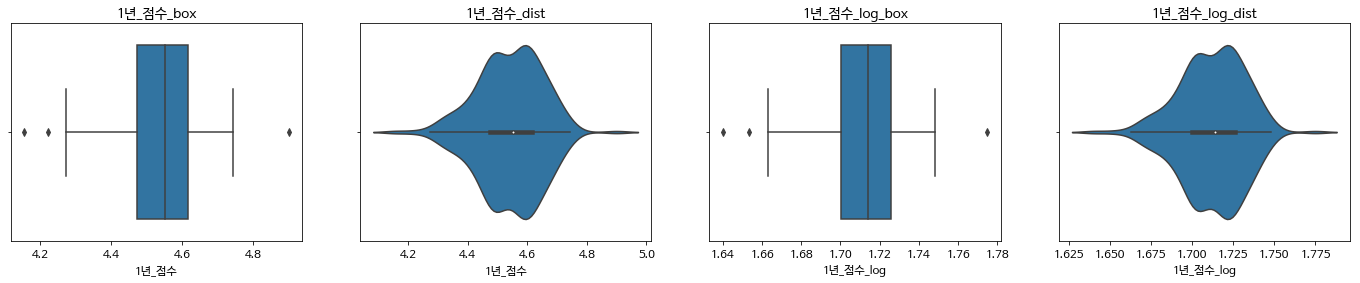

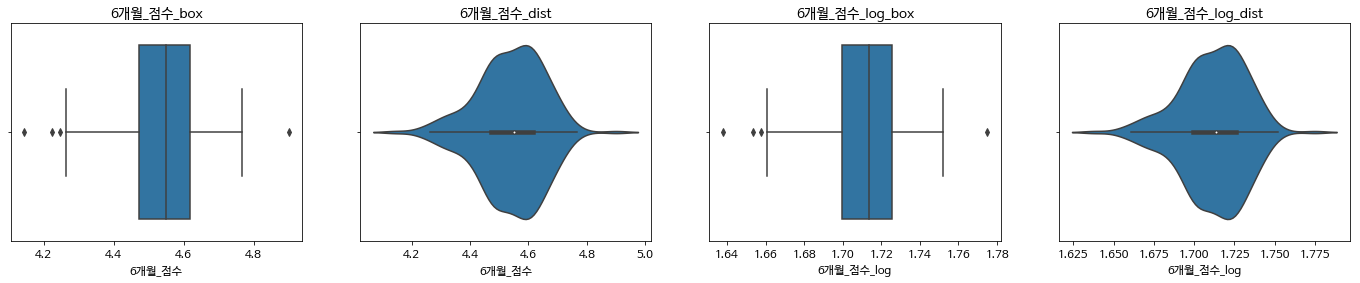

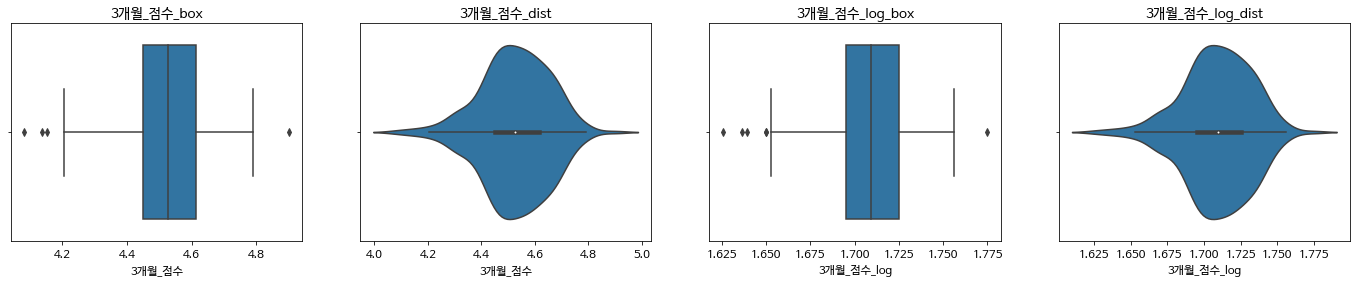

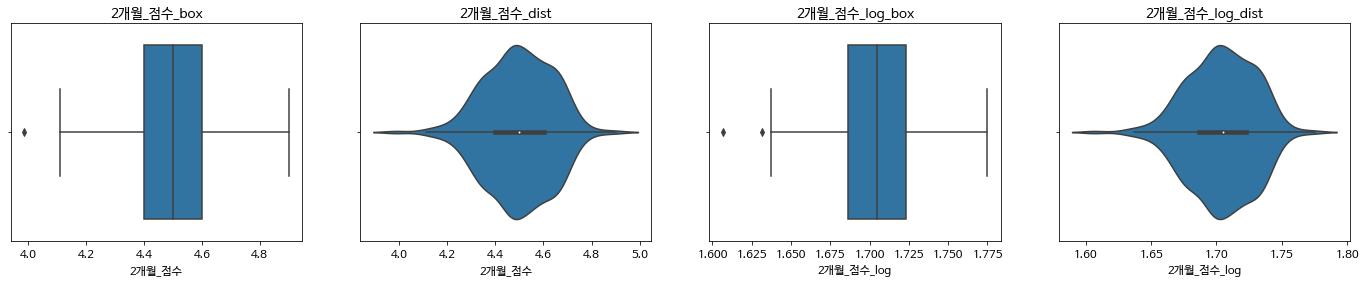

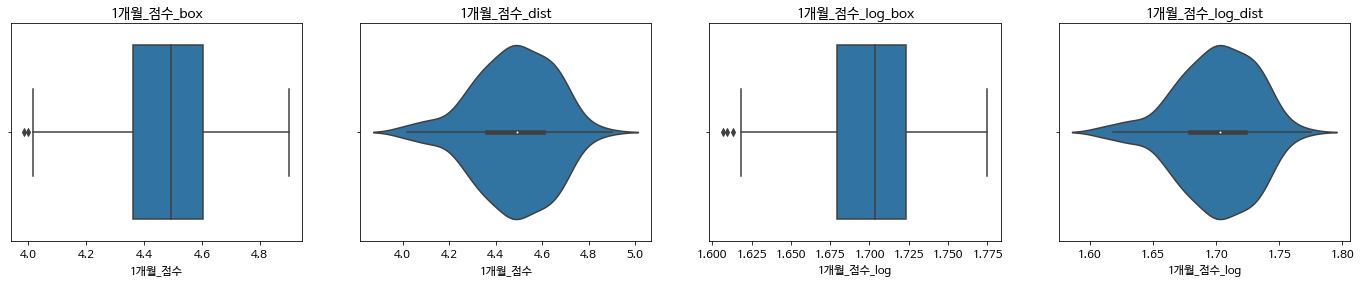

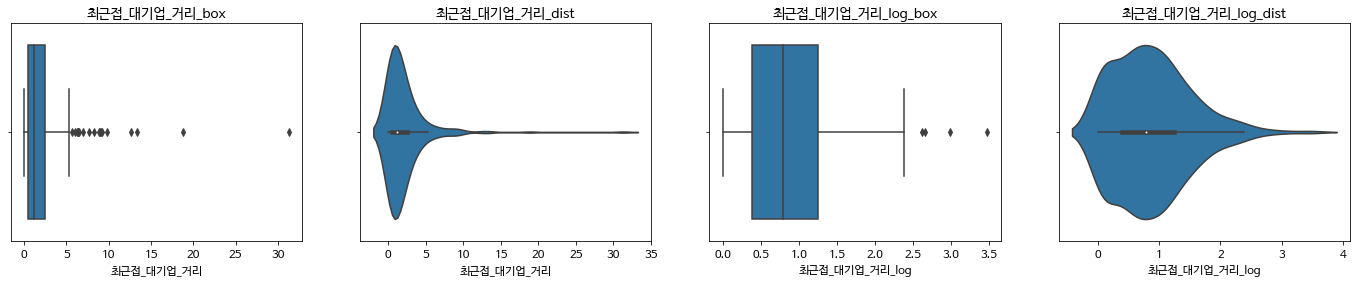

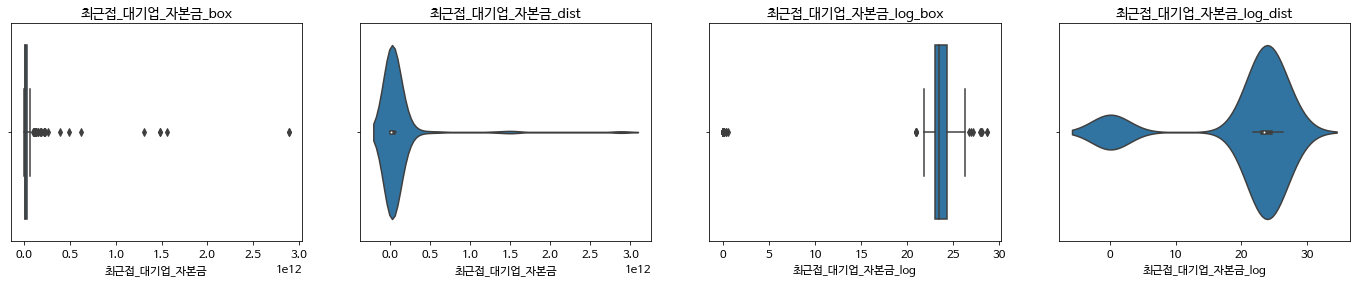

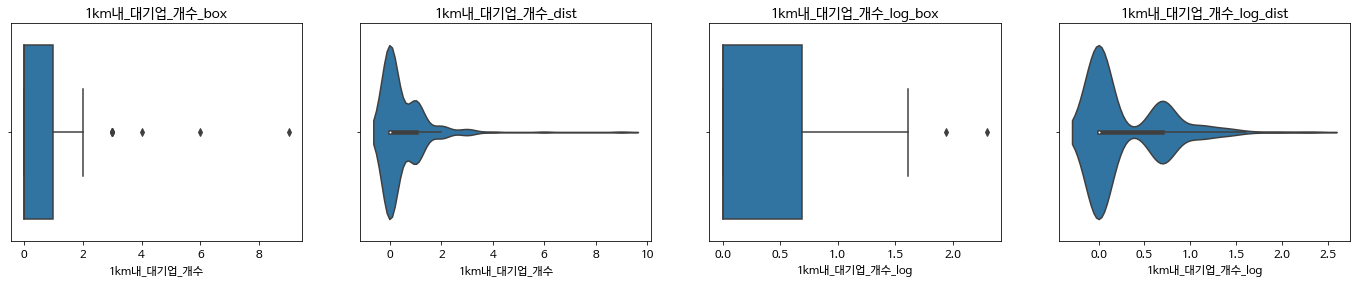

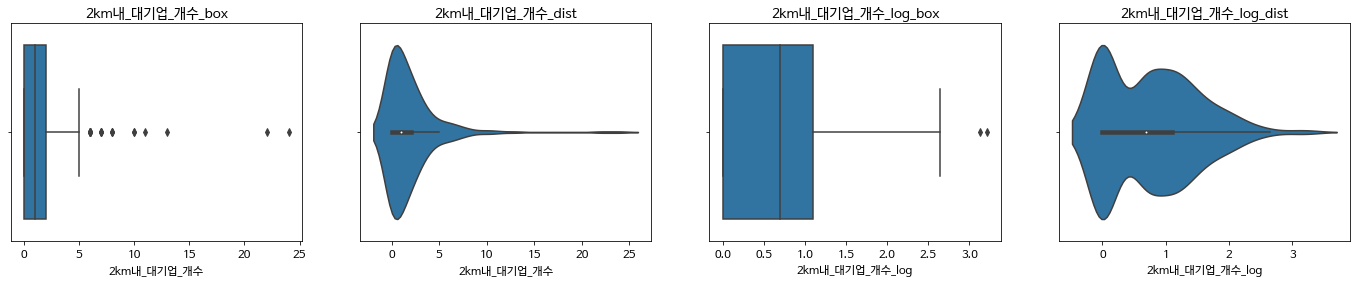

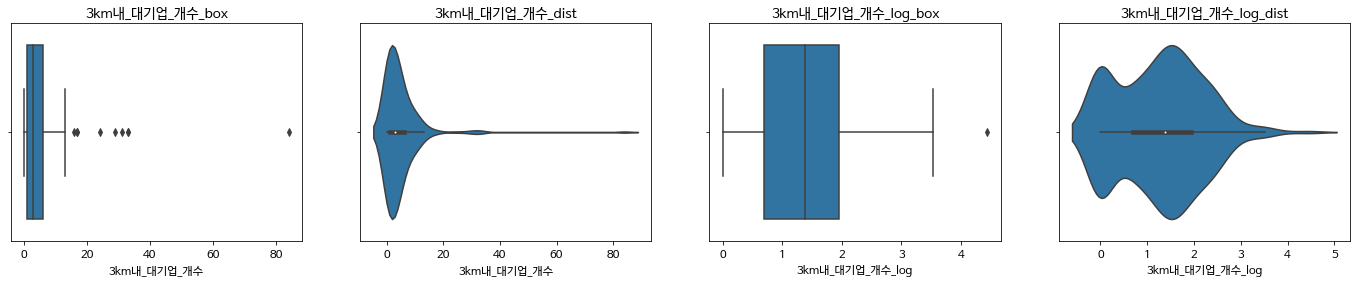

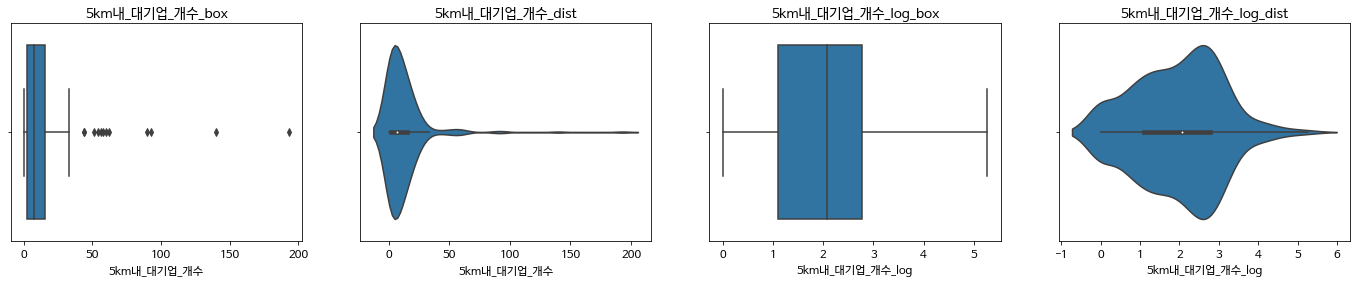

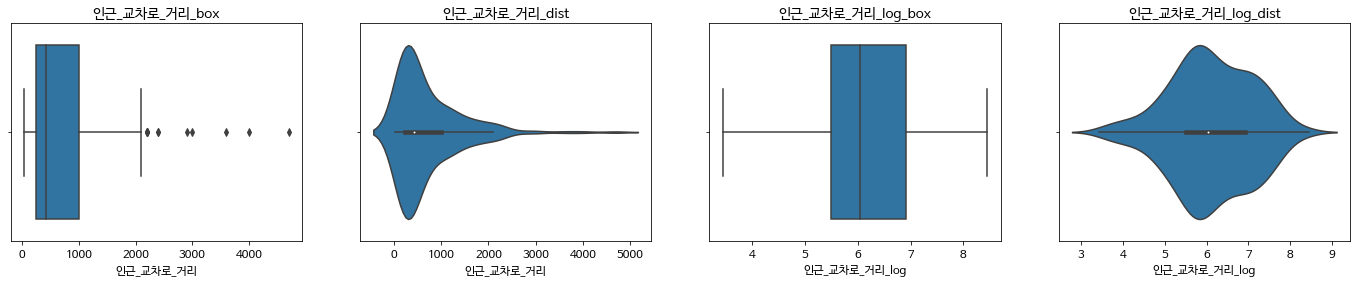

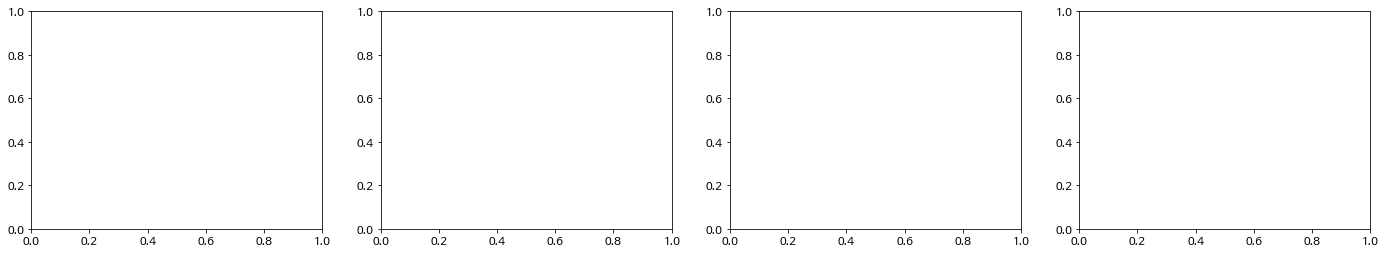

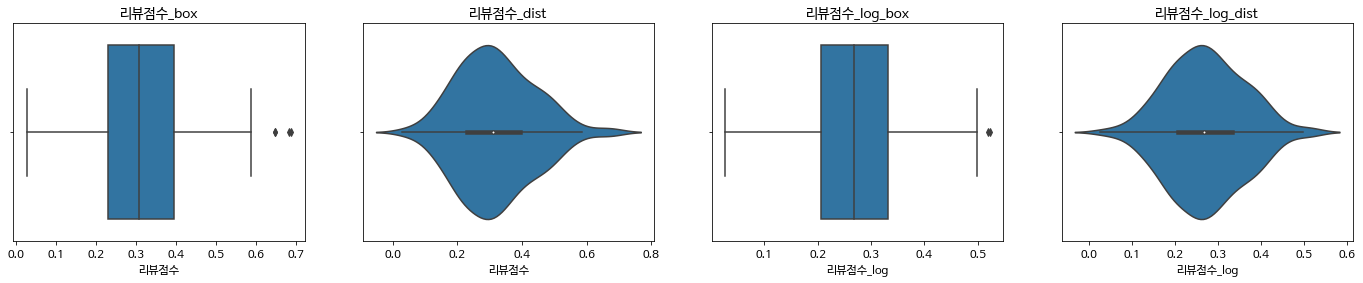

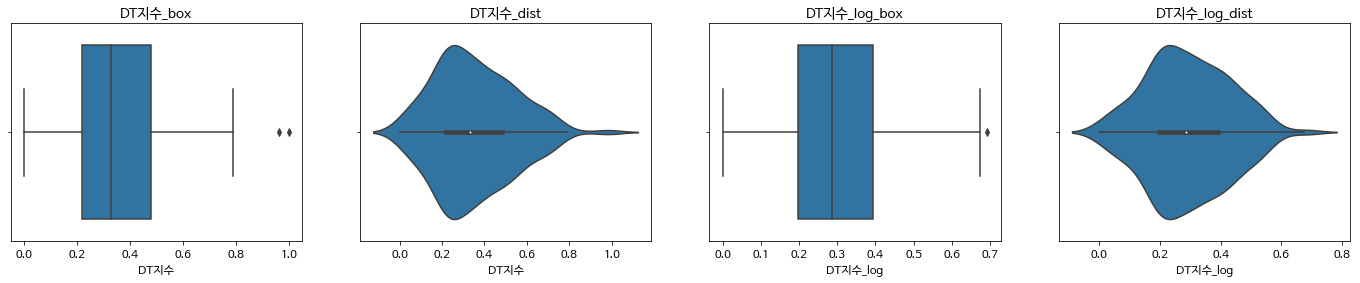

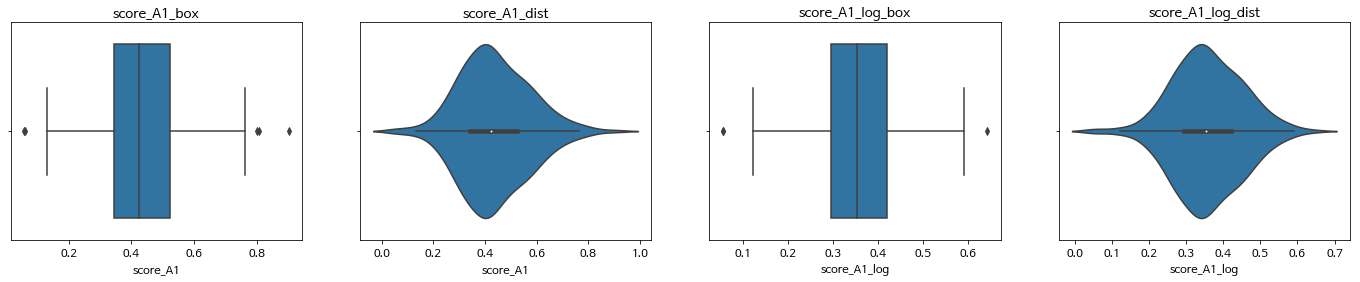

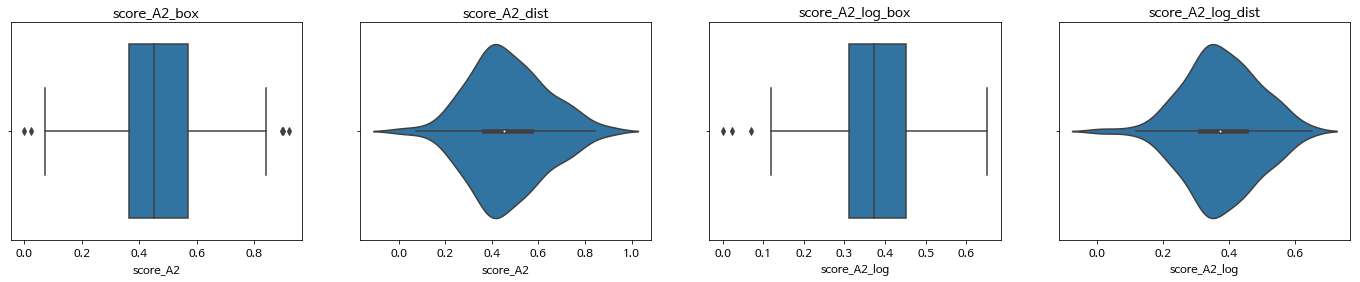

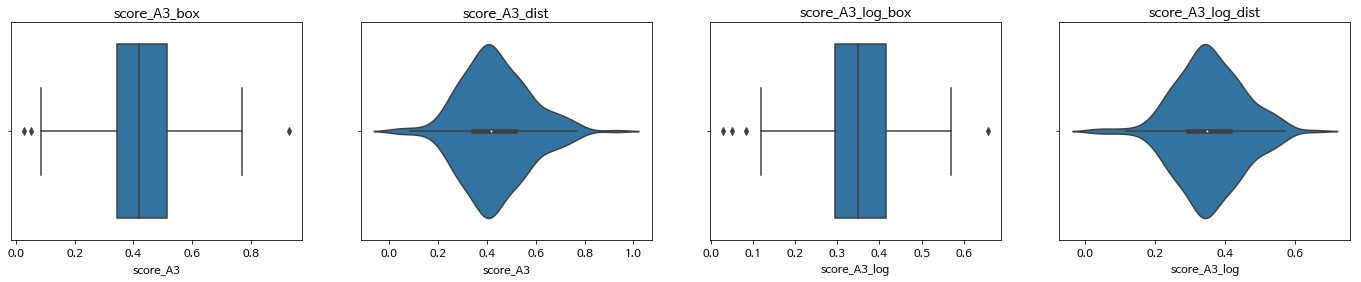

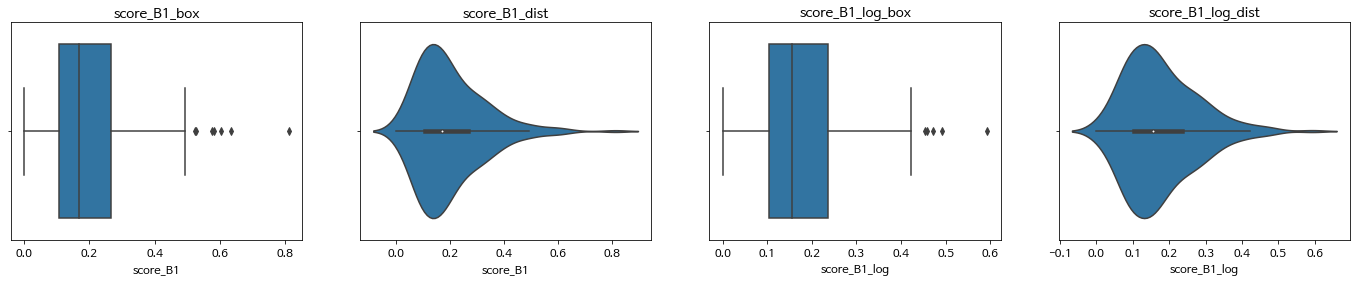

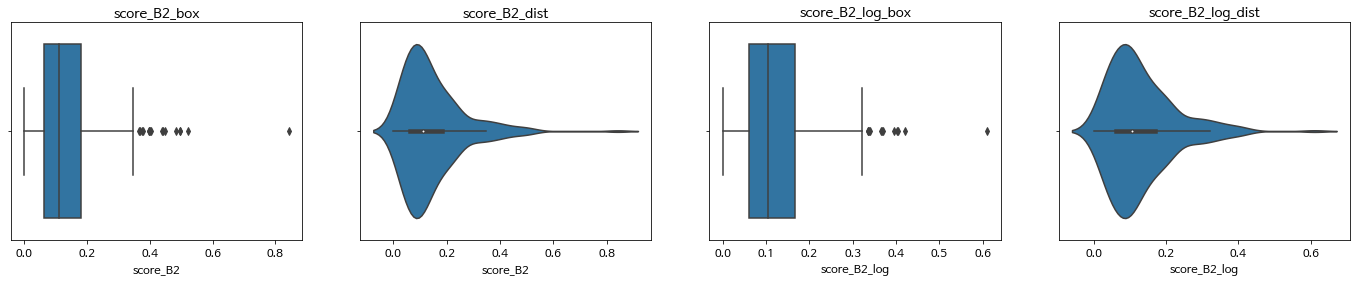

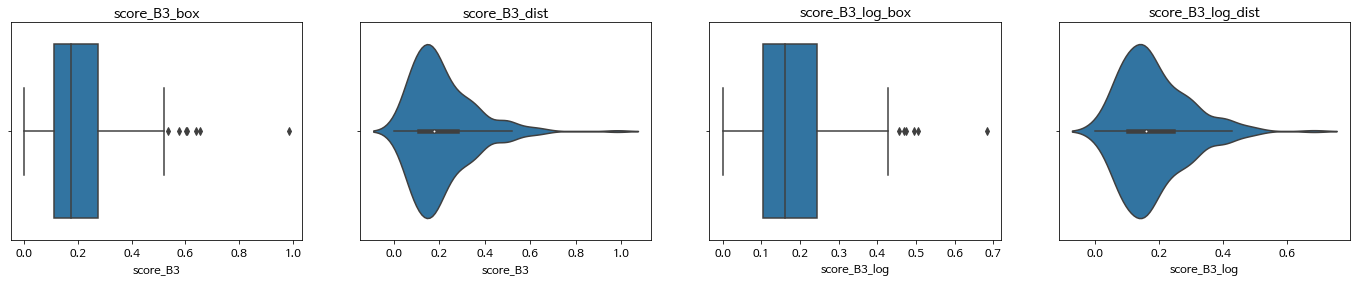

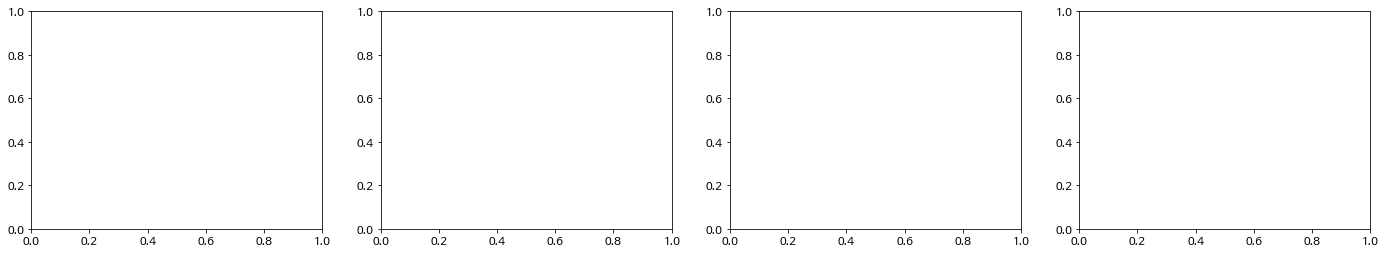

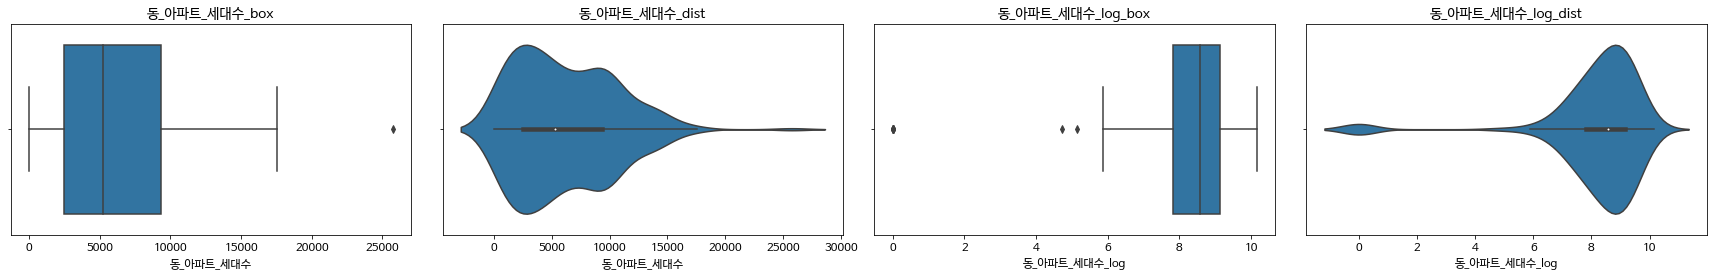

In [15]:
from scipy import stats
df = starbucks_df.copy()
for col_ in df.columns[1:]:
    fig, axs = plt.subplots(1, 4, figsize=(24,4))
    
    try:
        sns.boxplot(x=starbucks_df[col_], ax=axs[0])
        axs[0].set_title(col_+'_box')       
        sns.violinplot(starbucks_df[col_], ax=axs[1])
        axs[1].set_title(col_+'_dist')
        
        starbucks_df[col_+'_log'] = starbucks_df[col_].map(lambda x:np.log(x+1))
        sns.boxplot(x=starbucks_df[col_+'_log'], ax=axs[2])
        axs[2].set_title(col_+'_log_box')       
        sns.violinplot(starbucks_df[col_+'_log'], ax=axs[3])
        axs[3].set_title(col_+'_log_dist')
    except Exception as e:
        print(e)
        continue
fig.tight_layout()

#     plt.figure(figsize=(14,4))
    # plt.xlim(df.관광지_리뷰수.min(), df.관광지_리뷰수.max()*1.1)
#     sns.boxplot(x=df.col)

# Conclusions and Next Steps
Summarize findings here

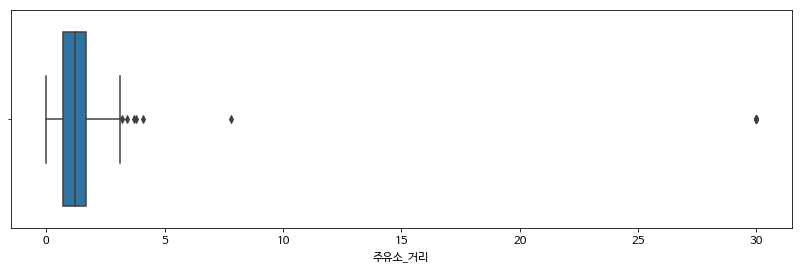

In [567]:
sns.boxplot(df['주유소_거리'])

In [568]:
#df.loc[df['주유소_거리']>6, '주유소_거리'].min()

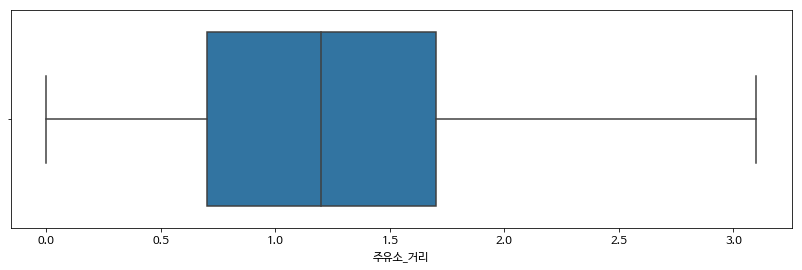

In [569]:
temp_df = outlier_make_one_value(df, '주유소_거리')

In [463]:
#df.loc[df['주유소_거리']> df.loc[df['주유소_거리']>6, '주유소_거리'].min(), '주유소_거리'] = 8

In [570]:
df['주유소_거리2'] = df.주유소_거리.map(lambda x:np.log(x+1))
temp_df['주유소_거리2'] = df.주유소_거리.map(lambda x:np.log(x+1))

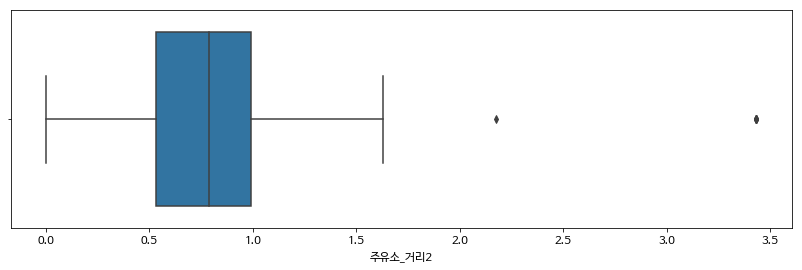

In [571]:
sns.boxplot(x=temp_df['주유소_거리2'])

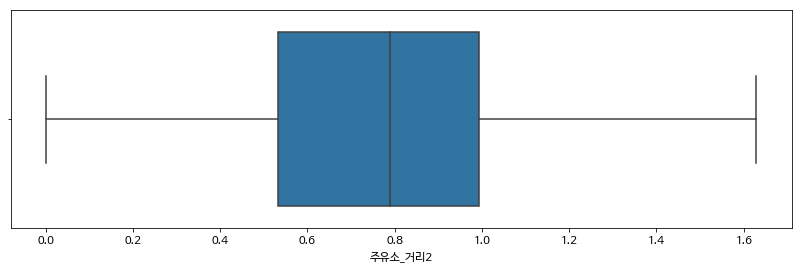

In [572]:
temp_df = outlier_make_one_value(temp_df, '주유소_거리2')

In [575]:
df['주유소_거리3'] = df.주유소_거리.map(lambda x:1/x)
temp_df['주유소_거리3'] = df.주유소_거리.map(lambda x:1/x)

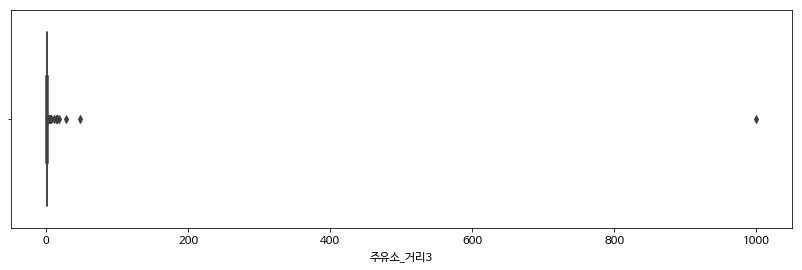

In [576]:
sns.boxplot(x=temp_df['주유소_거리3'])

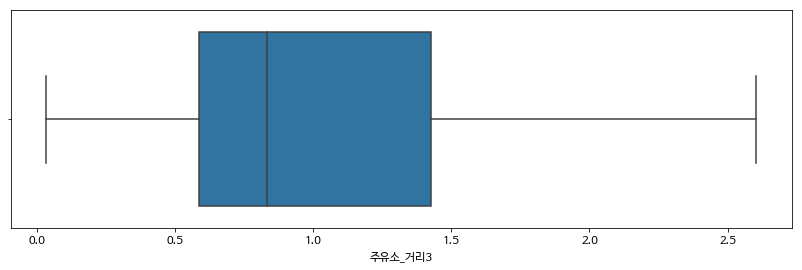

In [577]:
temp_df = outlier_make_one_value(temp_df, '주유소_거리3')

In [134]:
# df.loc[df['주유소_거리3'] > 800, '주유소_거리3'] = df.loc[df['주유소_거리3'] < 800, '주유소_거리3'].max()

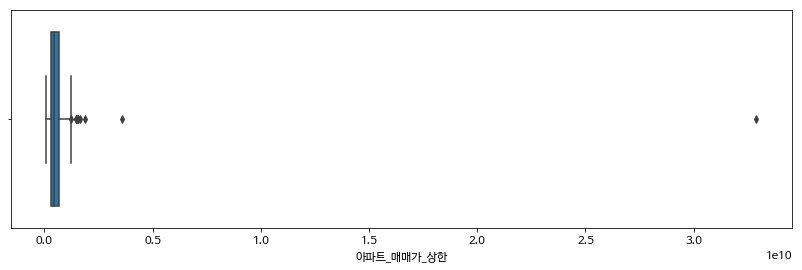

In [578]:
sns.boxplot(df['아파트_매매가_상한'])

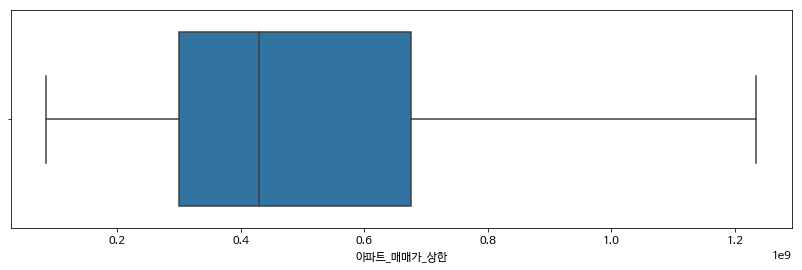

In [579]:
temp_df = outlier_make_one_value(temp_df, '아파트_매매가_상한')

In [580]:
df['아파트_매매가_log'] = df['아파트_매매가_상한'].map(lambda x:np.log(x))
temp_df['아파트_매매가_log'] = df['아파트_매매가_상한'].map(lambda x:np.log(x))

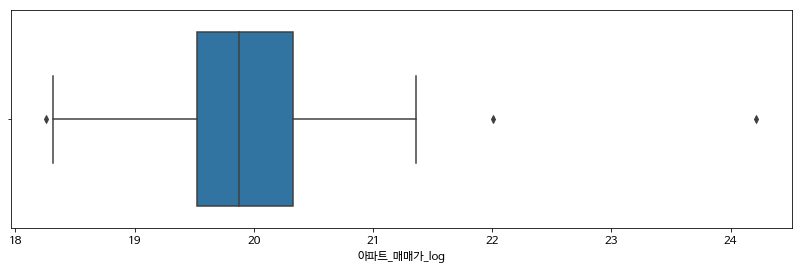

In [581]:
sns.boxplot(df['아파트_매매가_log'])

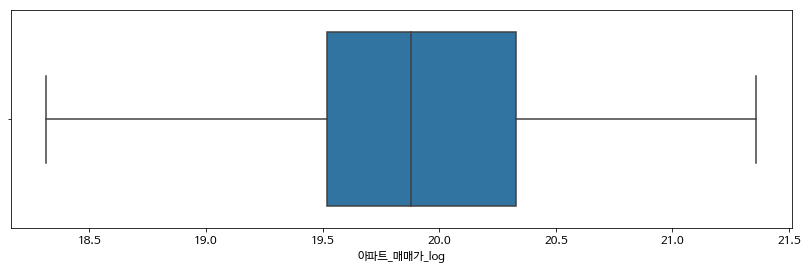

In [582]:
temp_df = outlier_make_one_value(temp_df, '아파트_매매가_log')

In [583]:
df['아파트_매매가_역수'] = df['아파트_매매가_상한'].map(lambda x:1/x)
temp_df['아파트_매매가_역수'] = df['아파트_매매가_상한'].map(lambda x:1/x)

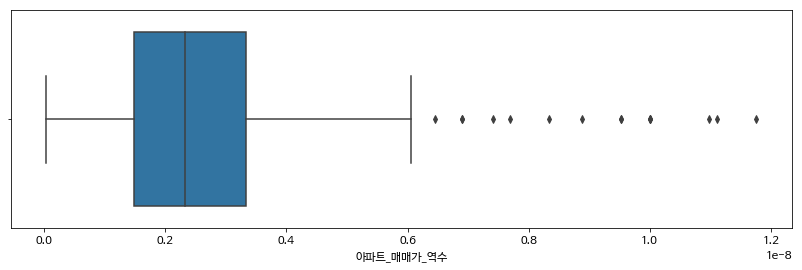

In [584]:
sns.boxplot(df['아파트_매매가_역수'])

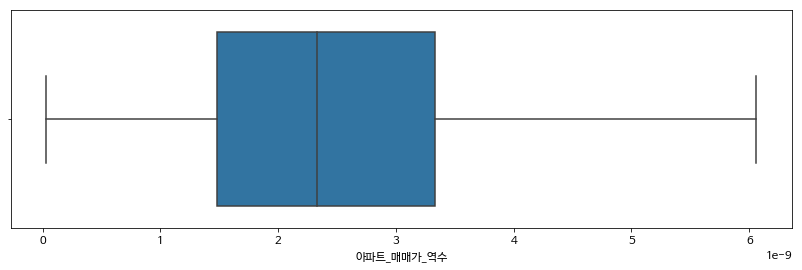

In [585]:
temp_df = outlier_make_one_value(temp_df, '아파트_매매가_역수')

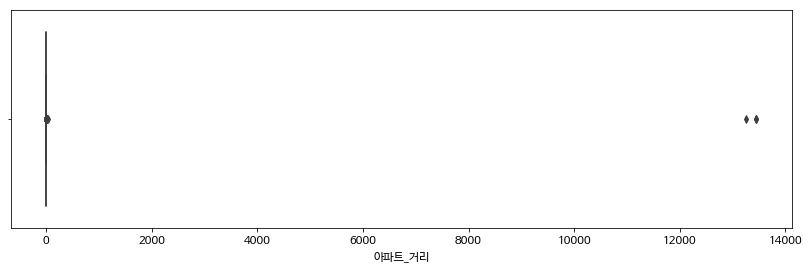

In [586]:
sns.boxplot(df['아파트_거리'])

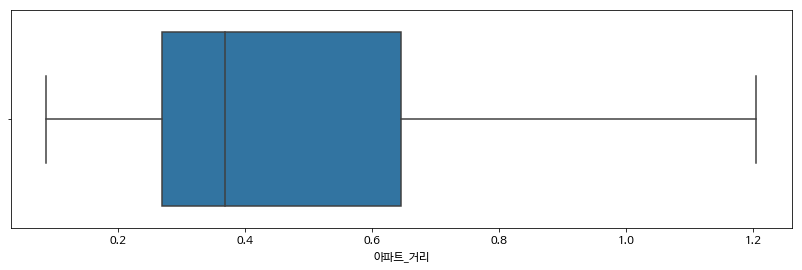

In [587]:
temp_df = outlier_make_one_value(temp_df, '아파트_거리')

In [588]:
df['아파트_거리_log'] = df['아파트_거리'].map(lambda x:np.log(x))
df['아파트_거리_역수'] = df['아파트_거리'].map(lambda x:1/x)
temp_df['아파트_거리_log'] = df['아파트_거리'].map(lambda x:np.log(x))
temp_df['아파트_거리_역수'] = df['아파트_거리'].map(lambda x:1/x)

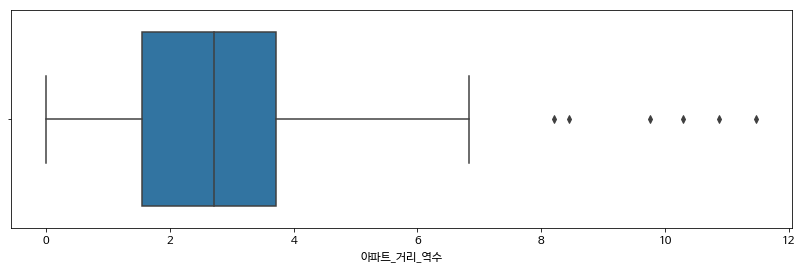

In [589]:
sns.boxplot(df['아파트_거리_역수'])

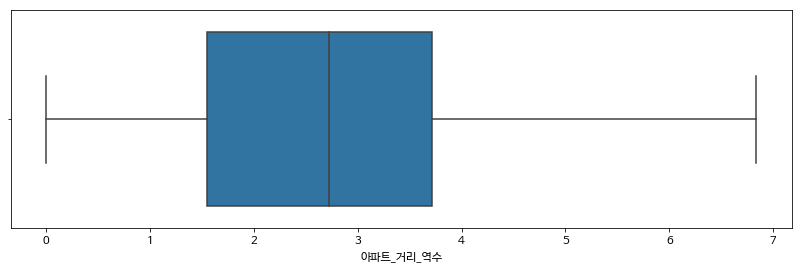

In [590]:
temp_df = outlier_make_one_value(temp_df, '아파트_거리_역수')

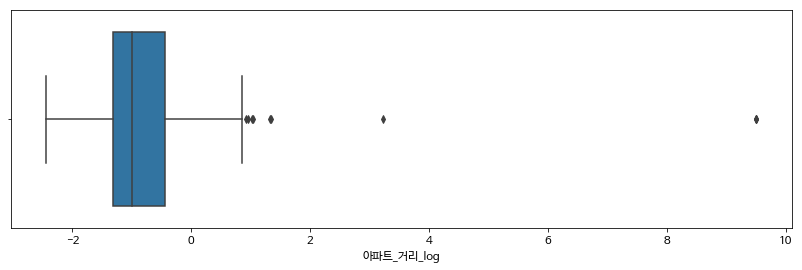

In [591]:
sns.boxplot(df['아파트_거리_log'])

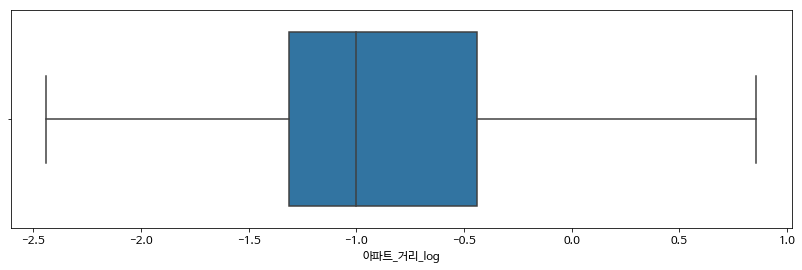

In [592]:
temp_df = outlier_make_one_value(temp_df, '아파트_거리_log')

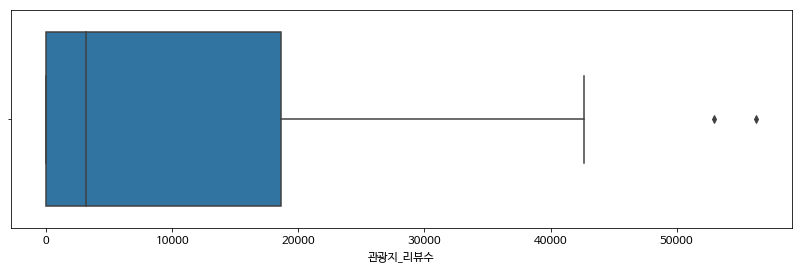

In [593]:
sns.boxplot(df['관광지_리뷰수'])

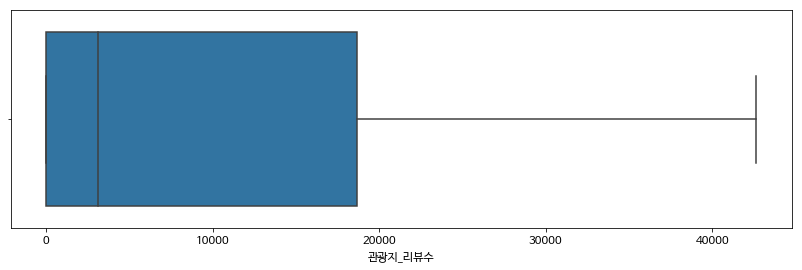

In [594]:
temp_df = outlier_make_one_value(temp_df, '관광지_리뷰수')

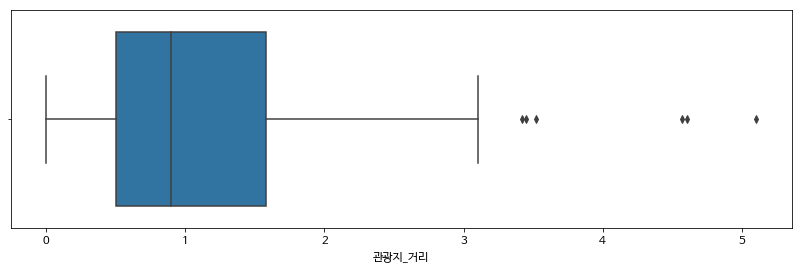

In [595]:
sns.boxplot(df['관광지_거리'])

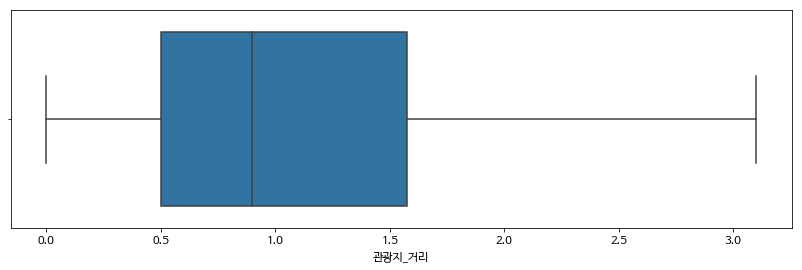

In [596]:
temp_df = outlier_make_one_value(temp_df, '관광지_거리')

In [597]:
df['관광지_점수'] = df.apply(lambda row:row['관광지_리뷰수']/(row['관광지_거리']+1e-7), axis=1)
temp_df['관광지_점수'] = df.apply(lambda row:row['관광지_리뷰수']/(row['관광지_거리']+1e-7), axis=1)

In [600]:
df['관광지_점수2'] = df.apply(lambda row:minmax_norm(df, row, '관광지_리뷰수')/(minmax_norm(df, row, '관광지_거리')+1e-7), axis=1)
temp_df['관광지_점수2'] = df.apply(lambda row:minmax_norm(df, row, '관광지_리뷰수')/(minmax_norm(df, row, '관광지_거리')+1e-7), axis=1)

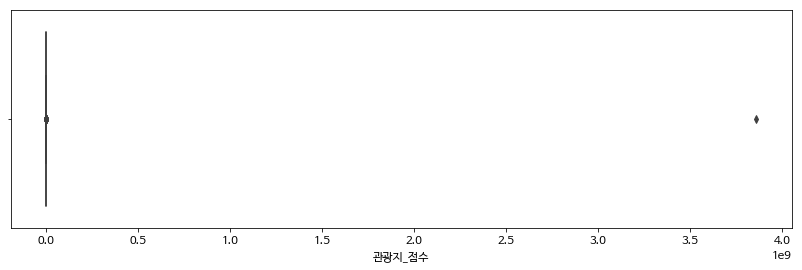

In [601]:
sns.boxplot(df['관광지_점수'])

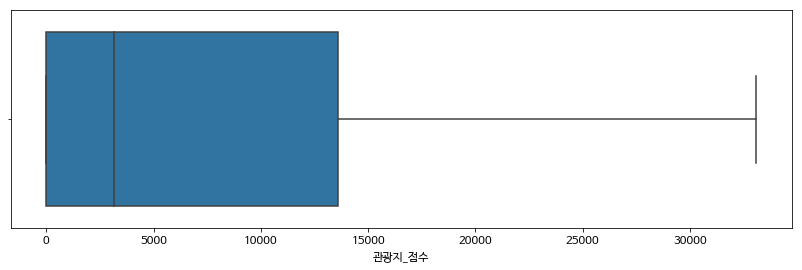

In [602]:
temp_df = outlier_make_one_value(temp_df, '관광지_점수')

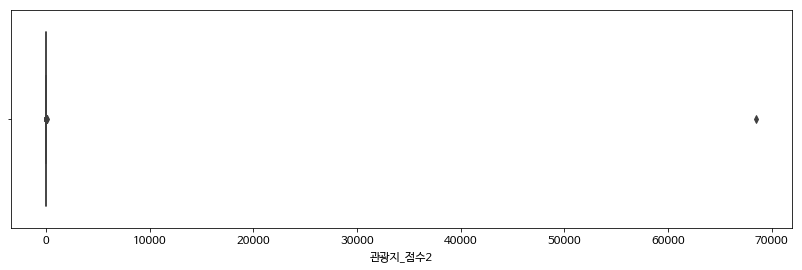

In [603]:
sns.boxplot(df['관광지_점수2'])

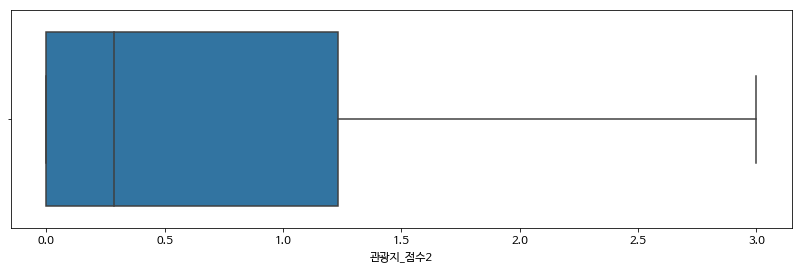

In [604]:
temp_df = outlier_make_one_value(temp_df, '관광지_점수2')

In [495]:
# df.loc[df['관광지_점수']>2e5, '관광지_점수'] = df.loc[df['관광지_점수']>2e5,'관광지_점수'].min()

In [496]:
# sns.boxplot(df.loc[df['관광지_점수']<3.5e9,'관광지_점수'])

In [605]:
df['관광지_점수_log'] = df['관광지_점수'].map(lambda x:np.log(x+1))
temp_df['관광지_점수_log'] = df['관광지_점수'].map(lambda x:np.log(x+1))

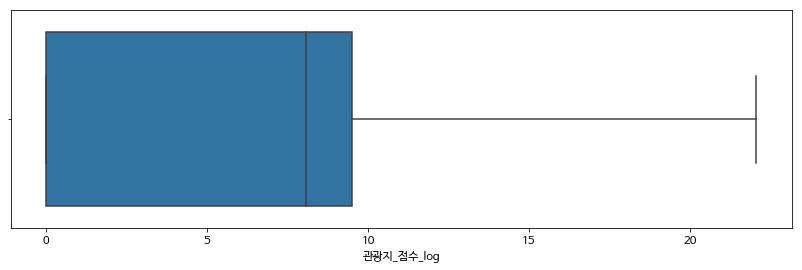

In [606]:
sns.boxplot(df['관광지_점수_log'])

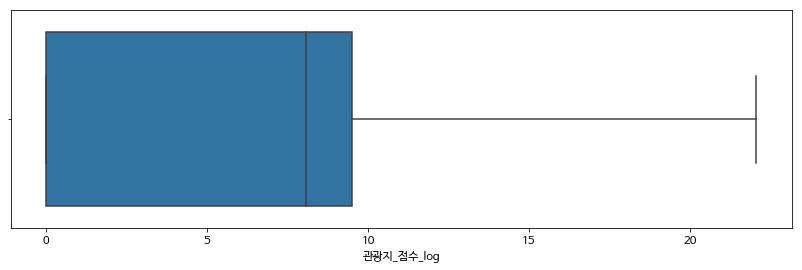

In [607]:
temp_df = outlier_make_one_value(temp_df, '관광지_점수_log')

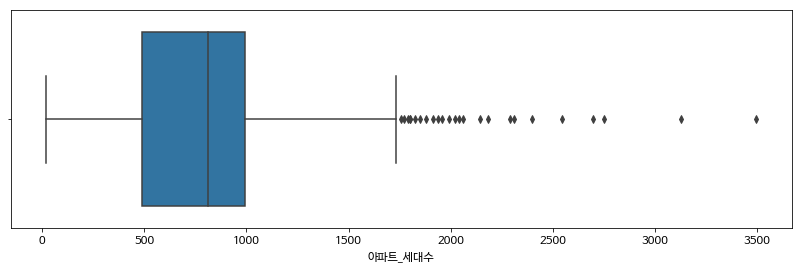

In [608]:
sns.boxplot(df['아파트_세대수'])

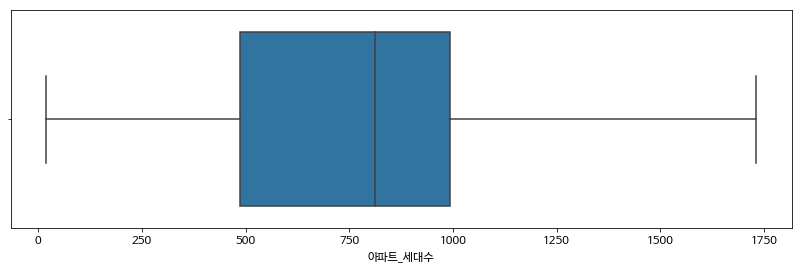

In [609]:
temp_df = outlier_make_one_value(temp_df, '아파트_세대수')

In [610]:
df['아파트_세대수_log'] = df['아파트_세대수'].map(lambda x:np.log(x+1))
temp_df['아파트_세대수_log'] = df['아파트_세대수'].map(lambda x:np.log(x+1))

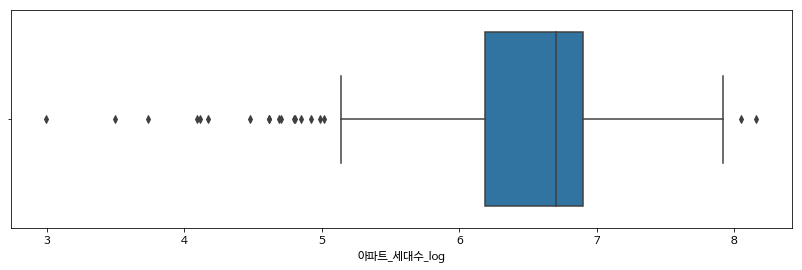

In [611]:
sns.boxplot(df['아파트_세대수_log'])

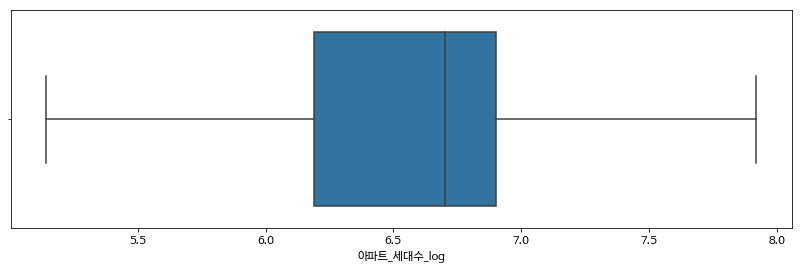

In [612]:
temp_df = outlier_make_one_value(temp_df, '아파트_세대수_log')

In [613]:
df['아파트_세대수_sqrt'] = df['아파트_세대수'].map(lambda x:np.sqrt(x))
temp_df['아파트_세대수_sqrt'] = df['아파트_세대수'].map(lambda x:np.sqrt(x))

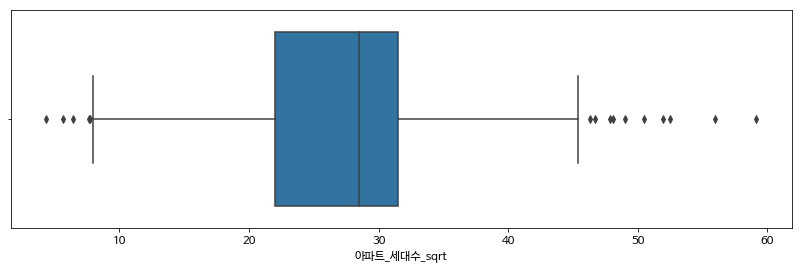

In [614]:
sns.boxplot(df['아파트_세대수_sqrt'])

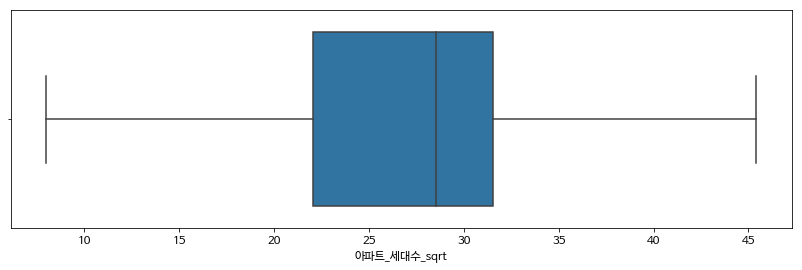

In [615]:
temp_df = outlier_make_one_value(temp_df, '아파트_세대수_sqrt')

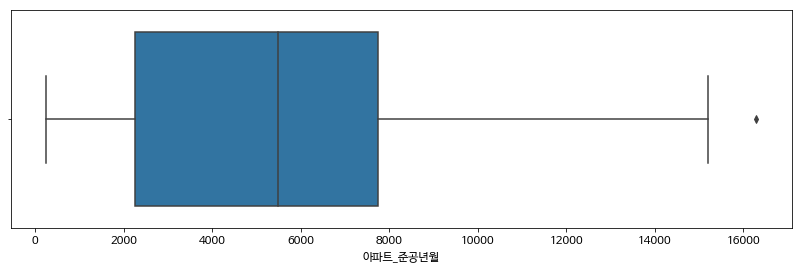

In [616]:
sns.boxplot(df['아파트_준공년월'])

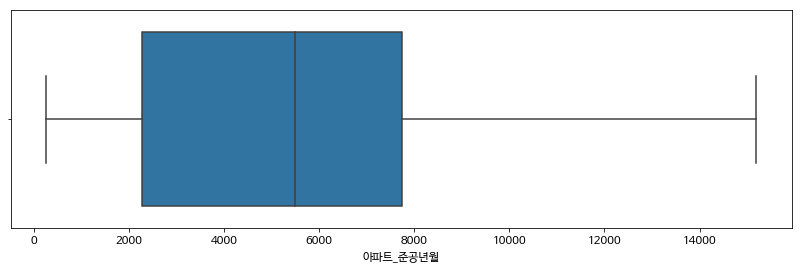

In [617]:
temp_df = outlier_make_one_value(temp_df, '아파트_준공년월')

In [618]:
df['아파트_점수1'] = df.apply(lambda row:(row['아파트_세대수']*row['아파트_매매가_log'])/(row['아파트_준공년월']*row['아파트_거리_log']+1e-7), axis=1)
temp_df['아파트_점수1'] = df.apply(lambda row:(row['아파트_세대수']*row['아파트_매매가_log'])/(row['아파트_준공년월']*row['아파트_거리_log']+1e-7), axis=1)

In [619]:
df['아파트_점수2'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')*minmax_norm(df,row,'아파트_매매가_log'))/(minmax_norm(df, row, '아파트_준공년월')*minmax_norm(df, row, '아파트_거리_log')+1e-7), axis=1)
temp_df['아파트_점수2'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')*minmax_norm(df,row,'아파트_매매가_log'))/(minmax_norm(df, row, '아파트_준공년월')*minmax_norm(df, row, '아파트_거리_log')+1e-7), axis=1)

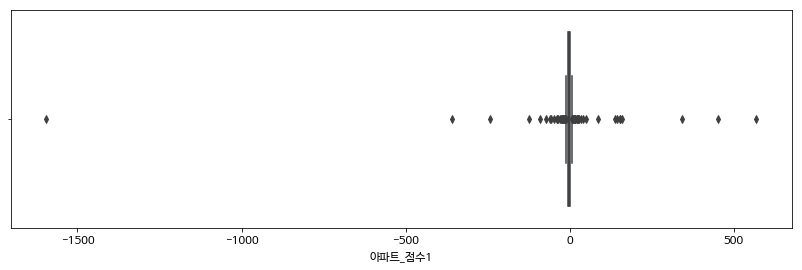

In [620]:
sns.boxplot(df['아파트_점수1'])

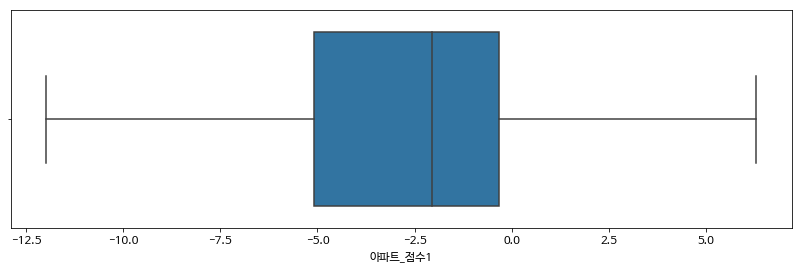

In [621]:
temp_df = outlier_make_one_value(temp_df, '아파트_점수1')

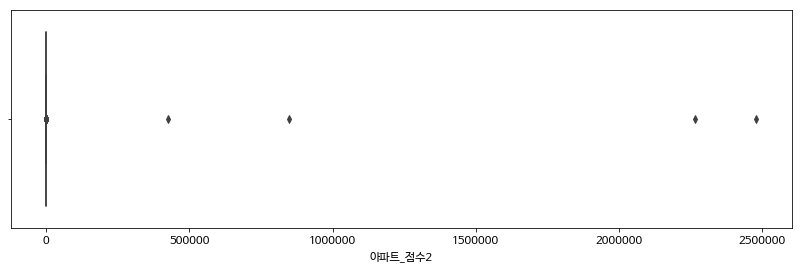

In [622]:
sns.boxplot(df['아파트_점수2'])

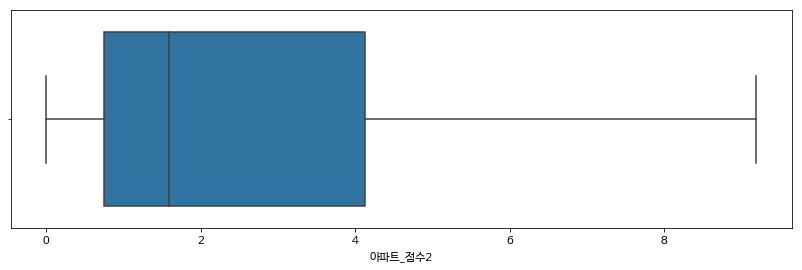

In [623]:
temp_df = outlier_make_one_value(temp_df, '아파트_점수2')

In [624]:
df['아파트_점수3'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')+minmax_norm(df,row,'아파트_매매가_log'))/(minmax_norm(df, row, '아파트_준공년월')+minmax_norm(df, row, '아파트_거리_log')+1e-7), axis=1)
temp_df['아파트_점수3'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')+minmax_norm(df,row,'아파트_매매가_log'))/(minmax_norm(df, row, '아파트_준공년월')+minmax_norm(df, row, '아파트_거리_log')+1e-7), axis=1)

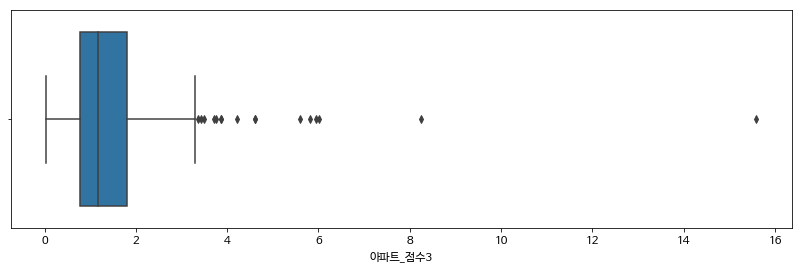

In [625]:
sns.boxplot(df['아파트_점수3'])

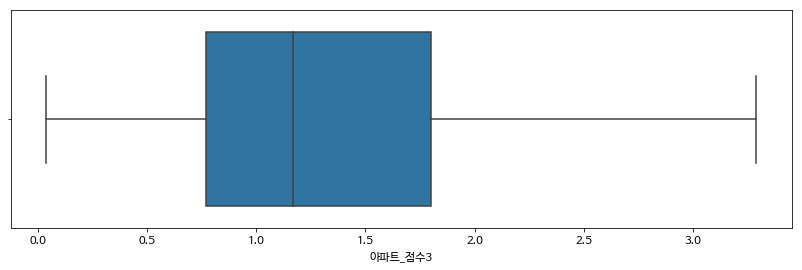

In [626]:
temp_df = outlier_make_one_value(temp_df, '아파트_점수3')

In [627]:
df['아파트_점수4'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')+minmax_norm(df,row,'아파트_매매가_log')*2)/(minmax_norm(df, row, '아파트_준공년월')+minmax_norm(df, row, '아파트_거리_log')*2+1e-7), axis=1)
temp_df['아파트_점수4'] = df.apply(lambda row:(minmax_norm(df,row,'아파트_세대수')+minmax_norm(df,row,'아파트_매매가_log')*2)/(minmax_norm(df, row, '아파트_준공년월')+minmax_norm(df, row, '아파트_거리_log')*2+1e-7), axis=1)

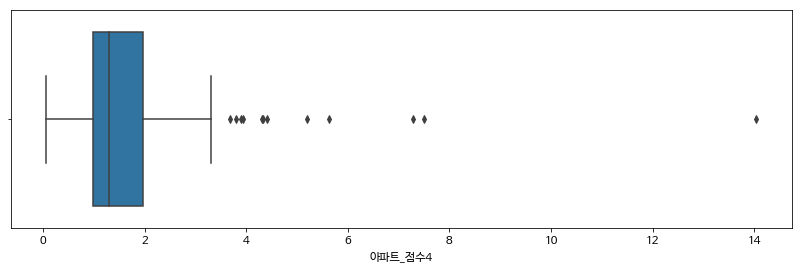

In [628]:
sns.boxplot(df['아파트_점수4']) 

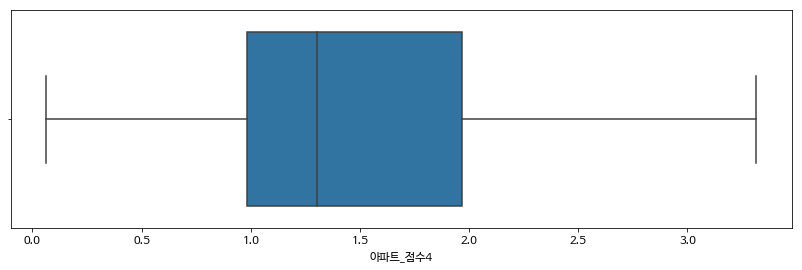

In [629]:
temp_df = outlier_make_one_value(temp_df, '아파트_점수4')

In [630]:
df['아파트_점수5'] = df['아파트_점수4'].map(lambda x:np.log(x+1))
temp_df['아파트_점수5'] = df['아파트_점수4'].map(lambda x:np.log(x+1))

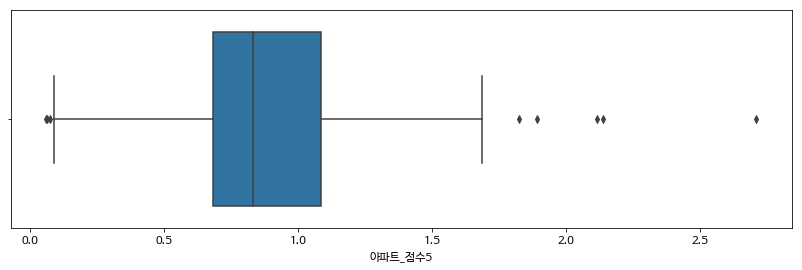

In [631]:
sns.boxplot(df['아파트_점수5']) 

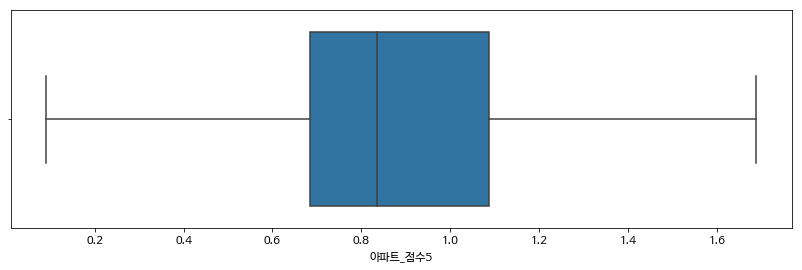

In [632]:
temp_df = outlier_make_one_value(temp_df, '아파트_점수5')

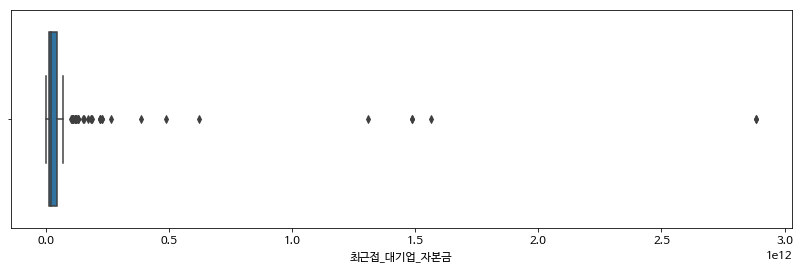

In [633]:
sns.boxplot(df['최근접_대기업_자본금'])

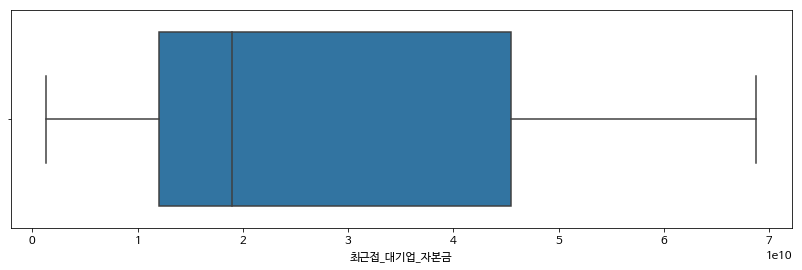

In [634]:
temp_df = outlier_make_one_value(temp_df, '최근접_대기업_자본금')

In [635]:
df['최근접_대기업_자본금2'] = df['최근접_대기업_자본금'].map(lambda x:np.log(x+1))
temp_df['최근접_대기업_자본금2'] = df['최근접_대기업_자본금'].map(lambda x:np.log(x+1))

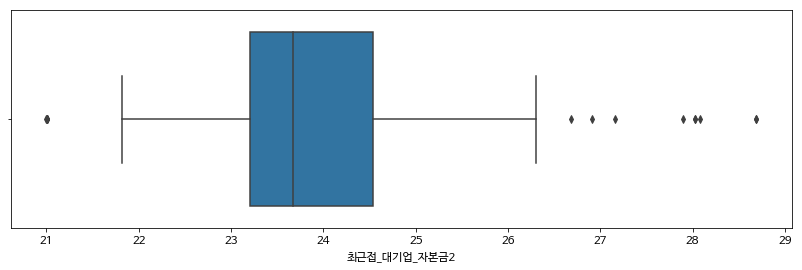

In [636]:
sns.boxplot(df['최근접_대기업_자본금2'])

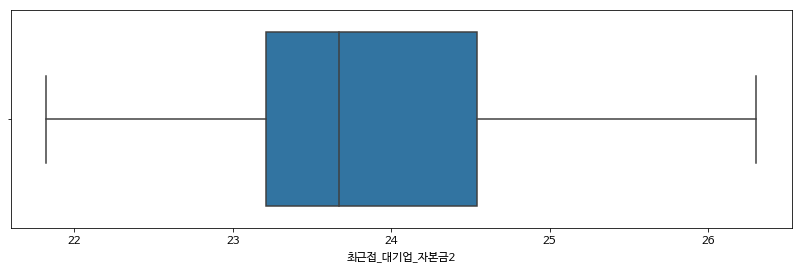

In [637]:
temp_df = outlier_make_one_value(temp_df, '최근접_대기업_자본금2')

In [638]:
df['최근접_대기업_자본금3'] = df['최근접_대기업_자본금'].map(lambda x:1/x)
temp_df['최근접_대기업_자본금3'] = df['최근접_대기업_자본금'].map(lambda x:1/x)

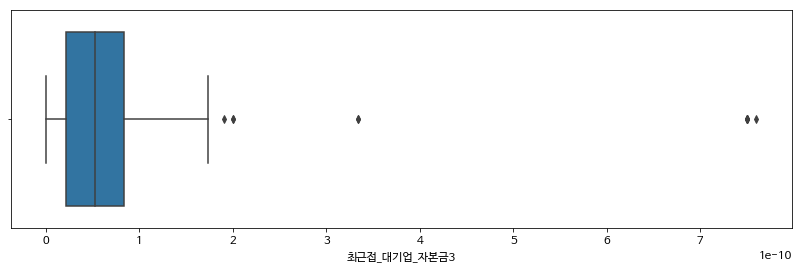

In [639]:
sns.boxplot(df['최근접_대기업_자본금3'])

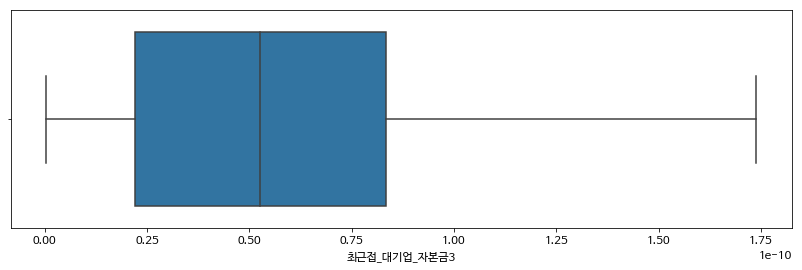

In [640]:
temp_df = outlier_make_one_value(temp_df, '최근접_대기업_자본금3')

In [642]:
df['최근접_대기업_자본금4'] = df['최근접_대기업_자본금'].map(lambda x:np.sqrt(x))
temp_df['최근접_대기업_자본금4'] = df['최근접_대기업_자본금'].map(lambda x:np.sqrt(x))

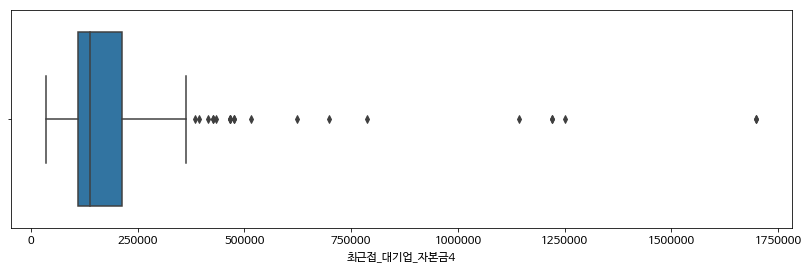

In [643]:
sns.boxplot(df['최근접_대기업_자본금4'])

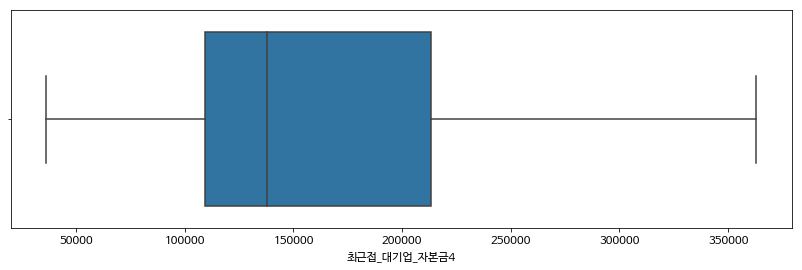

In [644]:
temp_df = outlier_make_one_value(temp_df, '최근접_대기업_자본금4')

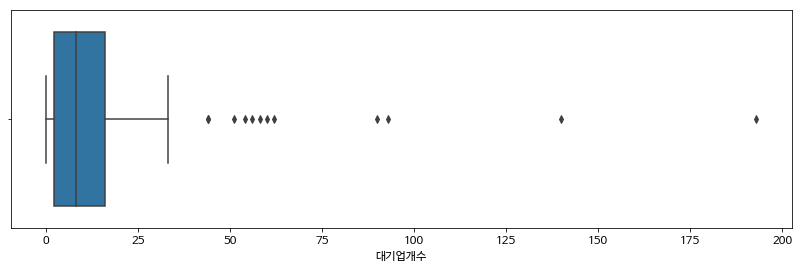

In [645]:
sns.boxplot(df['대기업개수'])

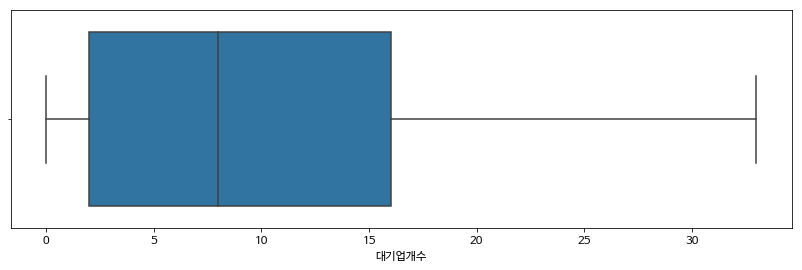

In [646]:
temp_df = outlier_make_one_value(temp_df, '대기업개수')

In [649]:
df['대기업개수_log'] = df['대기업개수'].map(lambda x:np.log(x+1))
temp_df['대기업개수_log'] = df['대기업개수'].map(lambda x:np.log(x+1))

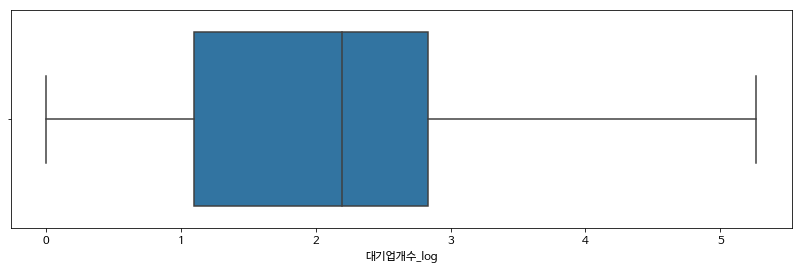

In [650]:
sns.boxplot(df['대기업개수_log'])

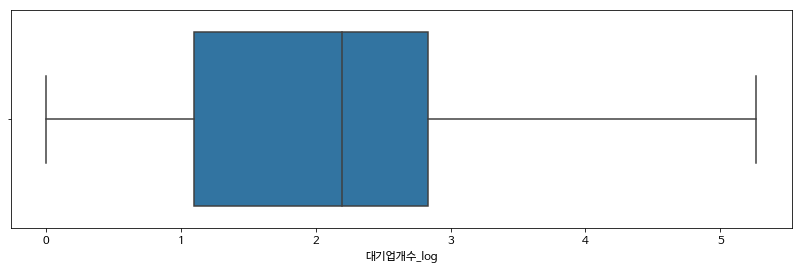

In [651]:
temp_df = outlier_make_one_value(temp_df, '대기업개수_log')

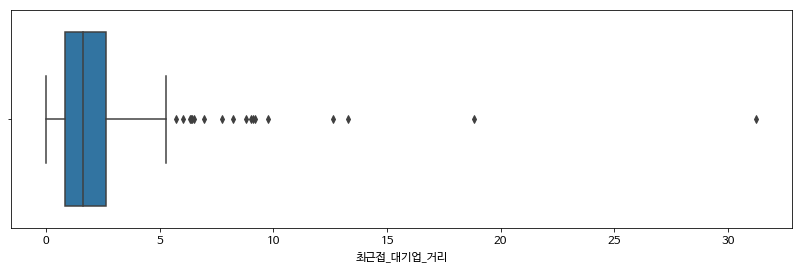

In [720]:
sns.boxplot(df['최근접_대기업_거리'])

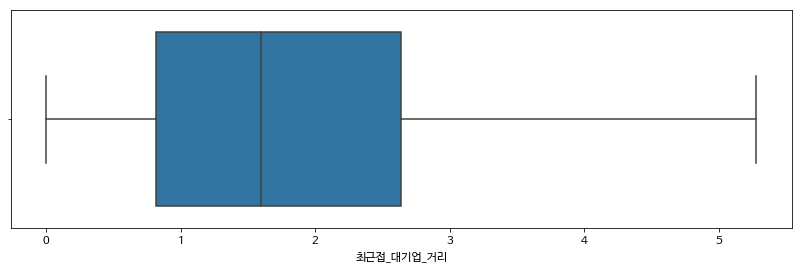

In [721]:
temp_df = outlier_make_one_value(temp_df, '최근접_대기업_거리')

In [723]:
df['최근접_대기업_거리_log'] = df['최근접_대기업_거리'].map(lambda x:np.log(x+1))
temp_df['최근접_대기업_거리_log'] = df['최근접_대기업_거리'].map(lambda x:np.log(x+1))

In [728]:
df['최근접_대기업_거리_역수'] = df['최근접_대기업_거리'].map(lambda x:1/(x+1))
temp_df['최근접_대기업_거리_역수'] = df['최근접_대기업_거리'].map(lambda x:1/(x+1))

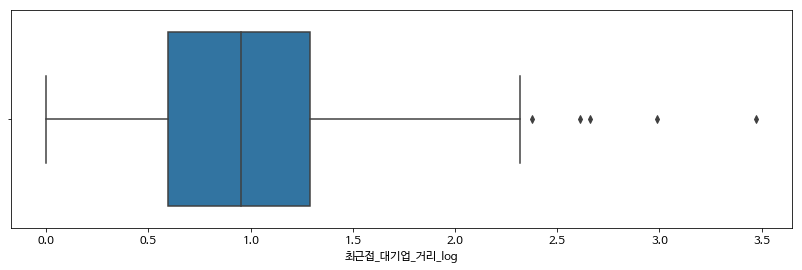

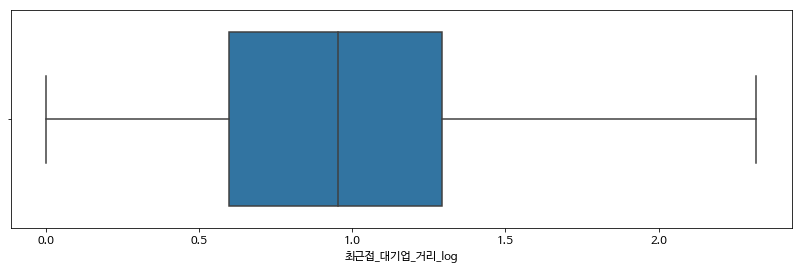

In [726]:
temp_df = check_box_plot(df, temp_df, '최근접_대기업_거리_log')

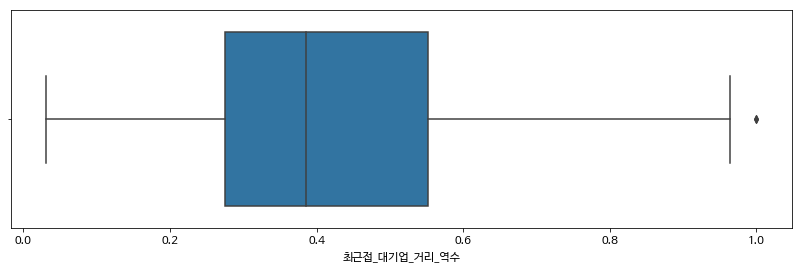

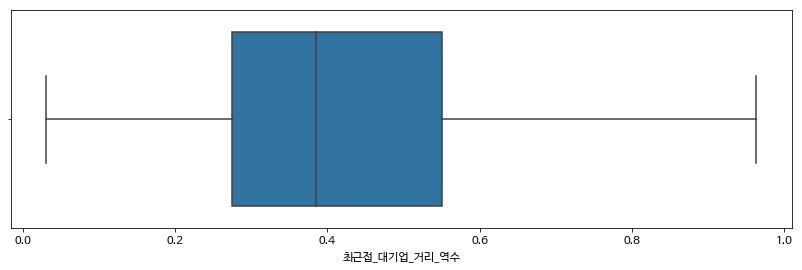

In [729]:
temp_df = check_box_plot(df, temp_df, '최근접_대기업_거리_역수')

In [47]:
def minmax_norm(df, row, col_name):
    return (row[col_name] - df[col_name].min())/(df[col_name].max() - df[col_name].min())

def upper_outliers_iqr(df, col_name, min_per, max_per):
    quartile_1, quartile_3 = np.percentile(df[col_name], [min_per, max_per])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    max_value = df.reset_index(drop=True).loc[np.where((df[col_name] <= upper_bound))][col_name].values.max()
    return np.concatenate(np.where((df[col_name] > upper_bound))), max_value

def down_outliers_iqr(df, col_name, min_per, max_per):
    quartile_1, quartile_3 = np.percentile(df[col_name], [min_per, max_per])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    min_value = df.reset_index(drop=True).loc[np.where((df[col_name] >= lower_bound))][col_name].values.min()
    return np.concatenate(np.where((df[col_name] < lower_bound))), min_value

def outlier_make_one_value(df, col_name, min_per=25, max_per=75):
    temp_df = df.copy()
    outlier_up_idx, one_max = upper_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df = temp_df.reset_index(drop=True)
    temp_df.loc[outlier_up_idx, col_name] = one_max
    outlier_dw_idx, one_min = down_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df.loc[outlier_dw_idx, col_name] = one_min
    sns.boxplot(temp_df[col_name])
    return temp_df

def check_box_plot(src_df, target_df, col_name):
    plt.figure(figsize=(14,4))
    sns.boxplot(df[col_name])
    plt.figure(figsize=(14,4))
    target_df = outlier_make_one_value(target_df, col_name)
    return target_df

In [731]:
df['대기업점수4'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금4'), axis=1)
df['대기업점수3'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금3'), axis=1)
df['대기업점수2'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금2'), axis=1)
df['대기업점수1'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금'), axis=1)
df['대기업점수8'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4'), axis=1)
df['대기업점수7'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3'), axis=1)
df['대기업점수6'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2'), axis=1)
df['대기업점수5'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금'), axis=1)
df['대기업점수9'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
df['대기업점수10'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
df['대기업점수11'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
df['대기업점수12'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
df['대기업점수13'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
df['대기업점수14'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
df['대기업점수15'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
df['대기업점수16'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)

In [732]:
temp_df['대기업점수4'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금4'), axis=1)
temp_df['대기업점수3'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금3'), axis=1)
temp_df['대기업점수2'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금2'), axis=1)
temp_df['대기업점수1'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수')*minmax_norm(df, row, '최근접_대기업_자본금'), axis=1)
temp_df['대기업점수8'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4'), axis=1)
temp_df['대기업점수7'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3'), axis=1)
temp_df['대기업점수6'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2'), axis=1)
temp_df['대기업점수5'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금'), axis=1)
temp_df['대기업점수9'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
temp_df['대기업점수10'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
temp_df['대기업점수11'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
temp_df['대기업점수12'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금')*minmax_norm(df, row, '최근접_대기업_거리_역수'), axis=1)
temp_df['대기업점수13'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금4')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
temp_df['대기업점수14'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금3')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
temp_df['대기업점수15'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금2')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)
temp_df['대기업점수16'] = df.apply(lambda row:minmax_norm(df, row, '대기업개수_log')*minmax_norm(df, row, '최근접_대기업_자본금')/(minmax_norm(df, row, '최근접_대기업_거리_log')+1e-7), axis=1)

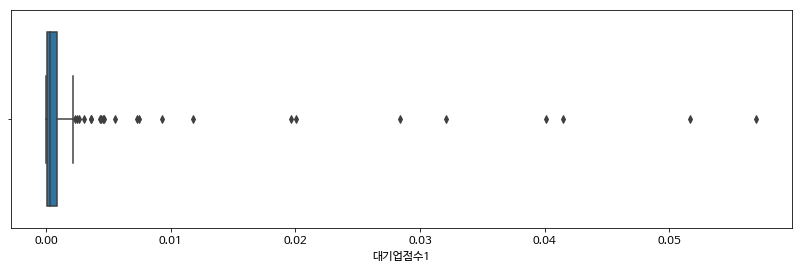

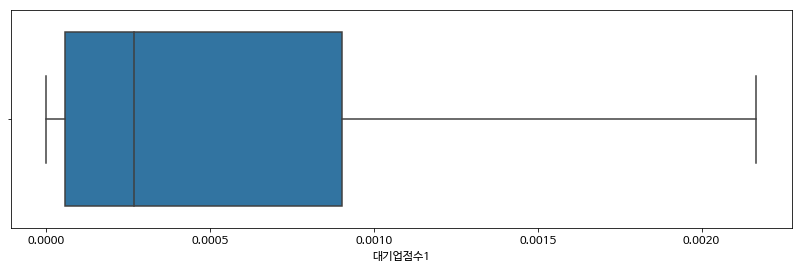

In [662]:
temp_df = check_box_plot(df, temp_df, '대기업점수1')

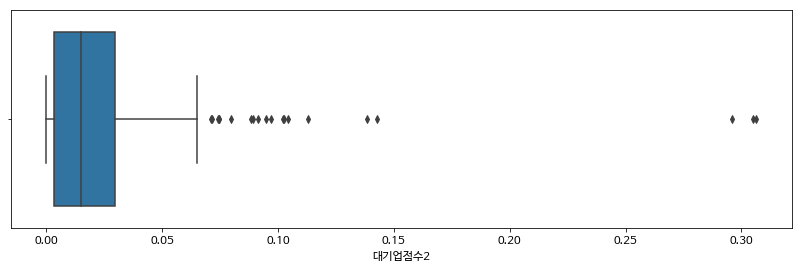

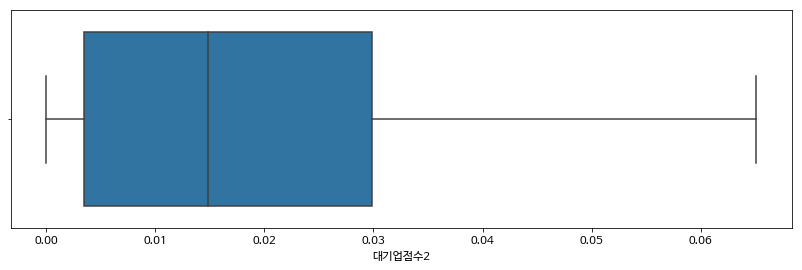

In [663]:
temp_df = check_box_plot(df, temp_df, '대기업점수2')

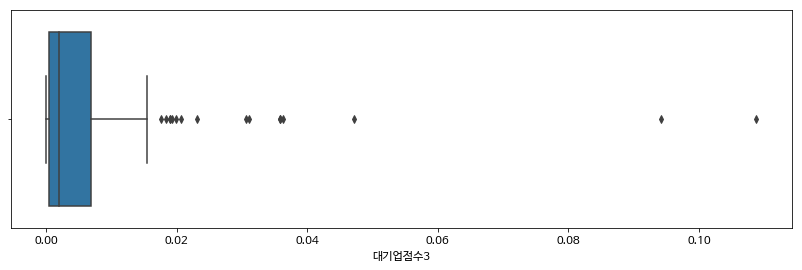

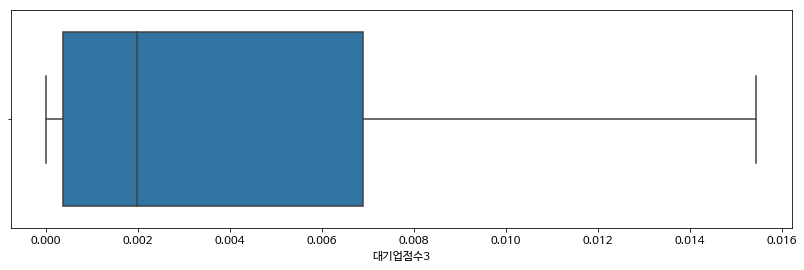

In [664]:
temp_df = check_box_plot(df, temp_df, '대기업점수3')

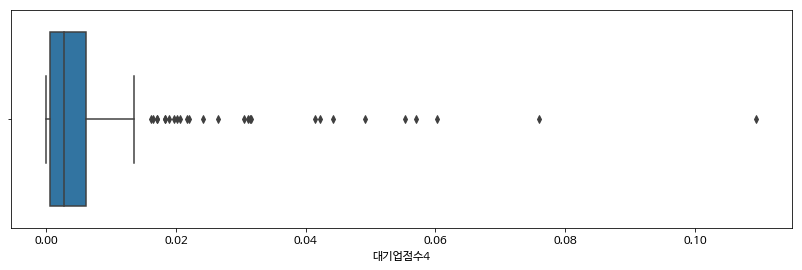

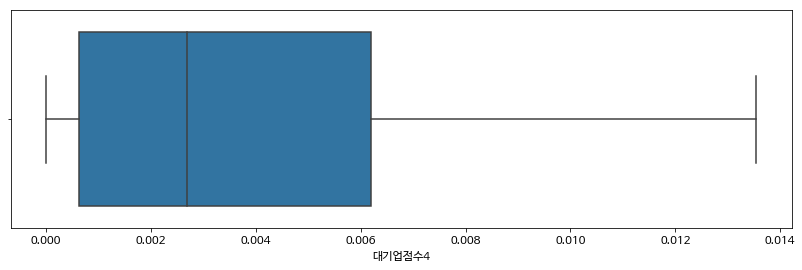

In [665]:
temp_df = check_box_plot(df, temp_df, '대기업점수4')

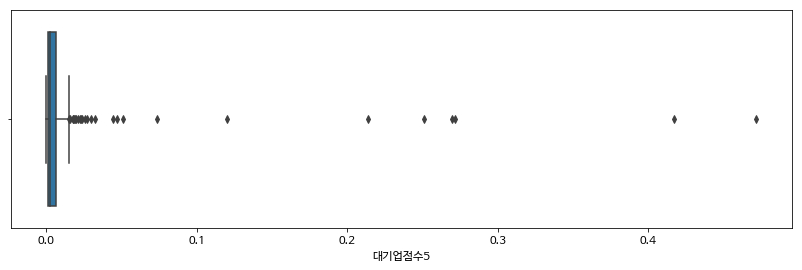

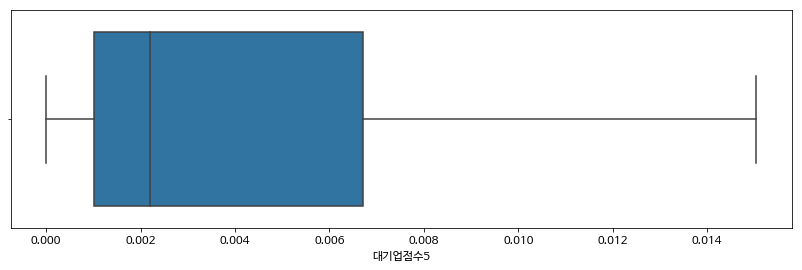

In [666]:
temp_df = check_box_plot(df, temp_df, '대기업점수5')

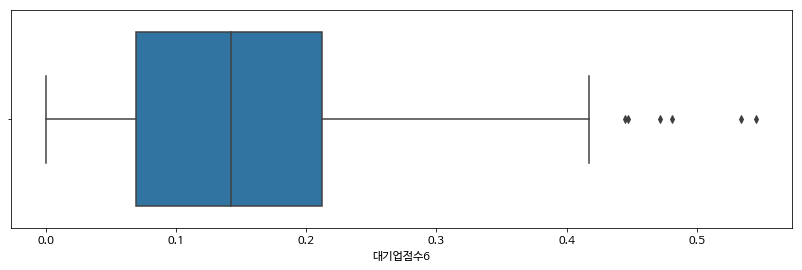

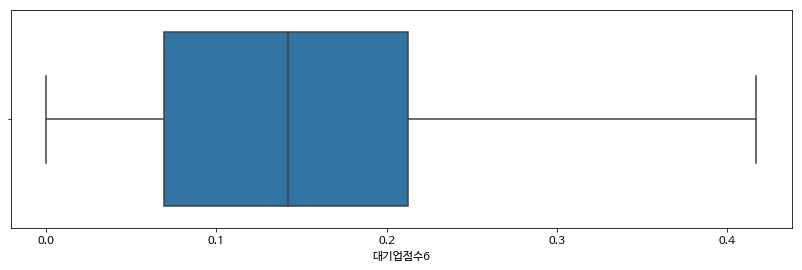

In [667]:
temp_df = check_box_plot(df, temp_df, '대기업점수6')

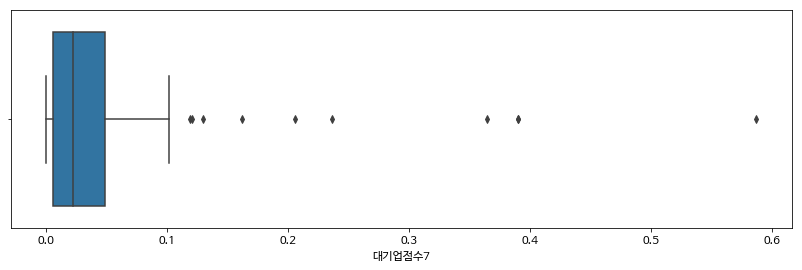

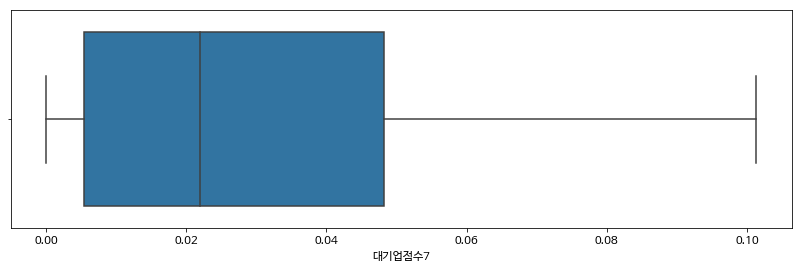

In [668]:
temp_df = check_box_plot(df, temp_df, '대기업점수7')

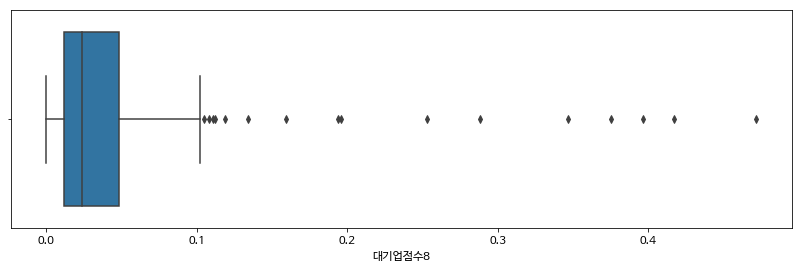

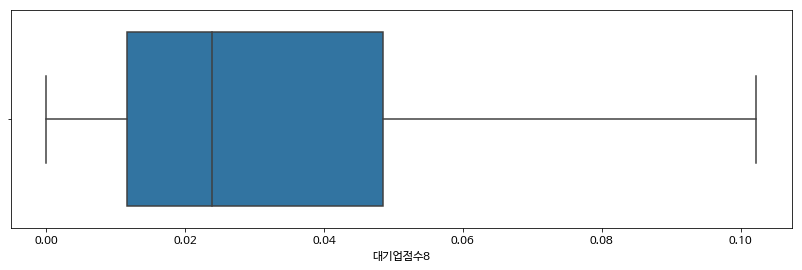

In [669]:
temp_df = check_box_plot(df, temp_df, '대기업점수8')

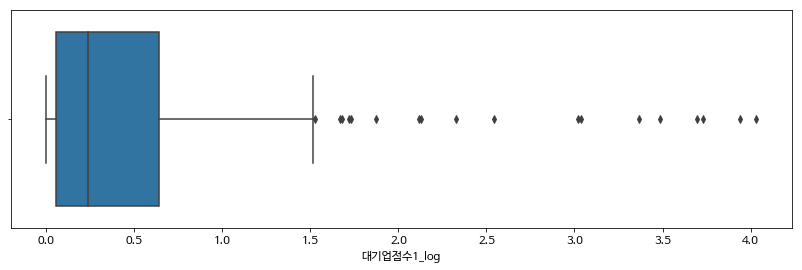

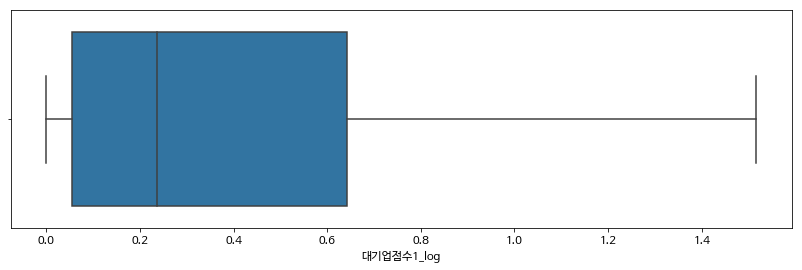

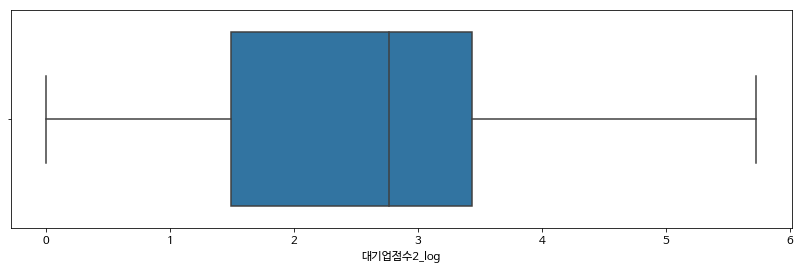

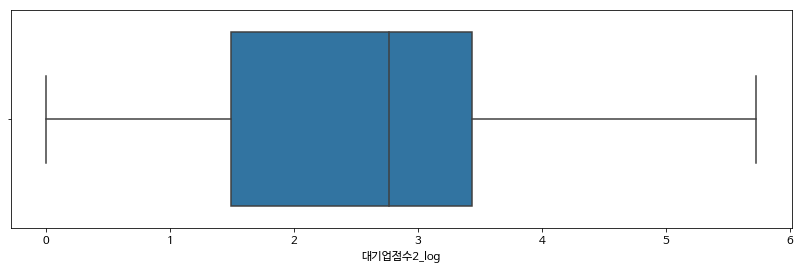

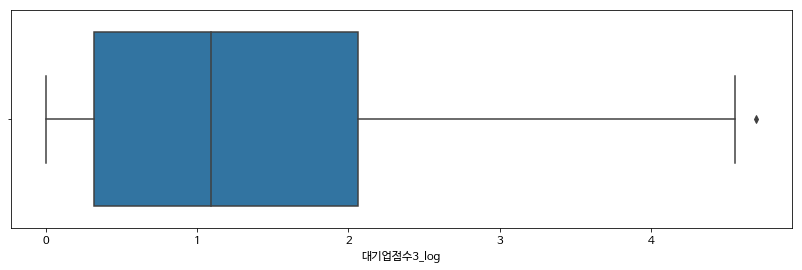

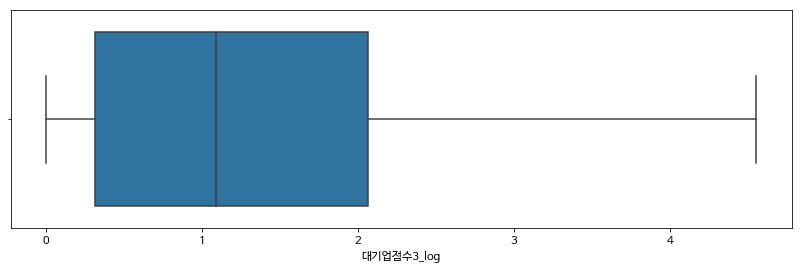

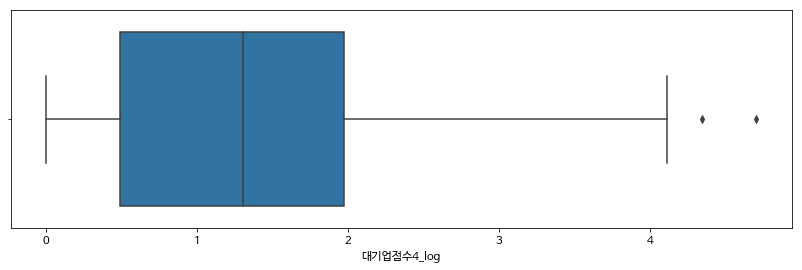

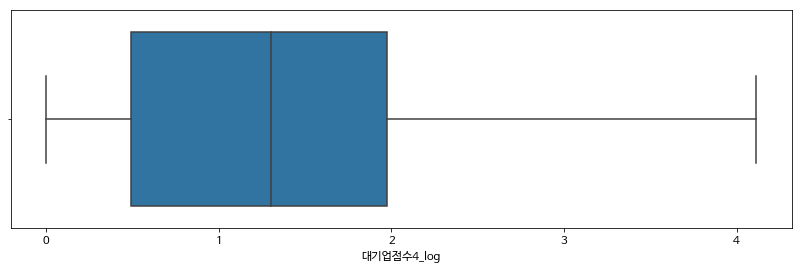

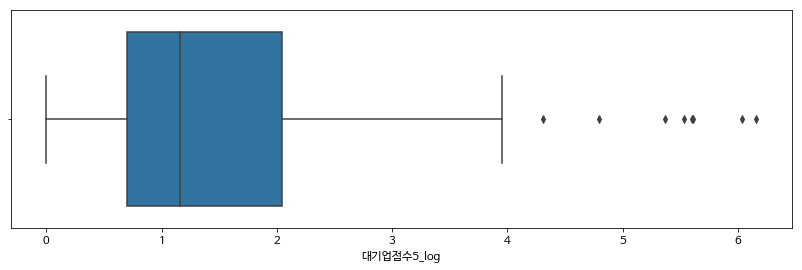

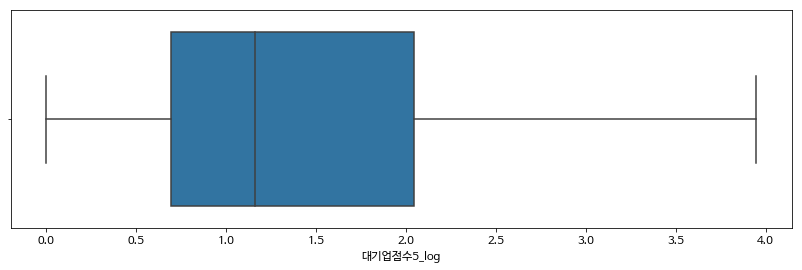

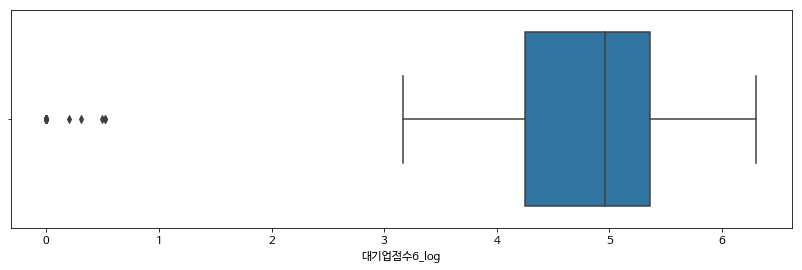

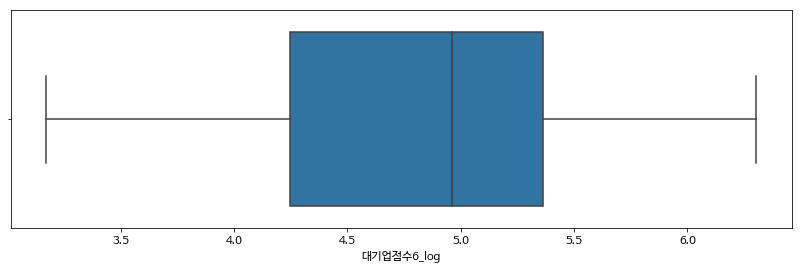

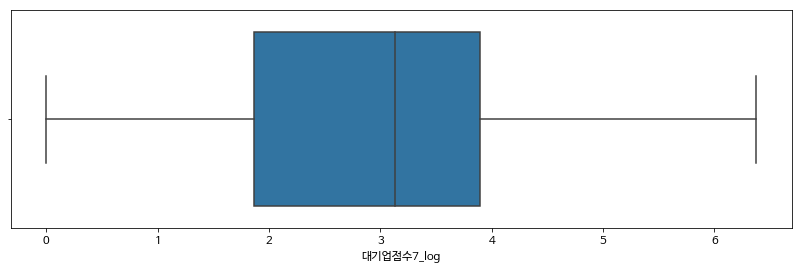

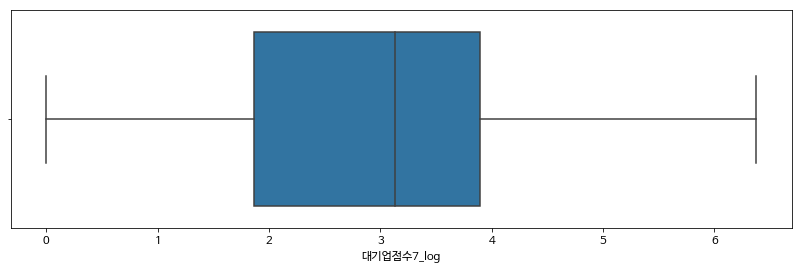

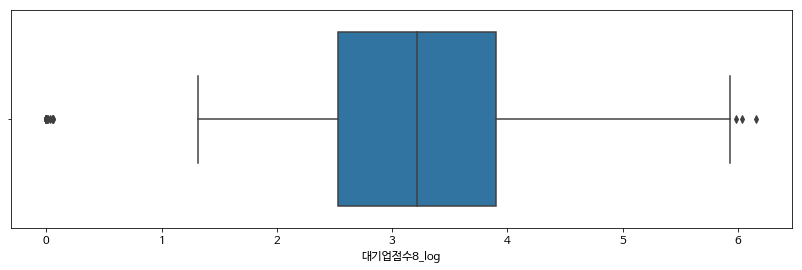

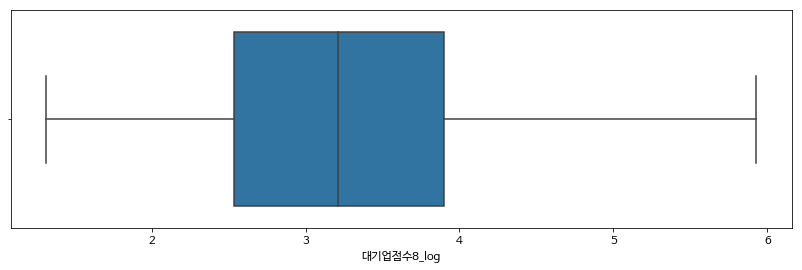

In [717]:
for i in range(1,9):
    col_name = f'대기업점수{i}'
    new_col_name = f'대기업점수{i}_log'
#     print(col_name, df[col_name])
    df[new_col_name] = df[col_name].map(lambda x:np.log(x*1000+1))
    temp_df[new_col_name] = df[col_name].map(lambda x:np.log(x*1000+1))
    temp_df = check_box_plot(df, temp_df, new_col_name)

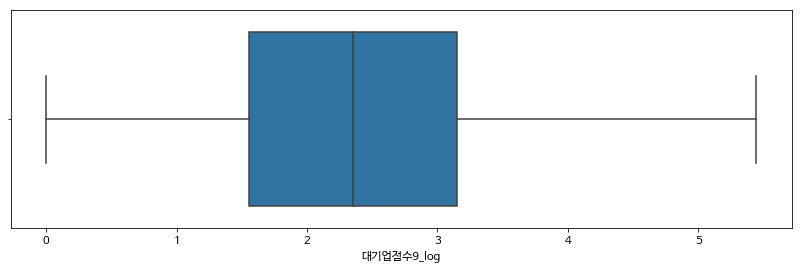

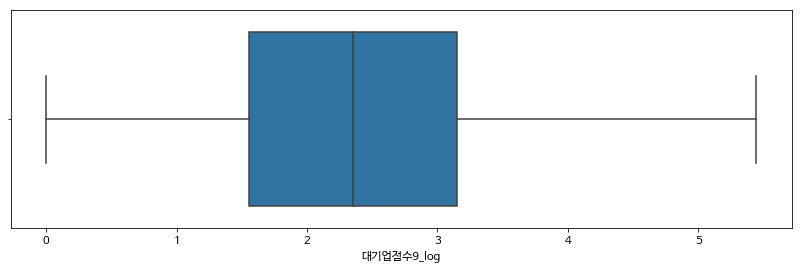

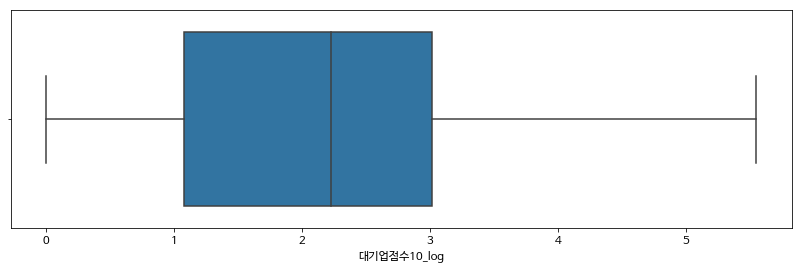

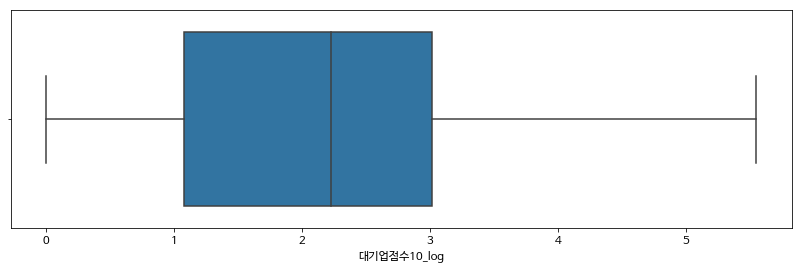

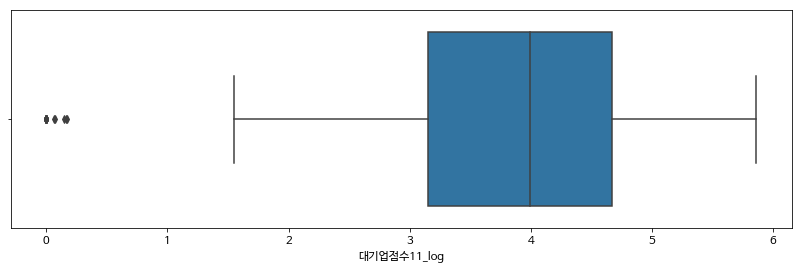

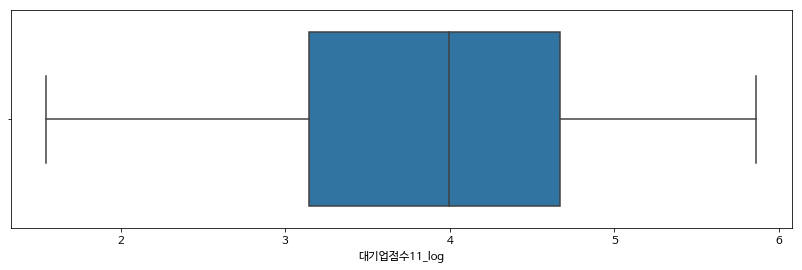

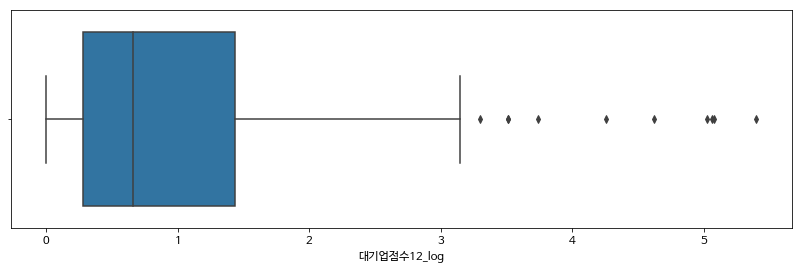

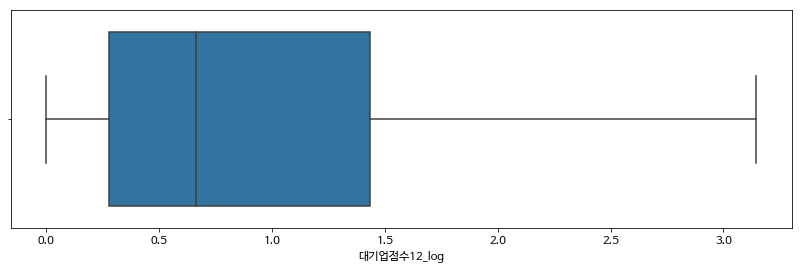

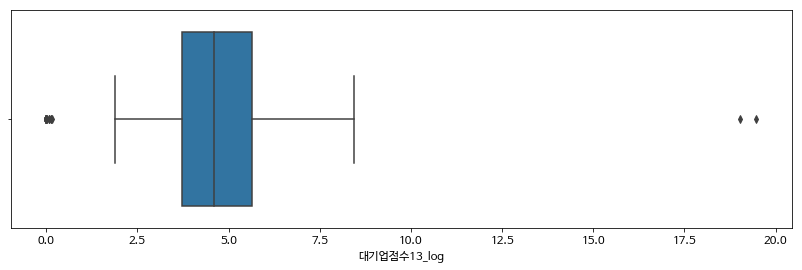

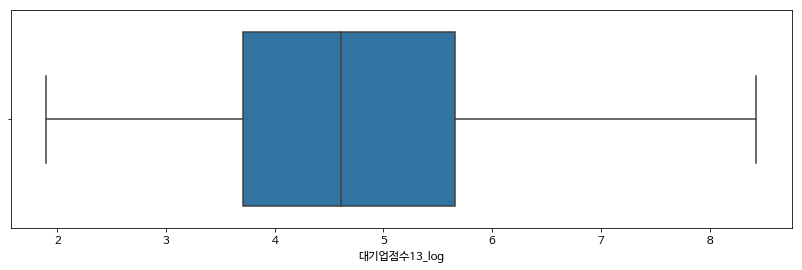

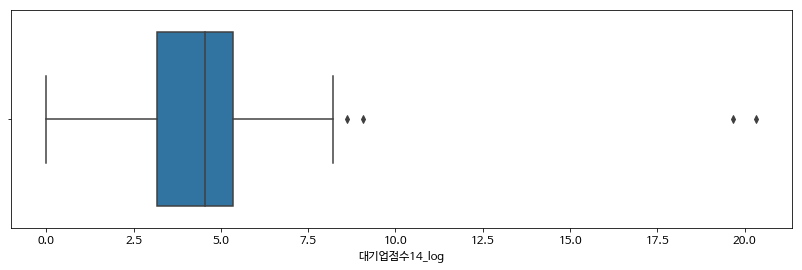

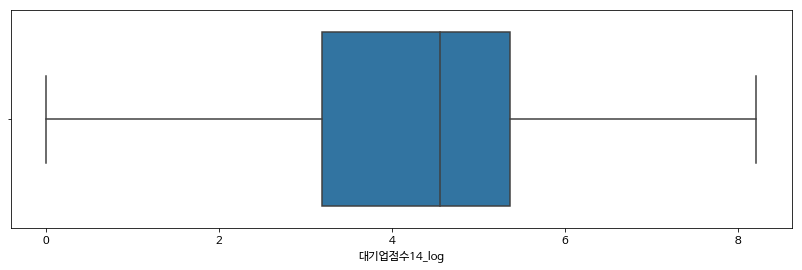

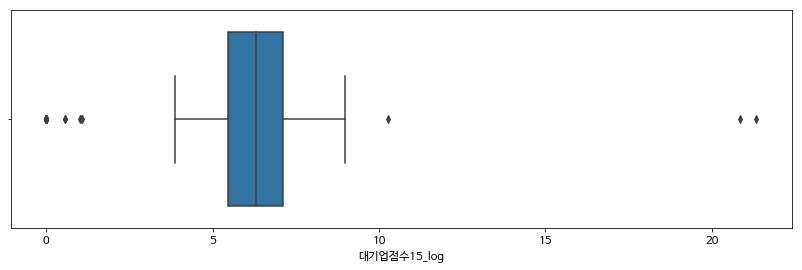

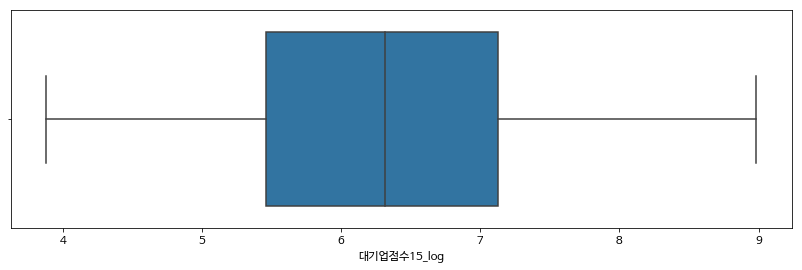

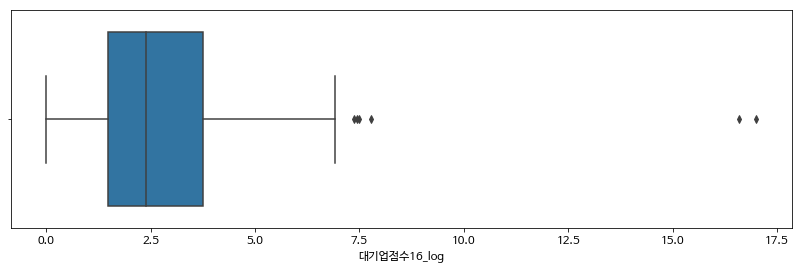

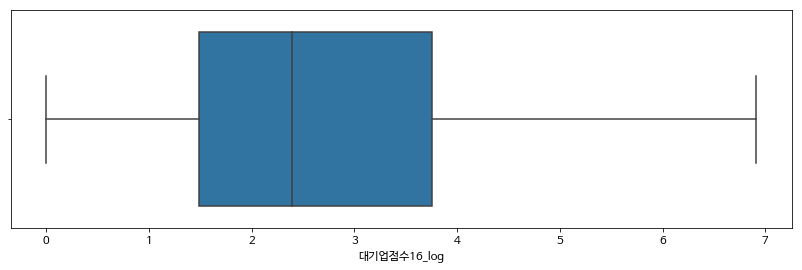

In [734]:
for i in range(9,17):
    col_name = f'대기업점수{i}'
    new_col_name = f'대기업점수{i}_log'
#     print(col_name, df[col_name])
    df[new_col_name] = df[col_name].map(lambda x:np.log(x*1000+1))
    temp_df[new_col_name] = df[col_name].map(lambda x:np.log(x*1000+1))
    temp_df = check_box_plot(df, temp_df, new_col_name)

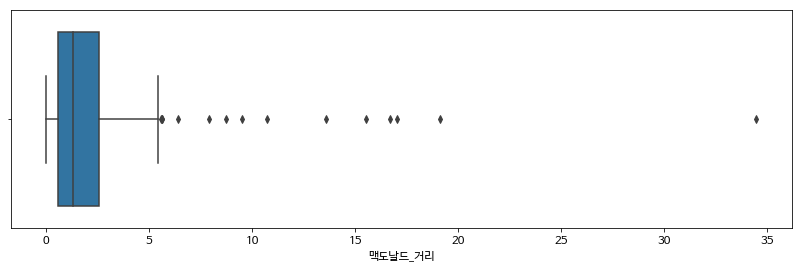

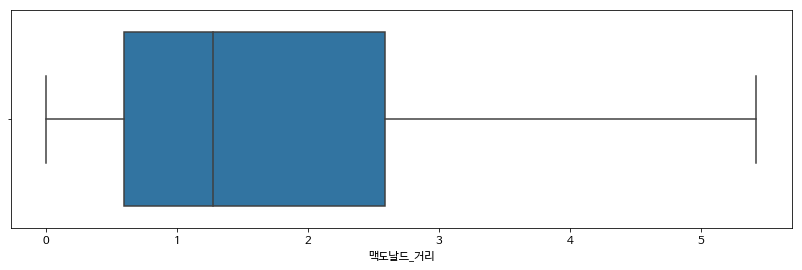

In [737]:
temp_df = check_box_plot(df, temp_df, '맥도날드_거리')

In [738]:
df['맥도날드_거리_log'] = df['맥도날드_거리'].map(lambda x:np.log(x+1))
temp_df['맥도날드_거리_log'] = df['맥도날드_거리'].map(lambda x:np.log(x+1))

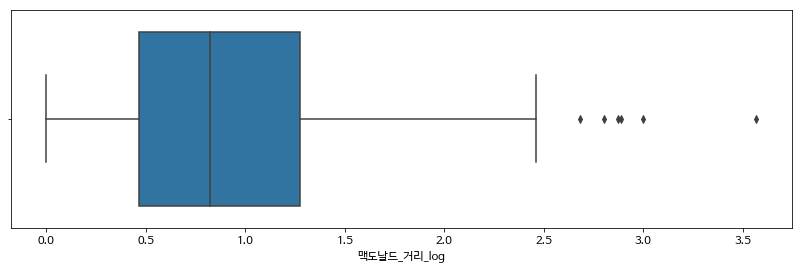

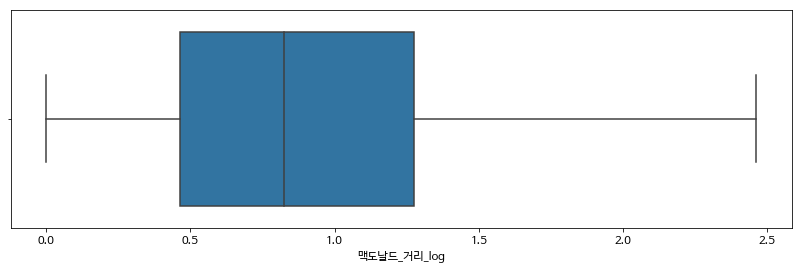

In [739]:
temp_df = check_box_plot(df, temp_df, '맥도날드_거리_log')

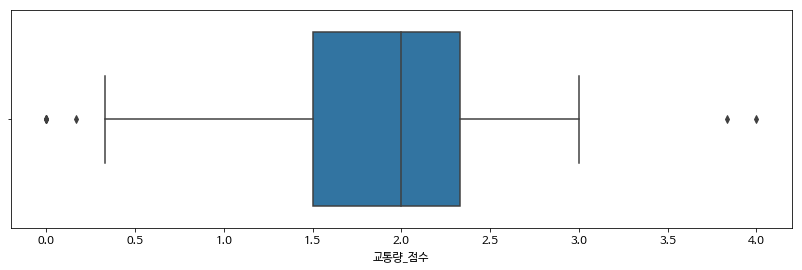

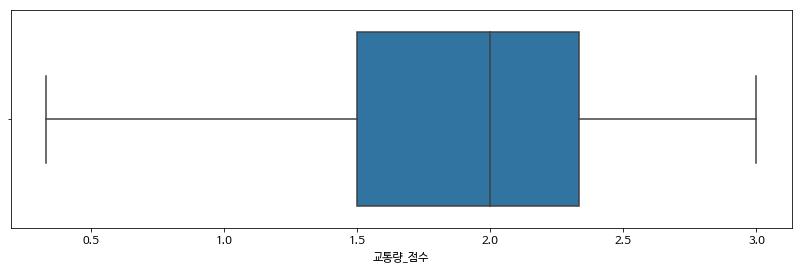

In [741]:
temp_df = check_box_plot(df, temp_df, '교통량_점수')

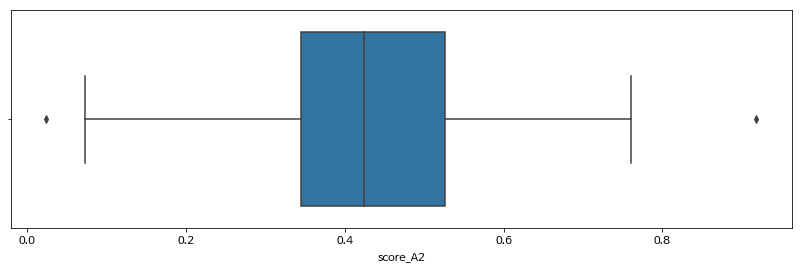

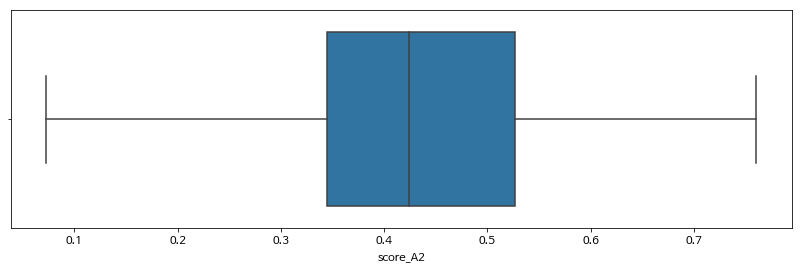

In [742]:
temp_df = check_box_plot(df, temp_df, 'score_A2')

In [744]:
temp_df.to_excel('../starbucksDT/postprocess/200717_feature_addeddata.xlsx', index=False)

In [783]:
traffic_info = pd.read_excel('/Users/dhkim/Downloads/Starbucks_DT_Traffics_postprocessed.xlsx')

In [785]:
traffic_info['평일점수'] = traffic_info.apply(lambda row:(row['score1'] + row['score2']+ row['score3'])/3.,axis=1)
traffic_info['주말점수'] = traffic_info.apply(lambda row:(row['score4'] + row['score5']+ row['score6'])/3.,axis=1)
traffic_info['아침점수'] = traffic_info.apply(lambda row:(row['score1'] + row['score4'])/2.,axis=1)
traffic_info['점심점수'] = traffic_info.apply(lambda row:(row['score2'] + row['score5'])/2.,axis=1)
traffic_info['저녁점수'] = traffic_info.apply(lambda row:(row['score3'] + row['score6'])/2.,axis=1)

In [792]:
for col in traffic_info.columns[-5:]:
    starbucks_feature_drop_smallreview[col] = 0
    starbucks_feature_smallreview[col] = 0

In [786]:
starbucks_feature_drop_smallreview = pd.read_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200713_최근지점제외_scoreA2_before_norm.xlsx')
starbucks_feature_smallreview = pd.read_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200713_최근지점만_scoreA2_before_norm.xlsx')

In [793]:

for idx, row in traffic_info.iterrows():
    if row['지점명'] in starbucks_feature_drop_smallreview['지점명'].values:
        for col in traffic_info.columns[-5:]:
            starbucks_feature_drop_smallreview.loc[starbucks_feature_drop_smallreview['지점명']==row['지점명'], col] = row[col]
    elif row['지점명'] in starbucks_feature_smallreview['지점명'].values:
        for col in traffic_info.columns[-5:]:
            starbucks_feature_smallreview.loc[starbucks_feature_smallreview['지점명']==row['지점명'], col] = row[col]

In [795]:
starbucks_feature_drop_smallreview = starbucks_feature_drop_smallreview.rename(columns={'평일점수':'교통량 점수 평일',
                                                                                       '주말점수':'교통량 점수 주말',
                                                                                       '아침점수':'교통량 점수 아침',
                                                                                       '점심점수':'교통량 점수 점심',
                                                                                       '저녁점수':'교통량 점수 저녁'})
starbucks_feature_smallreview = starbucks_feature_smallreview.rename(columns={'평일점수':'교통량 점수 평일',
                                                                                       '주말점수':'교통량 점수 주말',
                                                                                       '아침점수':'교통량 점수 아침',
                                                                                       '점심점수':'교통량 점수 점심',
                                                                                       '저녁점수':'교통량 점수 저녁'})

In [799]:
df = df.sort_values('지점명').reset_index(drop=True)
temp_df = temp_df.sort_values('지점명').reset_index(drop=True)

In [807]:
'_'.join('교통량 점수 평일'.split(' '))

'교통량_점수_평일'

In [800]:
starbucks_feature_drop_smallreview = starbucks_feature_drop_smallreview.sort_values('지점명').reset_index(drop=True)

In [809]:
for col in starbucks_feature_drop_smallreview.columns[-5:]:
    new_col = '_'.join(col.split(' '))
    df[new_col] = starbucks_feature_drop_smallreview[col]
    temp_df[new_col] = starbucks_feature_drop_smallreview[col]

In [797]:
#starbucks_feature_drop_smallreview.to_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200717_최근지점제외_scoreA2_before_norm_교통량추가.xlsx', index=False)
#starbucks_feature_smallreview.to_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200717_최근지점만_scoreA2_before_norm_교통량추가.xlsx', index=False)

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


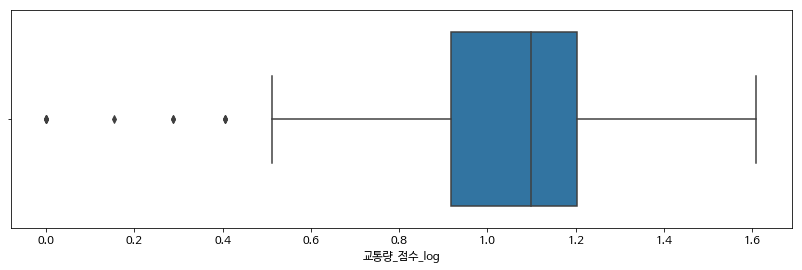

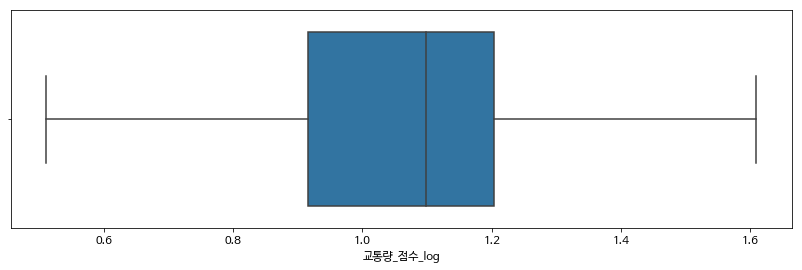

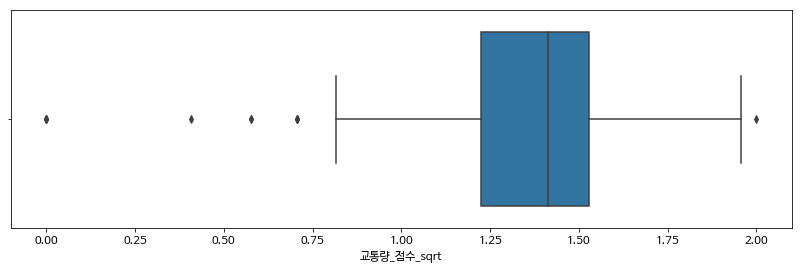

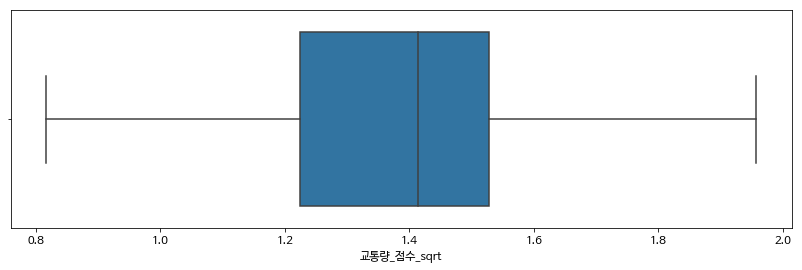

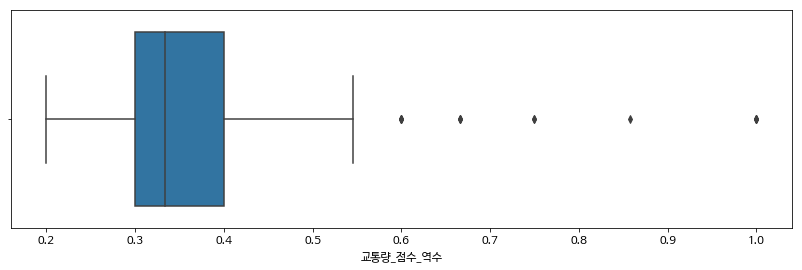

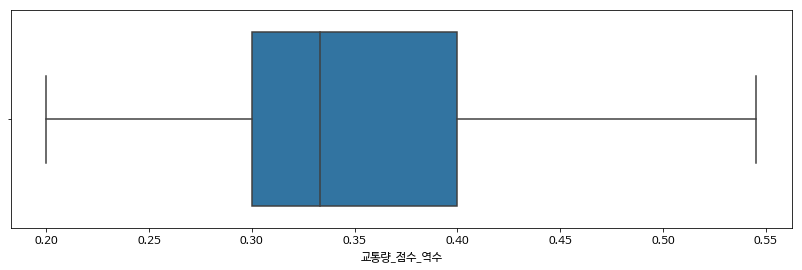

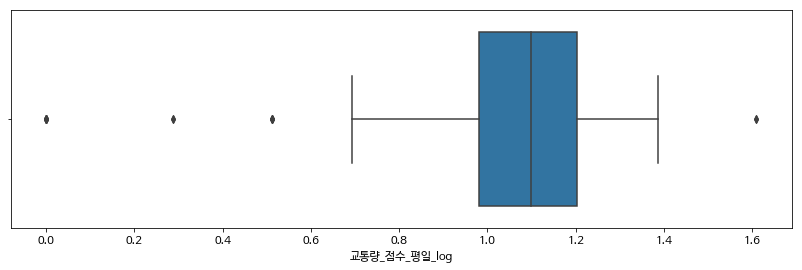

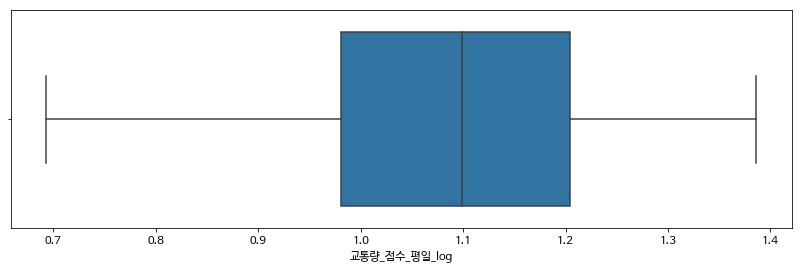

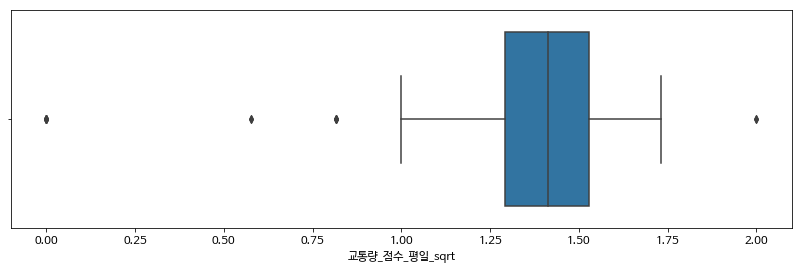

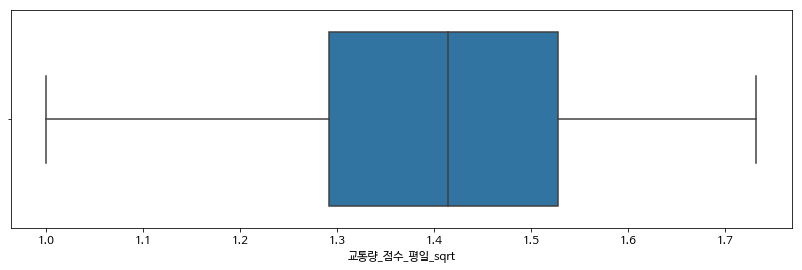

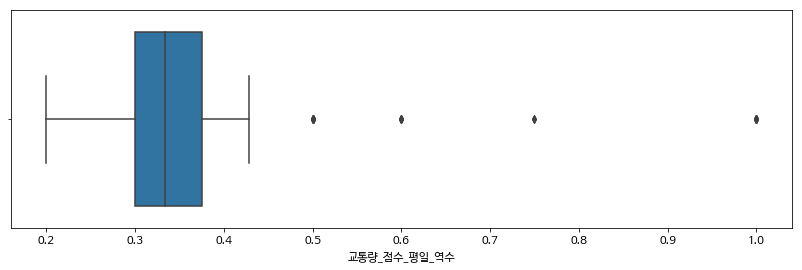

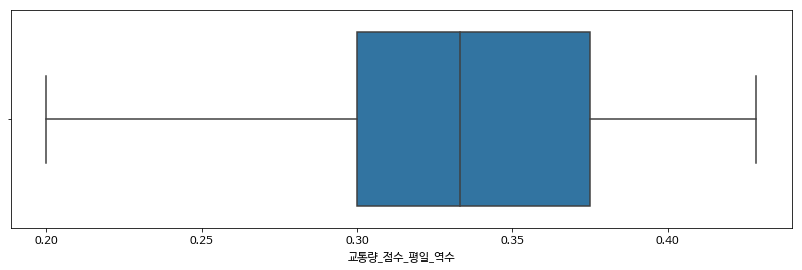

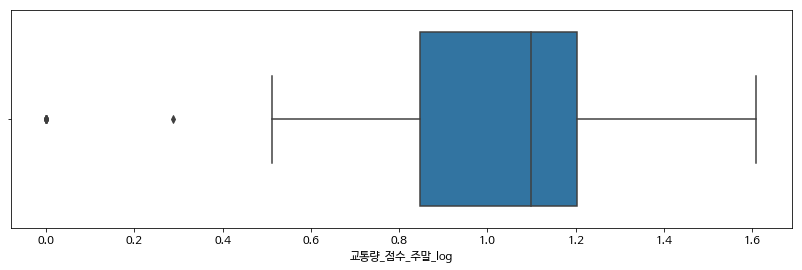

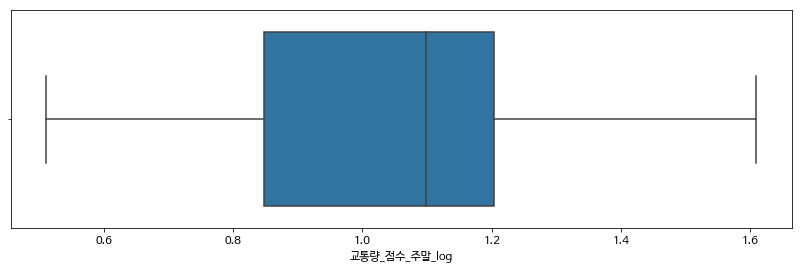

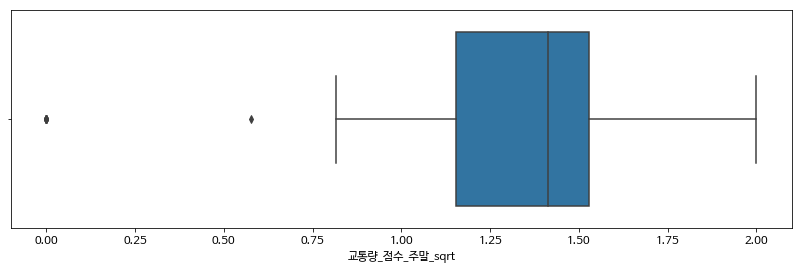

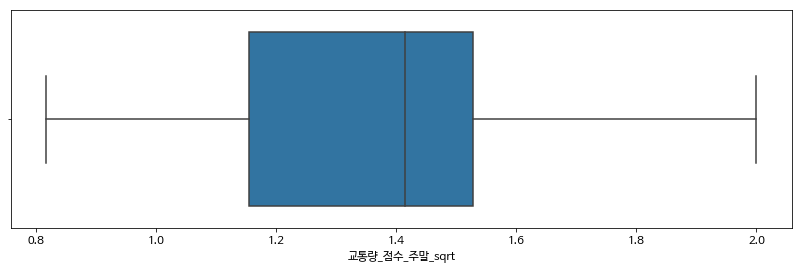

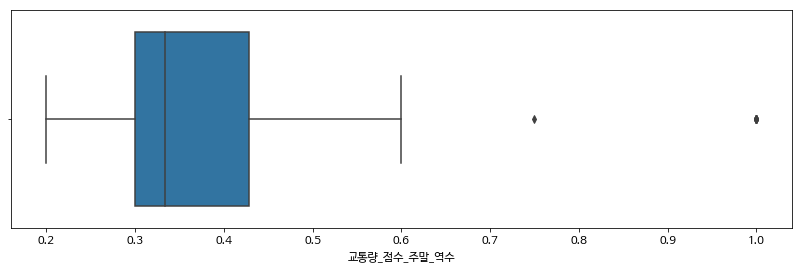

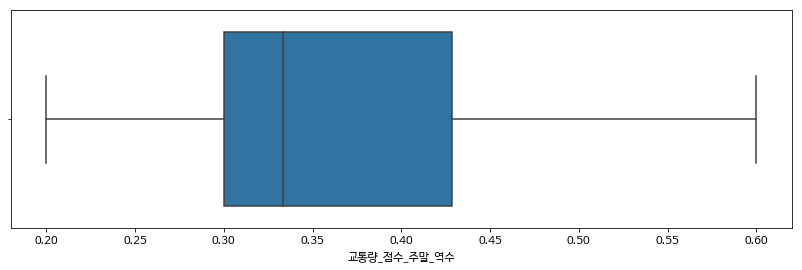

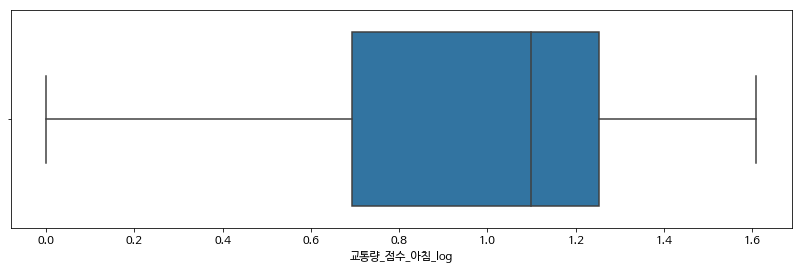

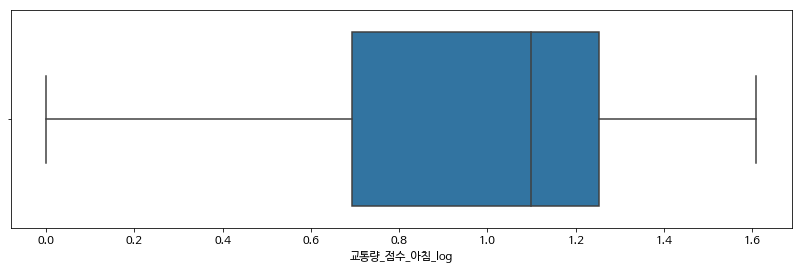

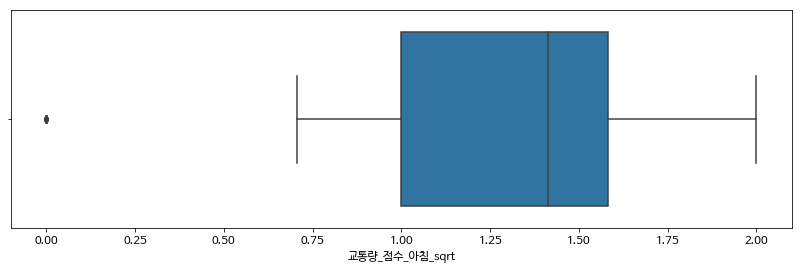

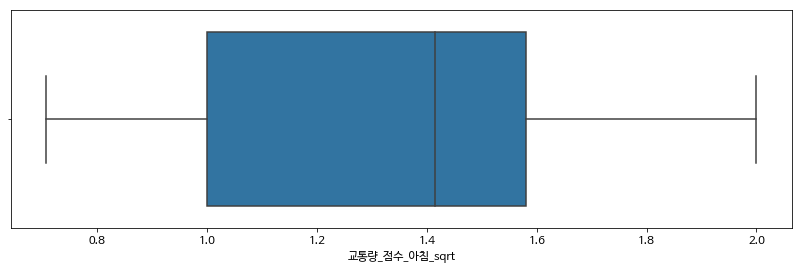

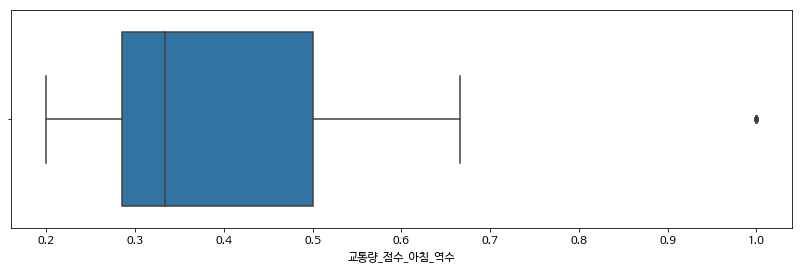

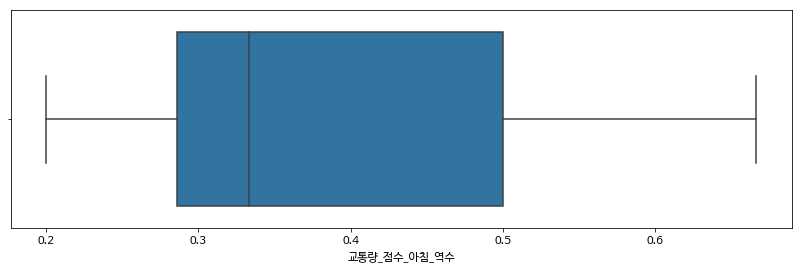

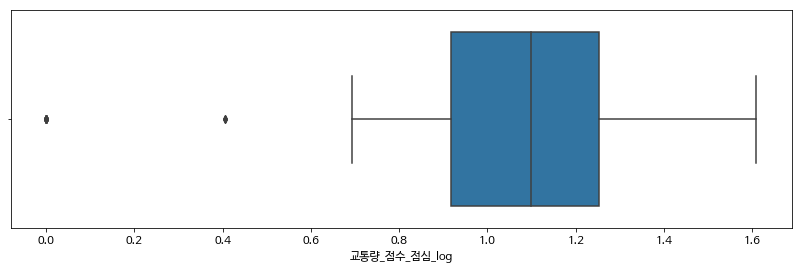

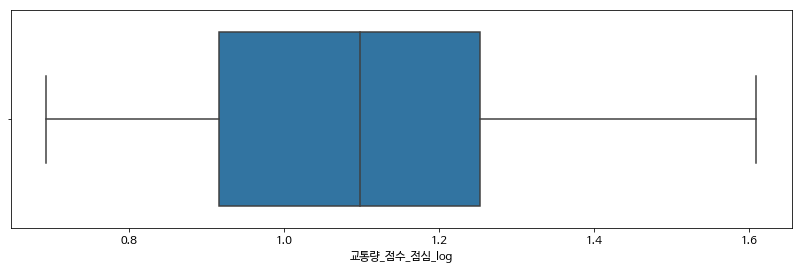

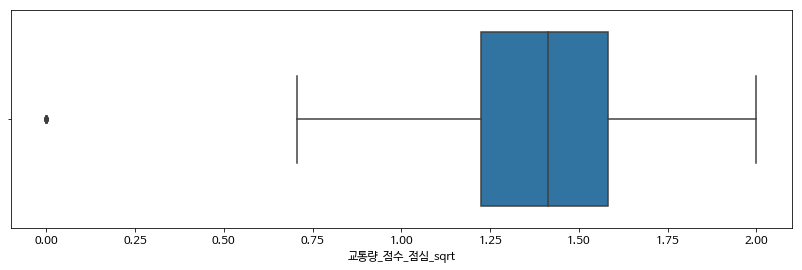

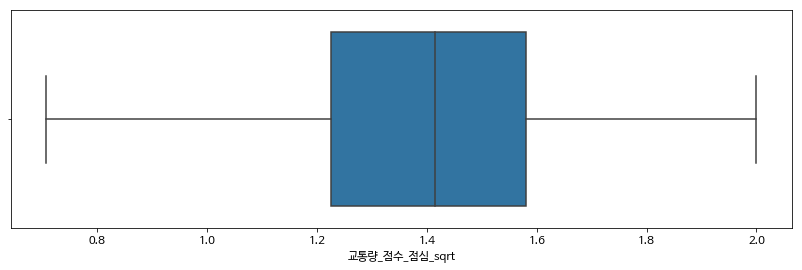

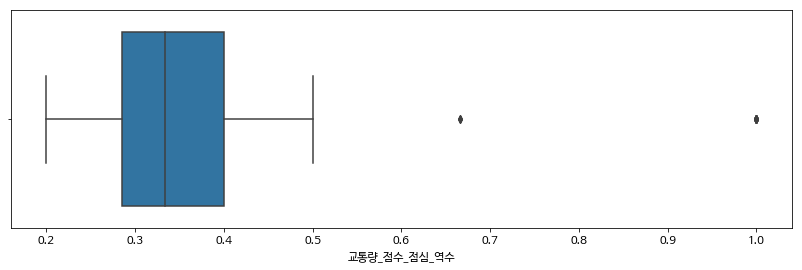

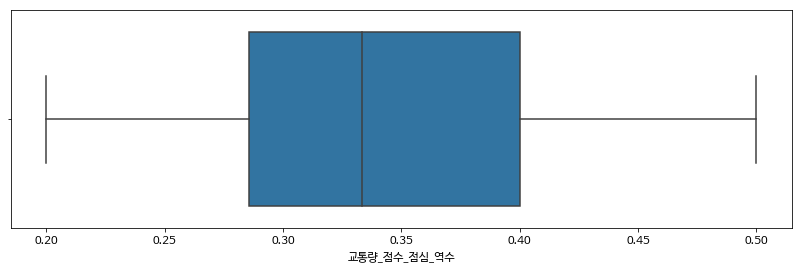

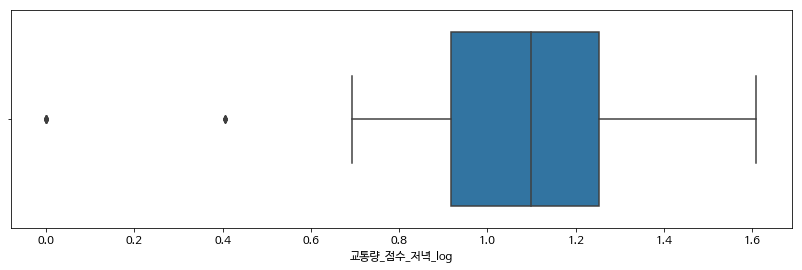

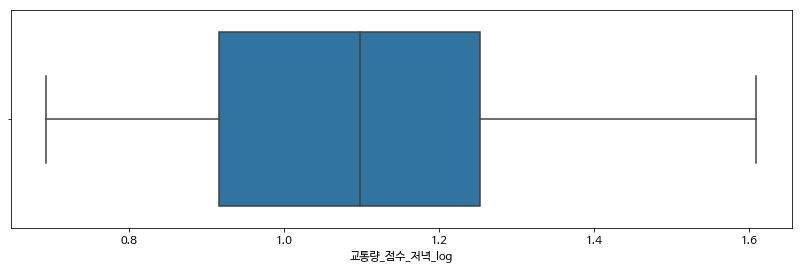

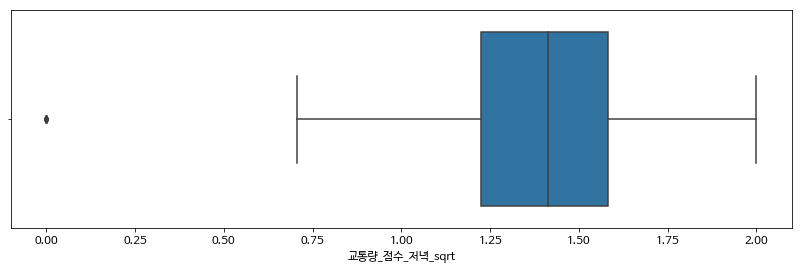

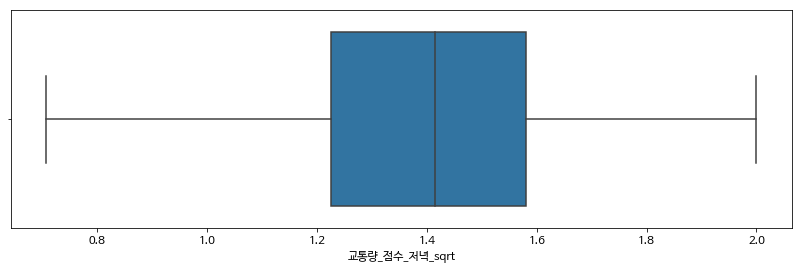

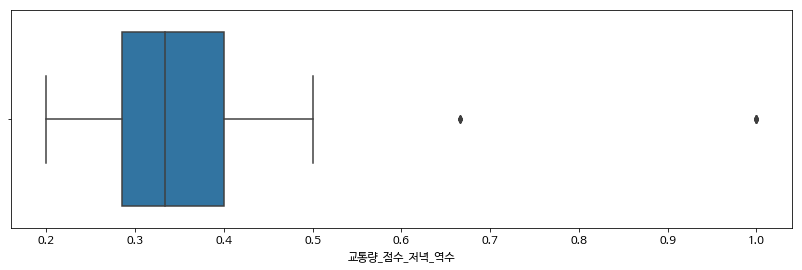

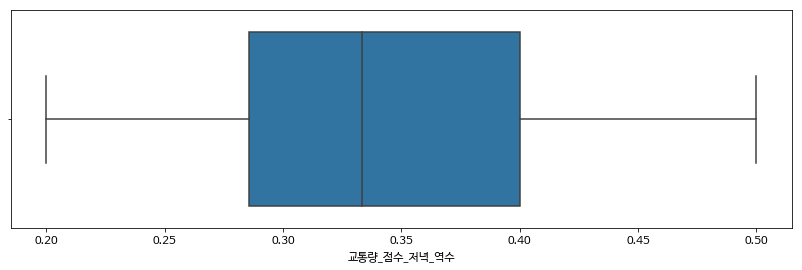

In [857]:
for col in ['교통량_점수'] + list(df.columns[-5:]):
    new_col_log = col+'_log'
    df[new_col_log] = df[col].map(lambda x:np.log(1+x))
    temp_df[new_col_log] = df[col].map(lambda x:np.log(1+x))
    temp_df = check_box_plot(df, temp_df, new_col_log)
    
    new_col_sqrt = col+'_sqrt'
    df[new_col_sqrt] = df[col].map(lambda x:np.sqrt(x))
    temp_df[new_col_sqrt] = df[col].map(lambda x:np.sqrt(x))
    temp_df = check_box_plot(df, temp_df, new_col_sqrt)
    
    new_col_reverse = col+'_역수'
    df[new_col_reverse] = df[col].map(lambda x:1/(x+1))
    temp_df[new_col_reverse] = df[col].map(lambda x:1/(1+x))
    temp_df = check_box_plot(df, temp_df, new_col_reverse)

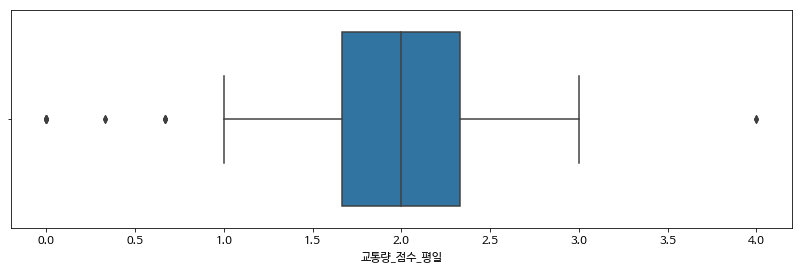

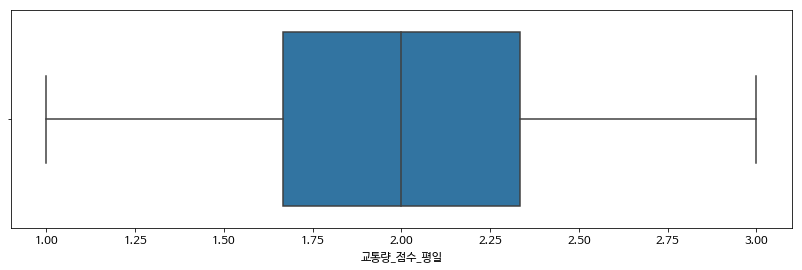

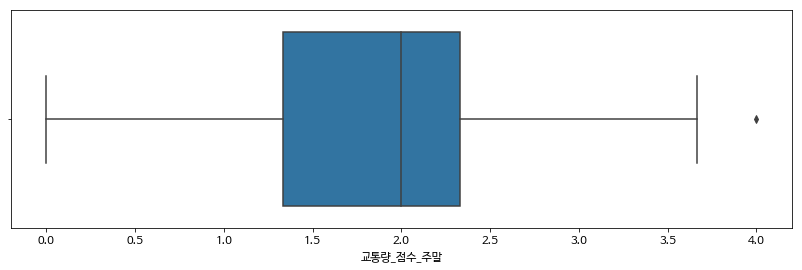

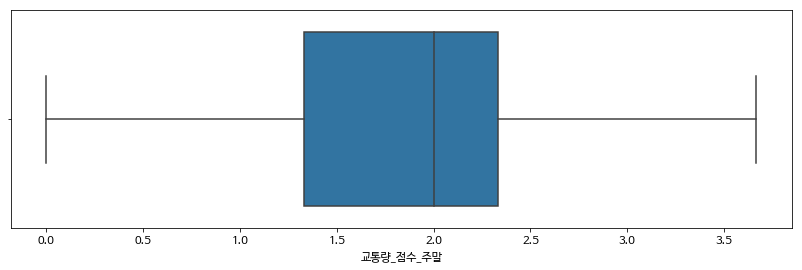

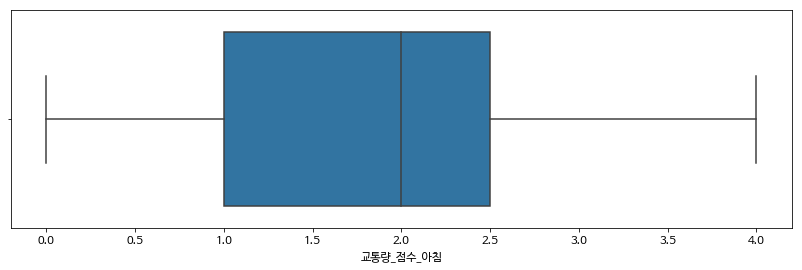

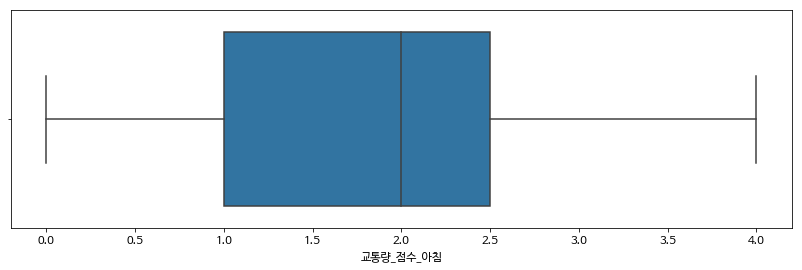

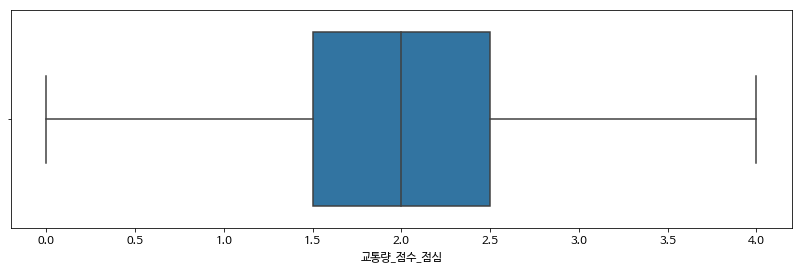

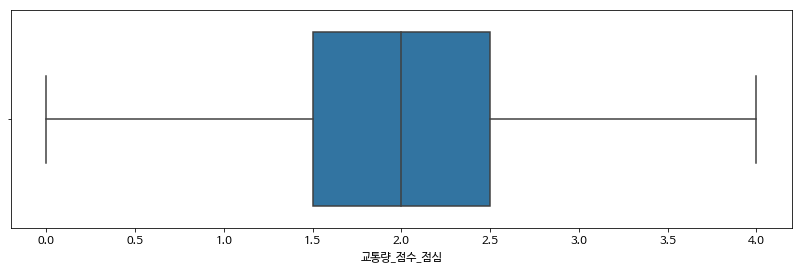

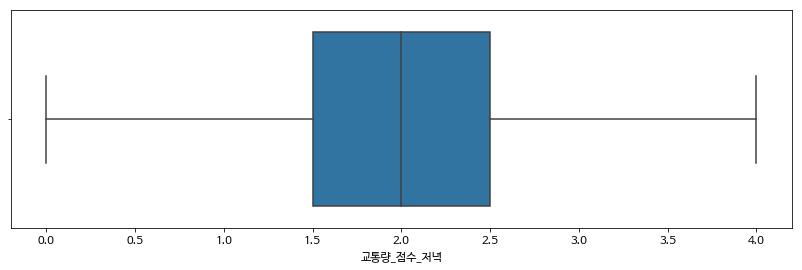

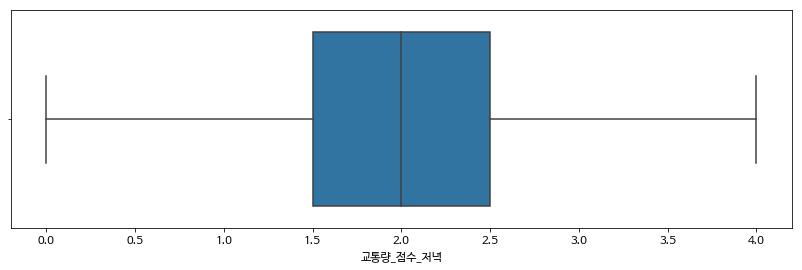

In [812]:
for col in df.columns[-5:]:
    temp_df = check_box_plot(df, temp_df, col)

In [746]:
import xai

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


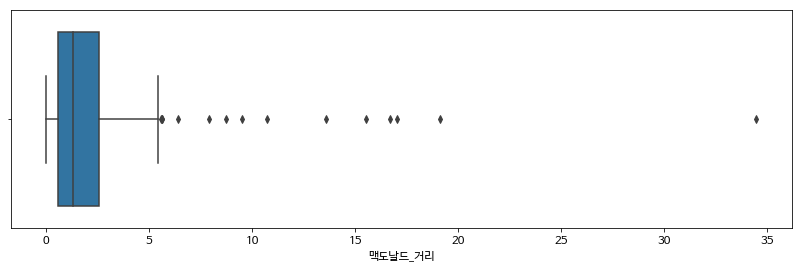

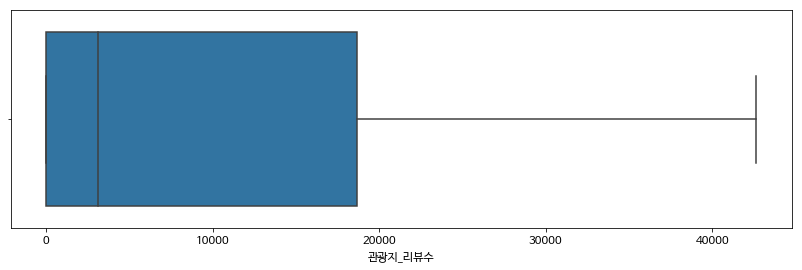

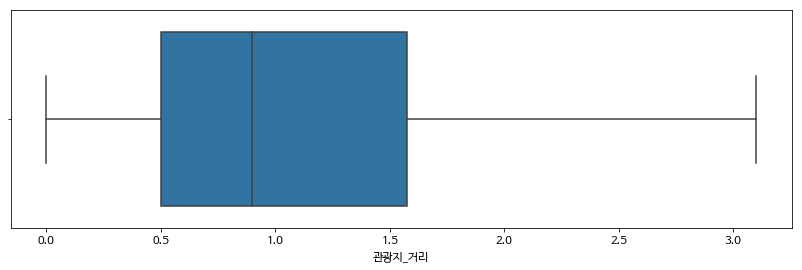

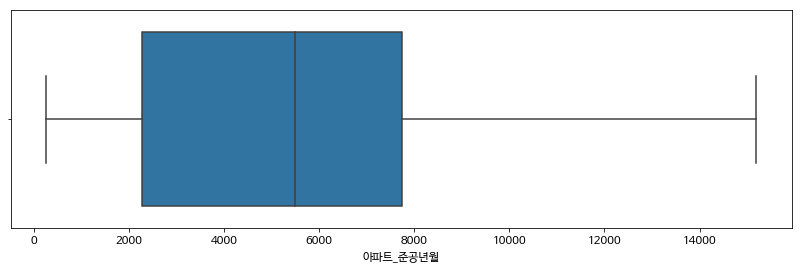

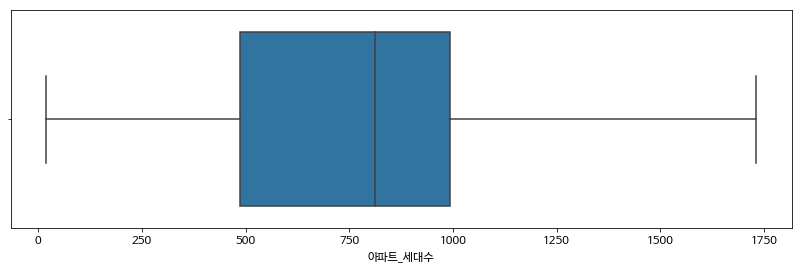

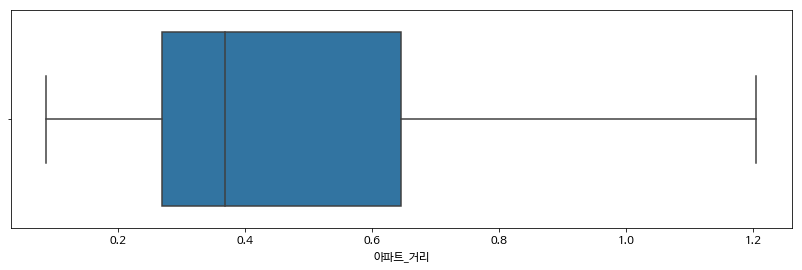

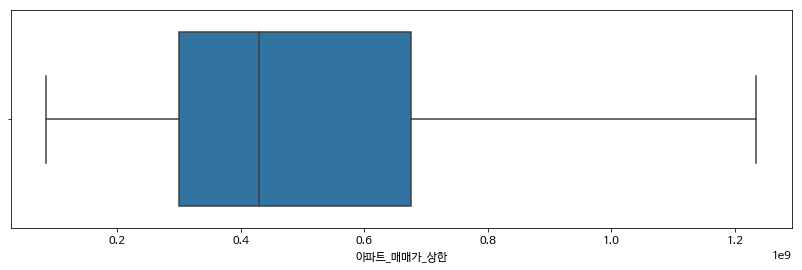

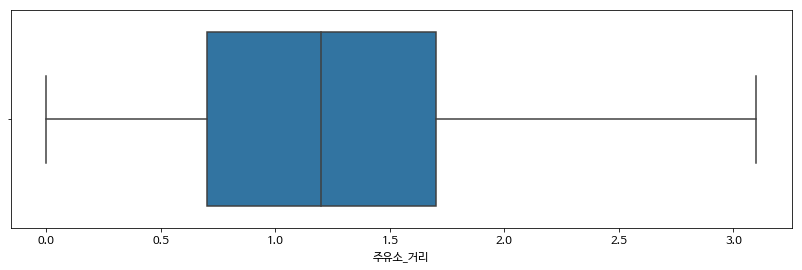

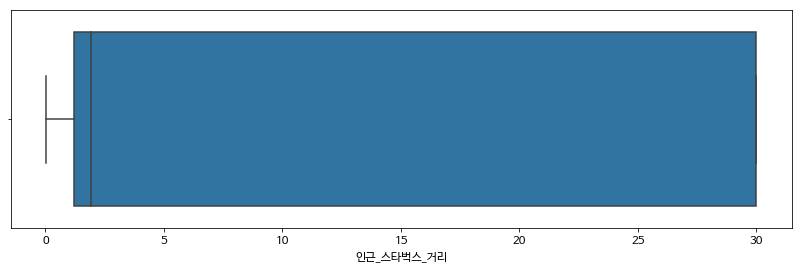

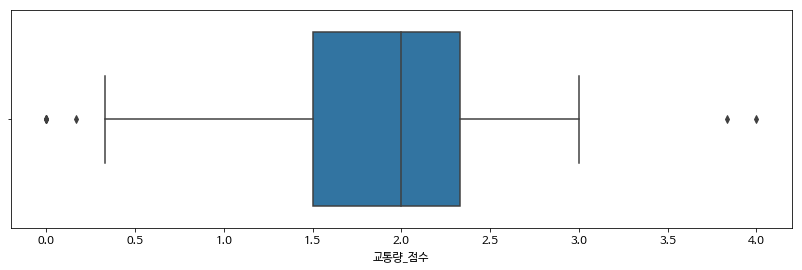

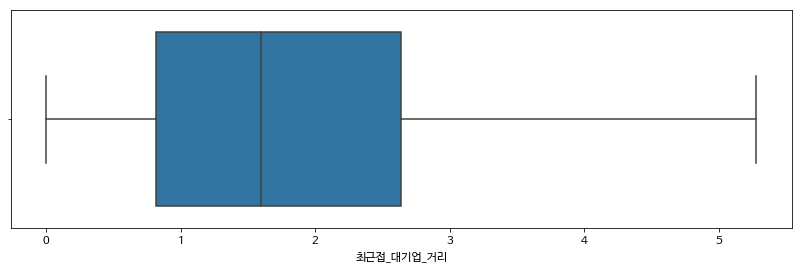

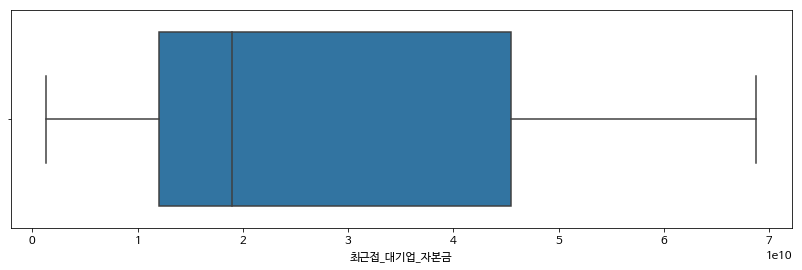

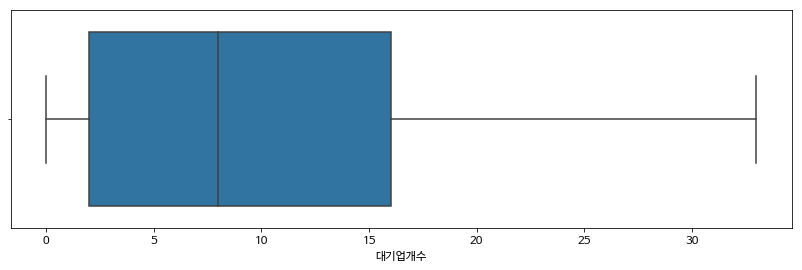

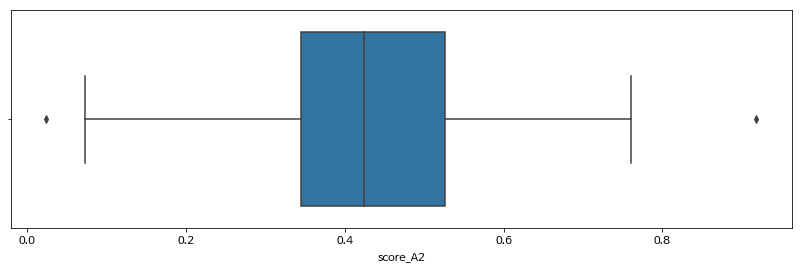

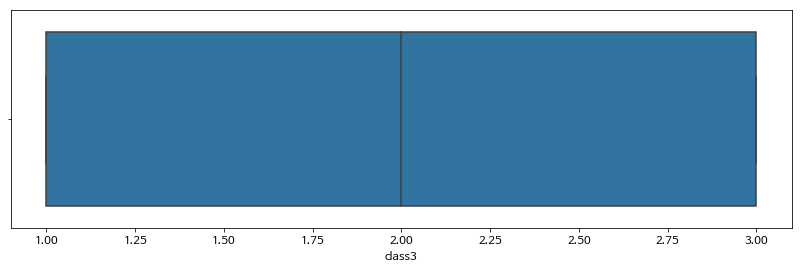

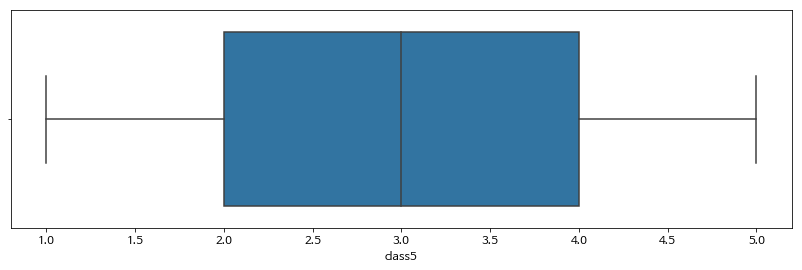

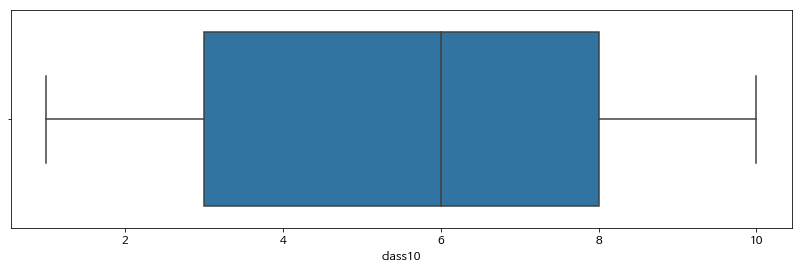

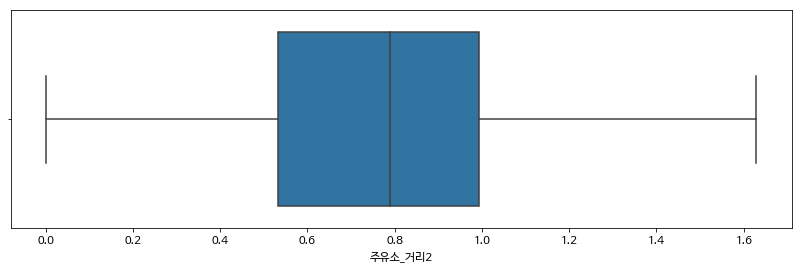

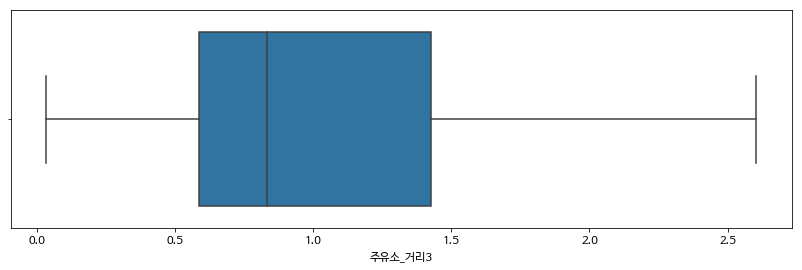

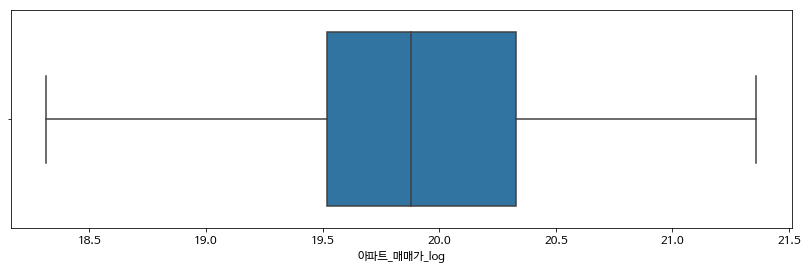

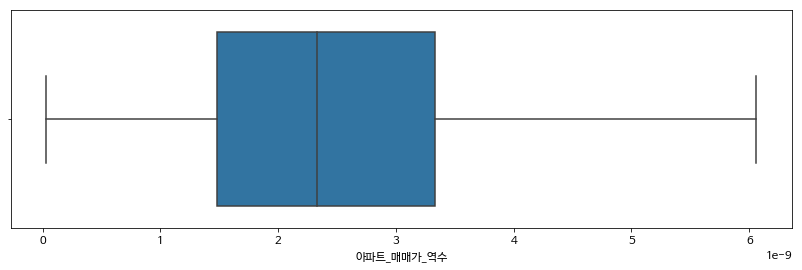

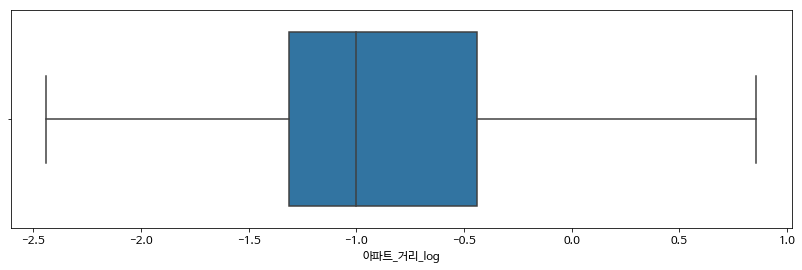

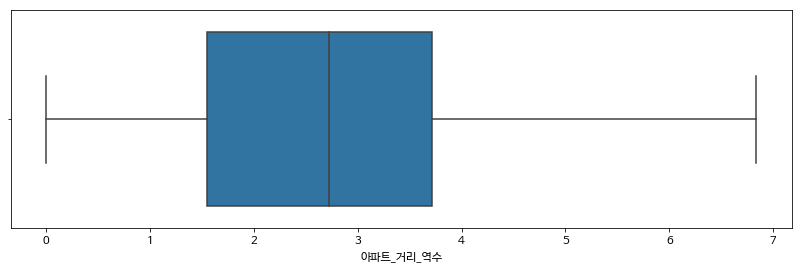

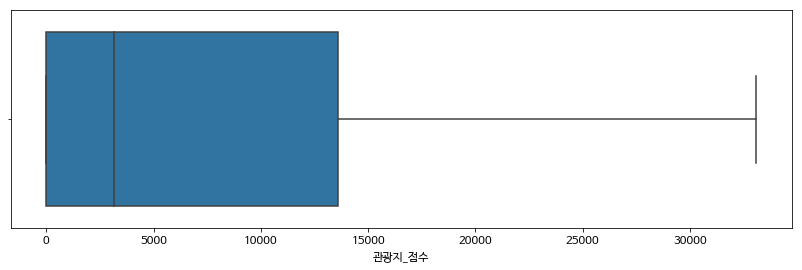

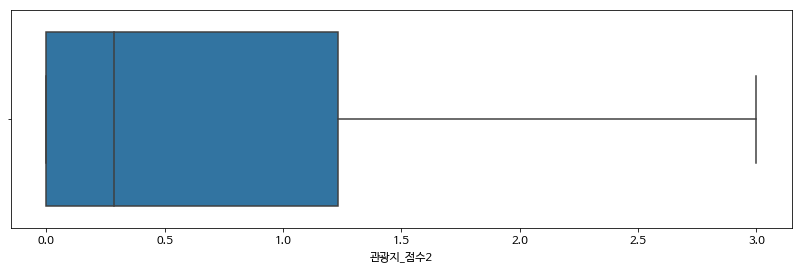

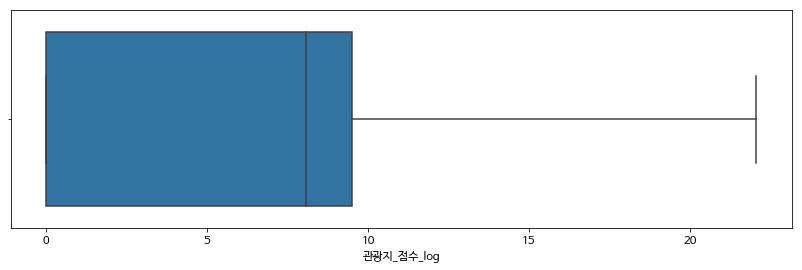

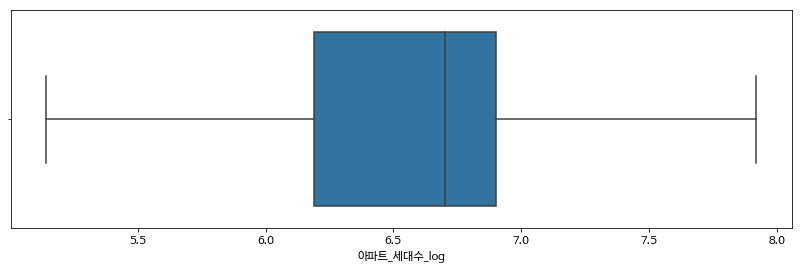

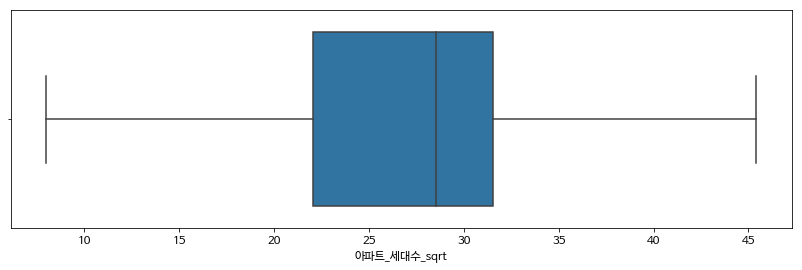

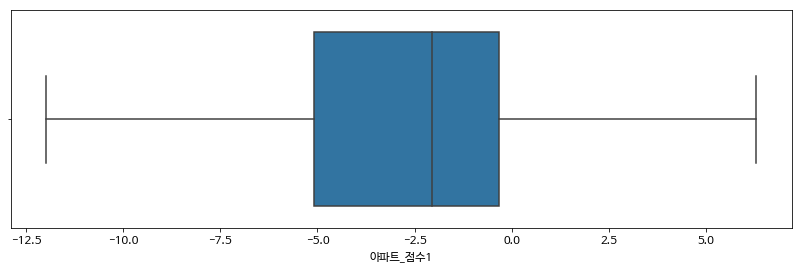

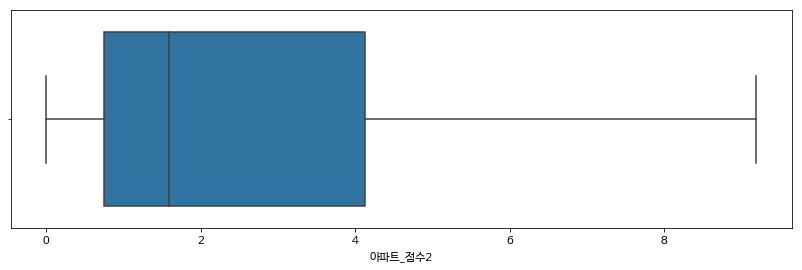

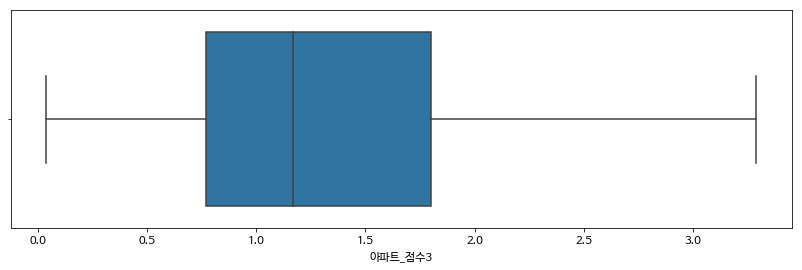

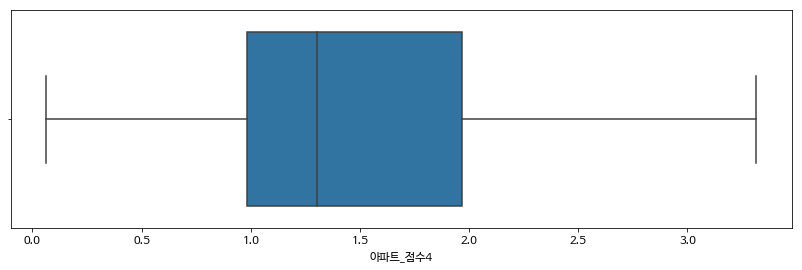

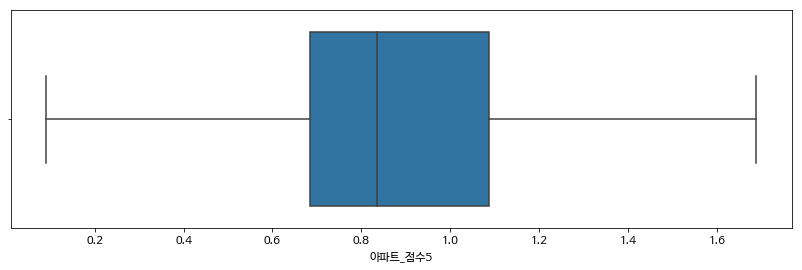

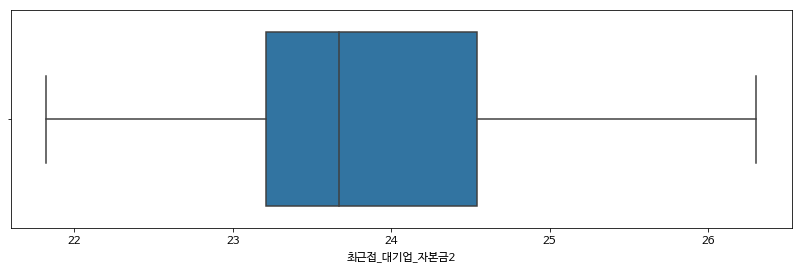

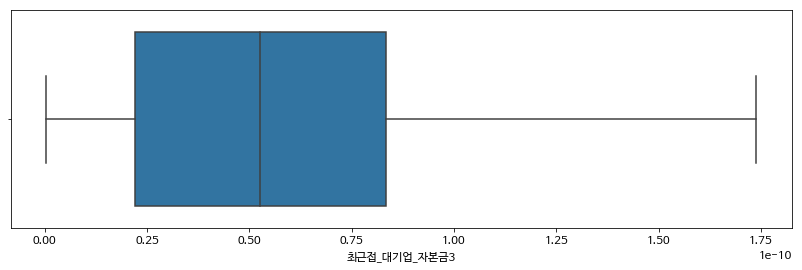

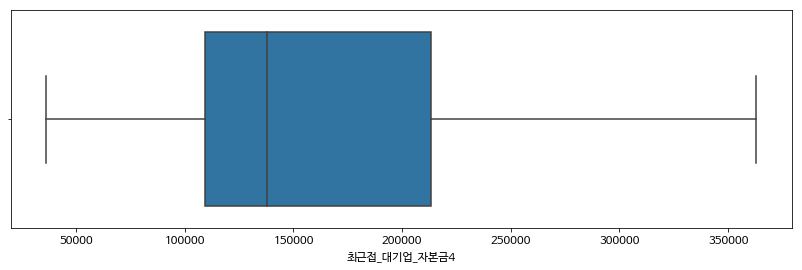

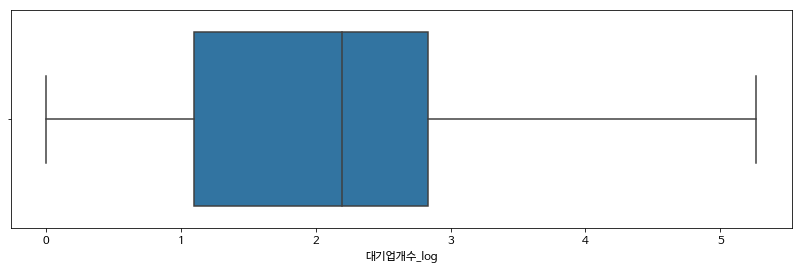

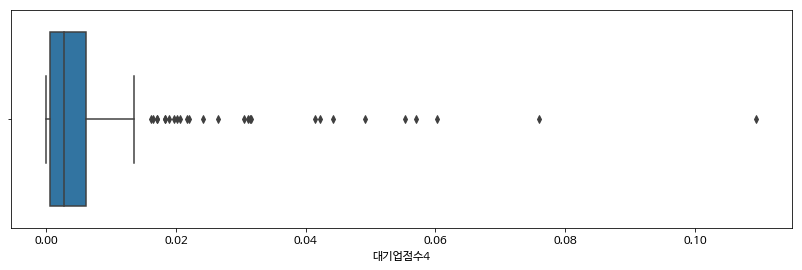

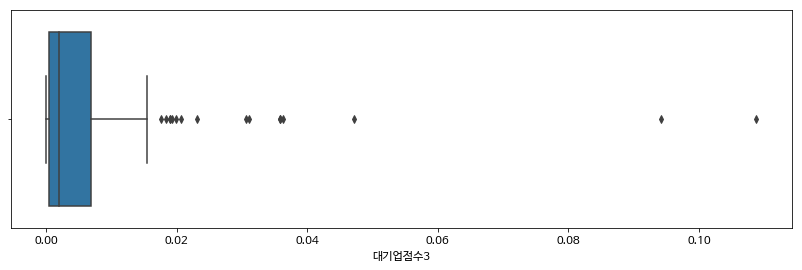

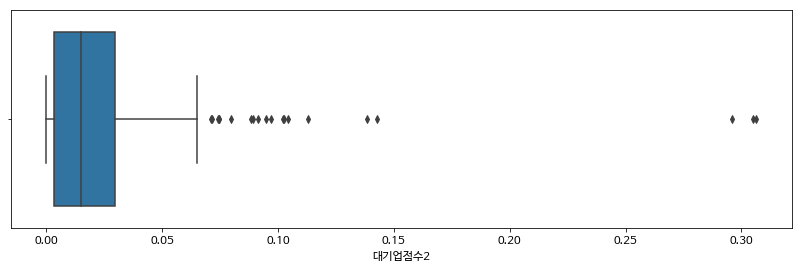

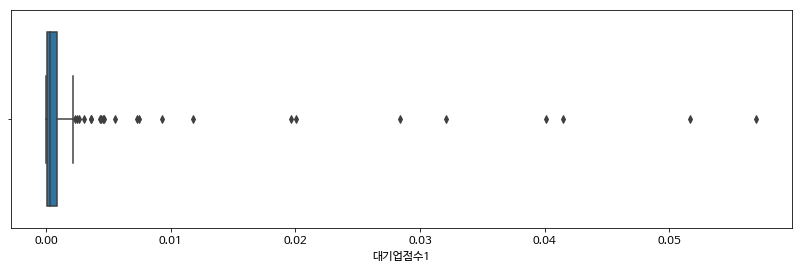

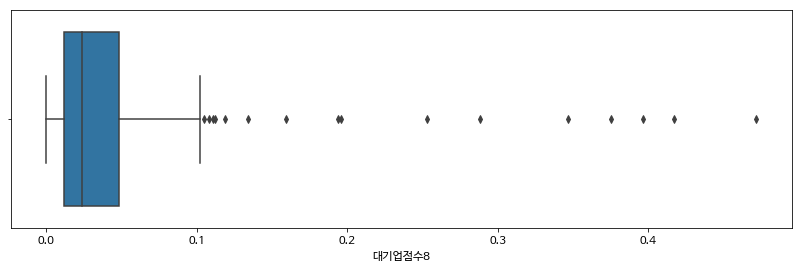

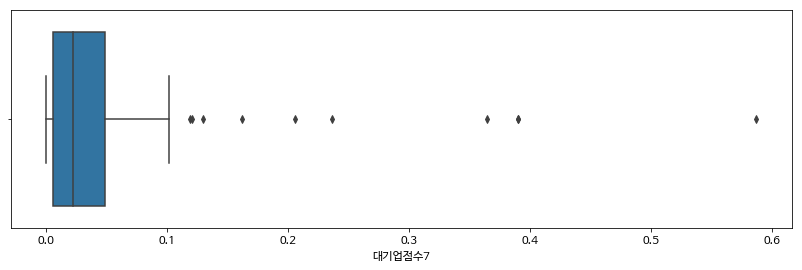

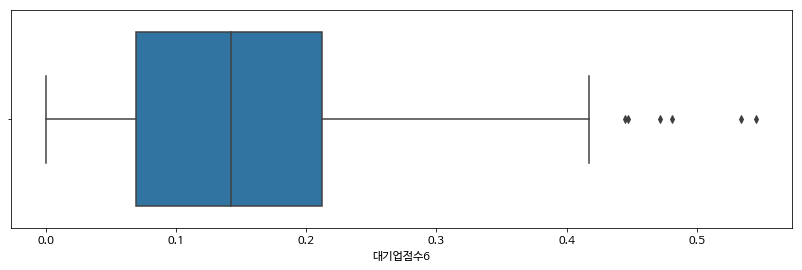

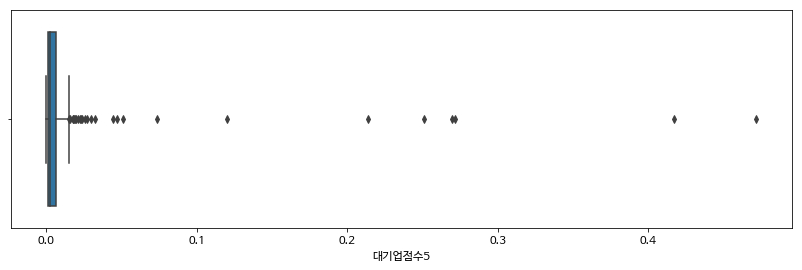

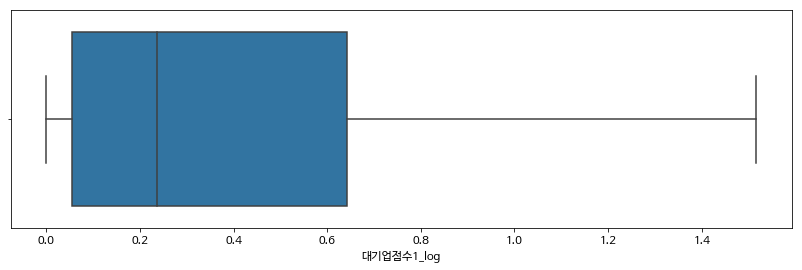

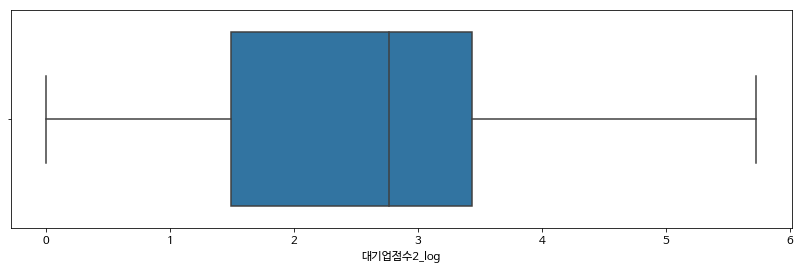

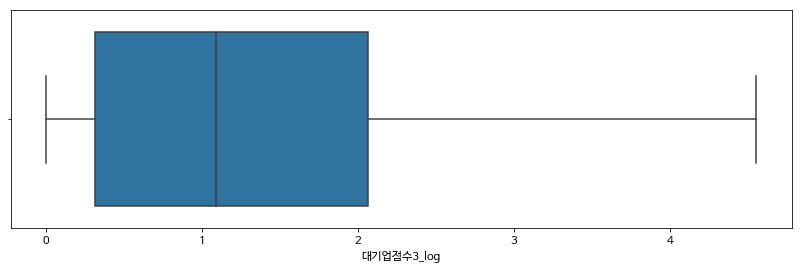

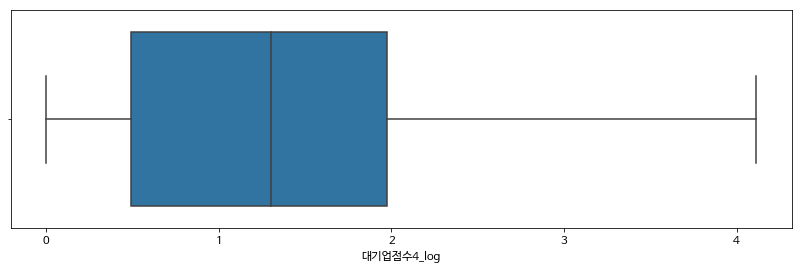

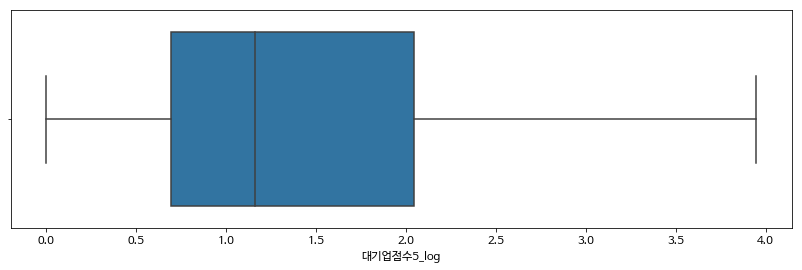

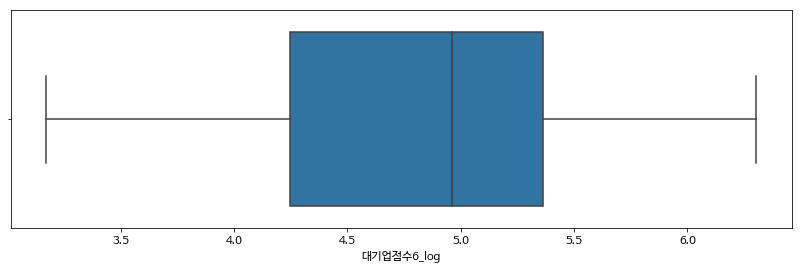

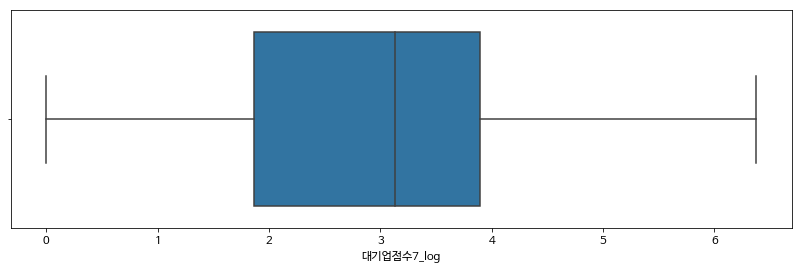

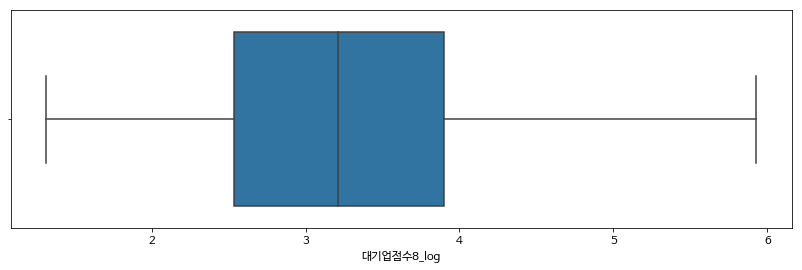

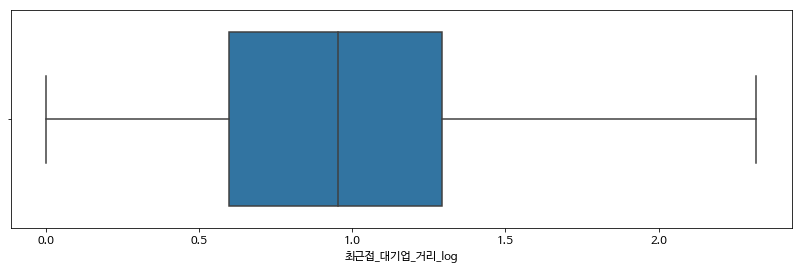

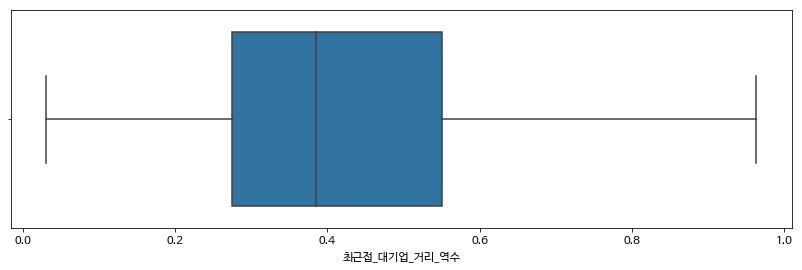

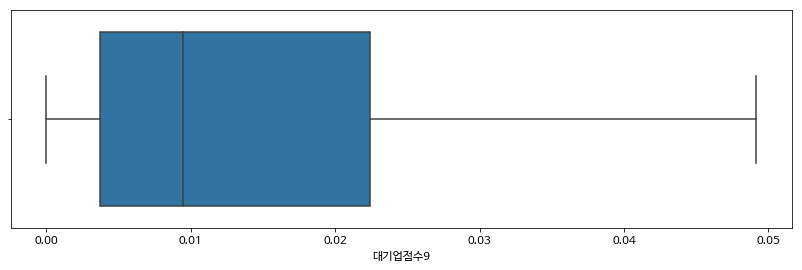

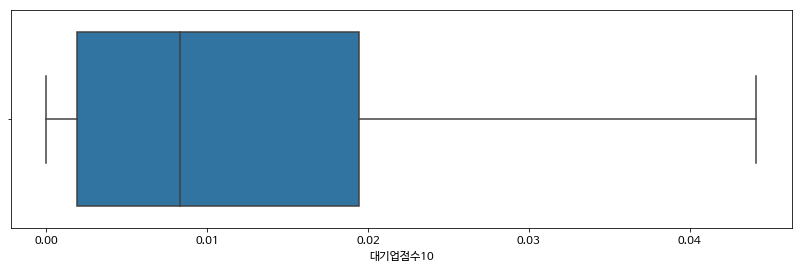

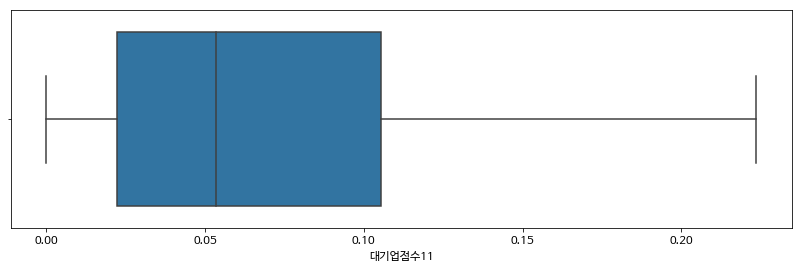

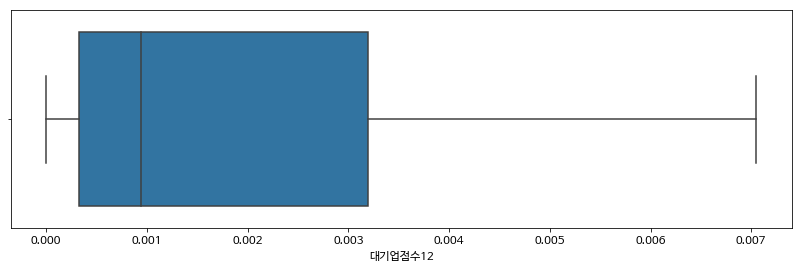

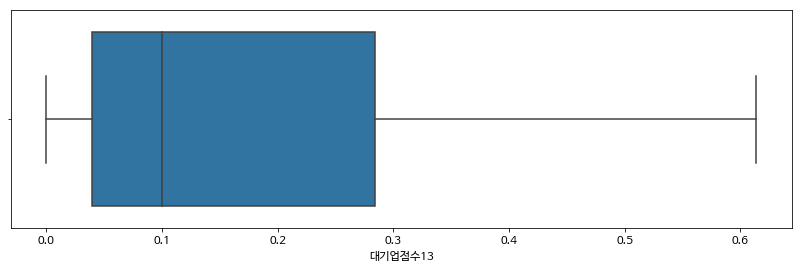

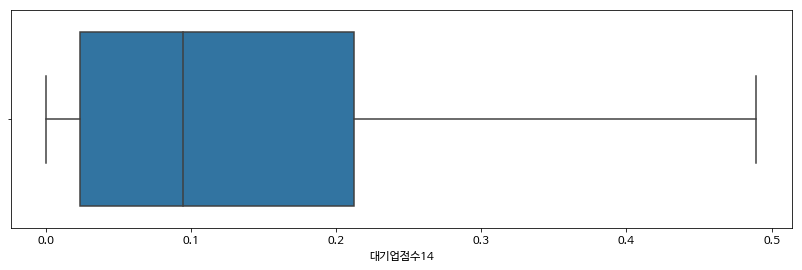

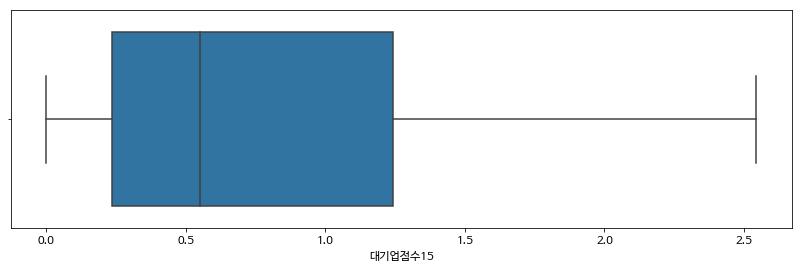

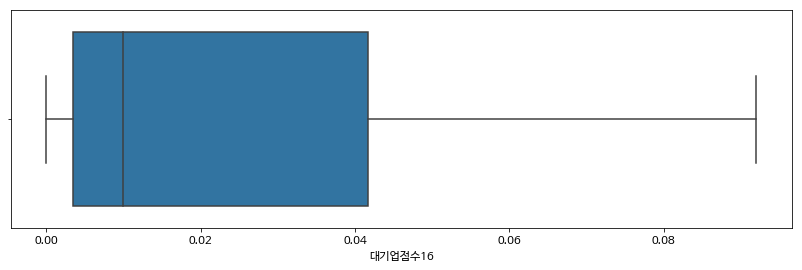

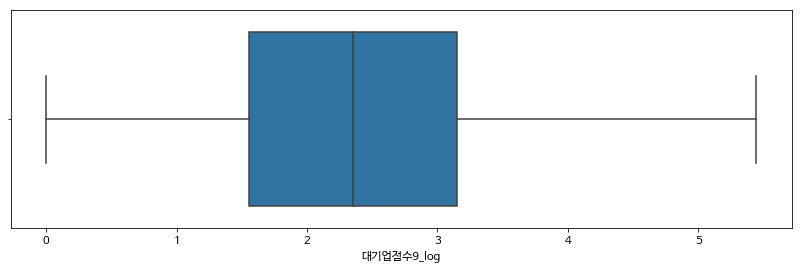

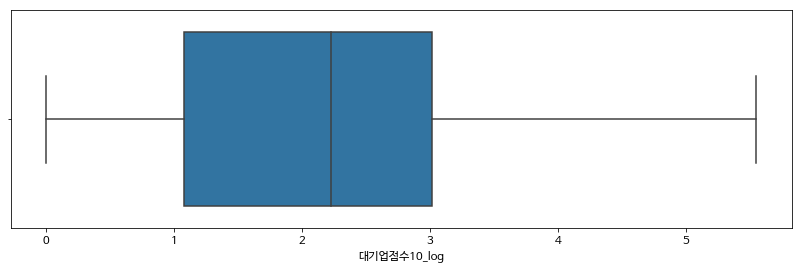

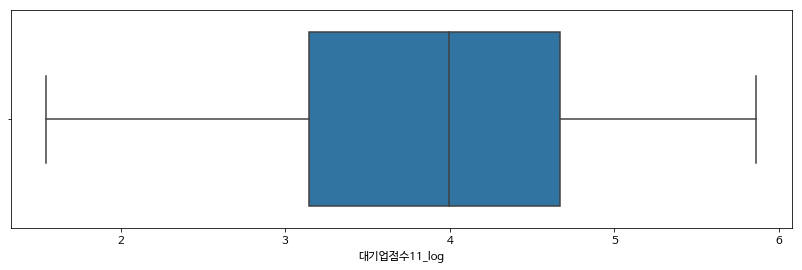

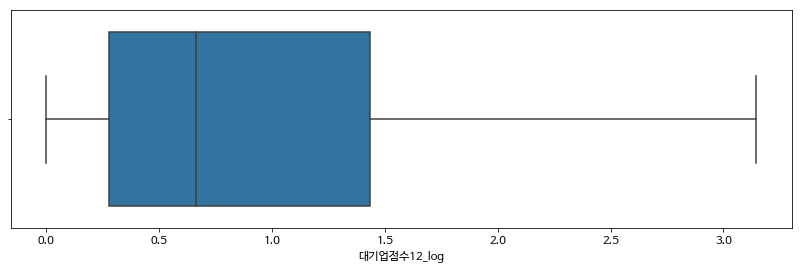

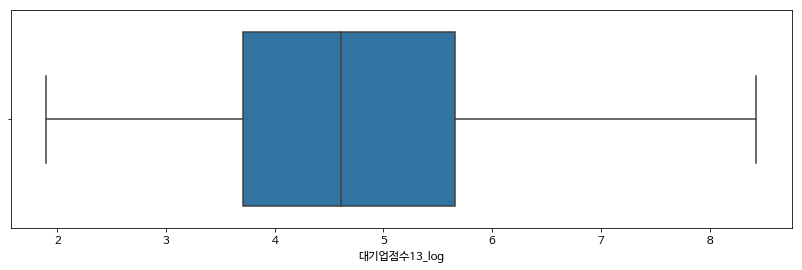

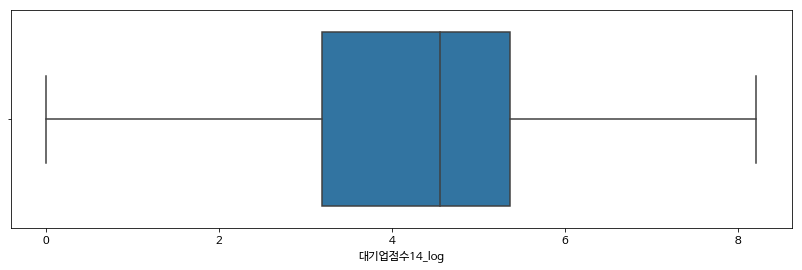

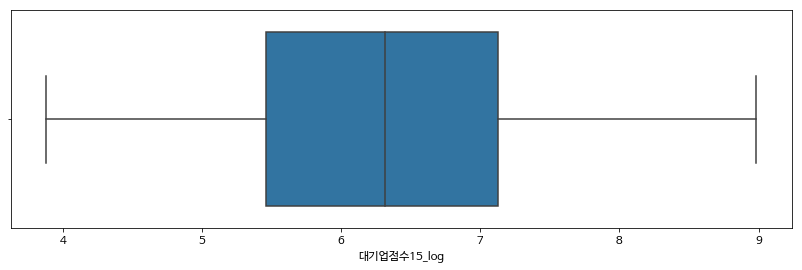

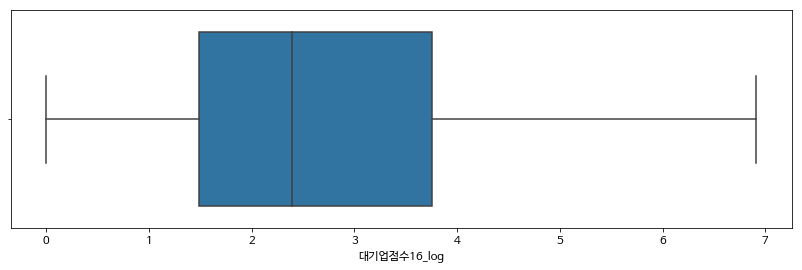

In [735]:
for col_ in temp_df.columns[1:]:
    plt.figure(figsize=(14,4))
    sns.boxplot(x=temp_df[col_])

In [858]:
corr_with_score = temp_df.corr()['score_A2'].sort_values(ascending=False)

In [859]:
select_feautres_names = corr_with_score[corr_with_score.map(lambda x:abs(x)>=0.1)].index

In [860]:
select_feature_df = temp_df[select_feautres_names]

In [862]:
select_corr = select_feature_df[['score_A2']+list(select_feature_df.columns[4:])].corr()

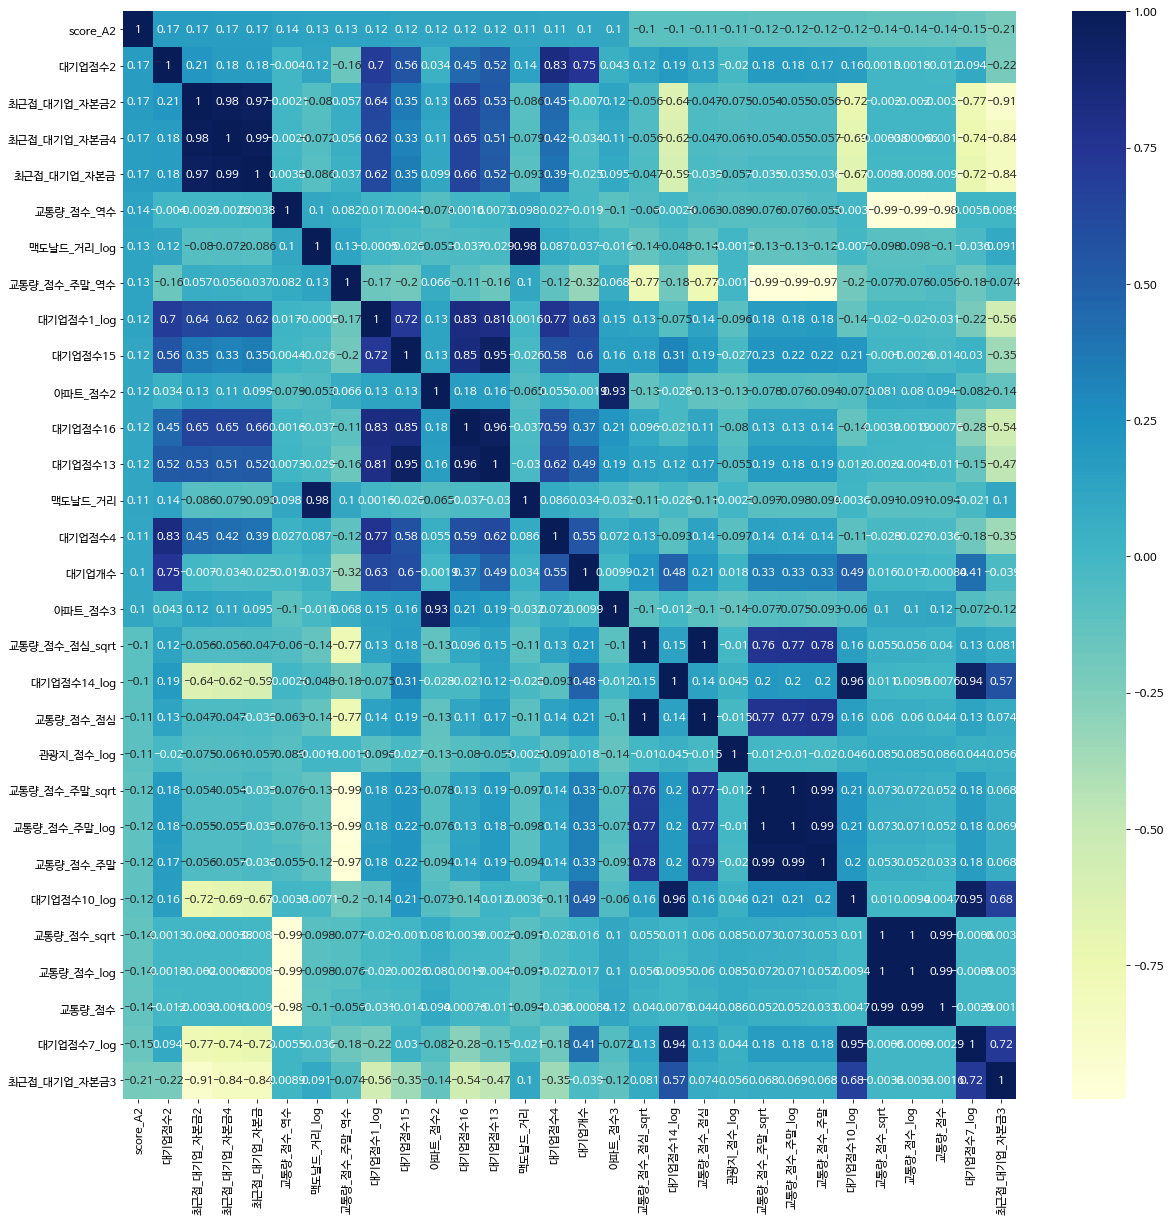

In [869]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(select_corr, annot=True, cmap="YlGnBu")
fig.savefig('../starbucksDT/postprocess/200717_starbucksDt_all_feature_select_corr.png')

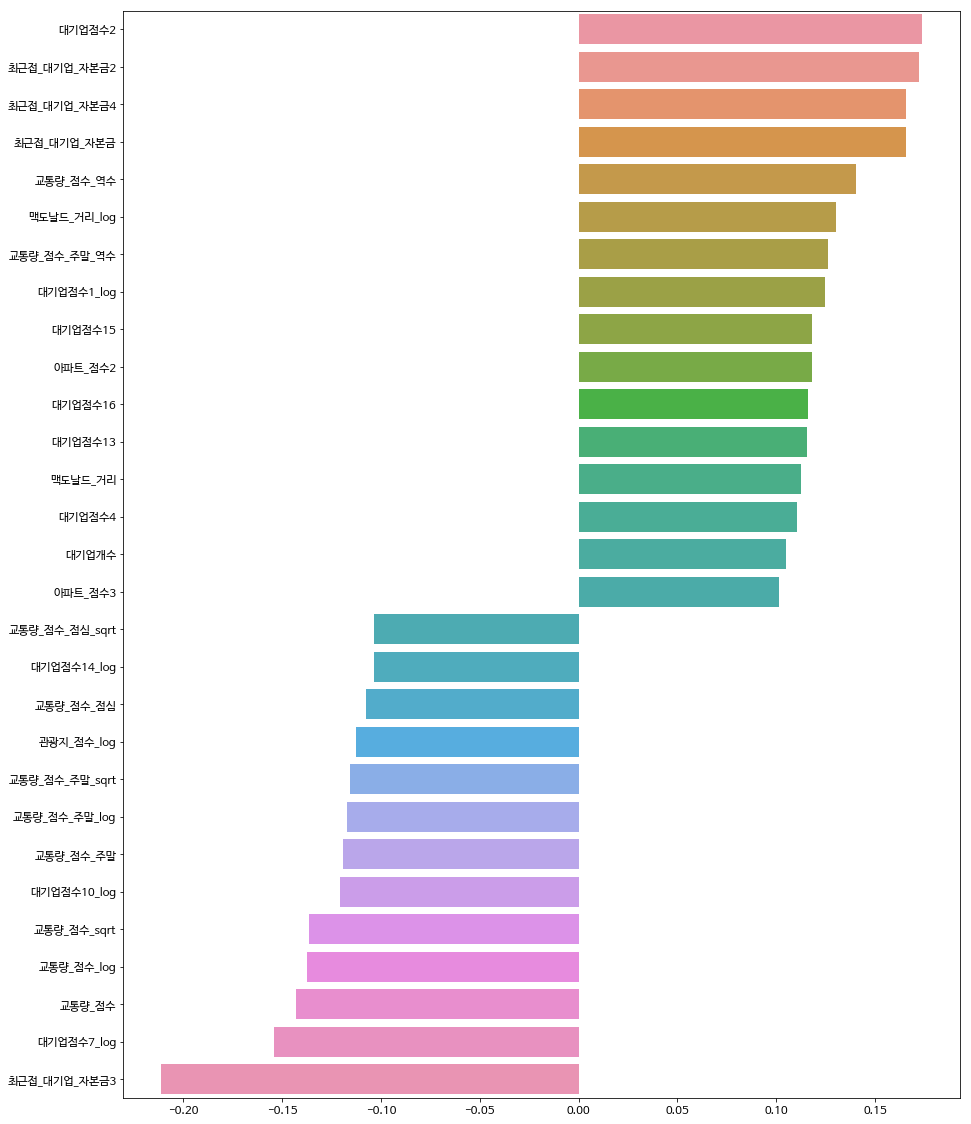

In [921]:
fig = plt.figure(figsize=(15,20))
sns.barplot(y=select_corr.index[1:],x= select_corr.score_A2.values[1:])
fig.savefig('../starbucksDT/postprocess/200717_starbucksDt_select_feature_importance_sort.png')

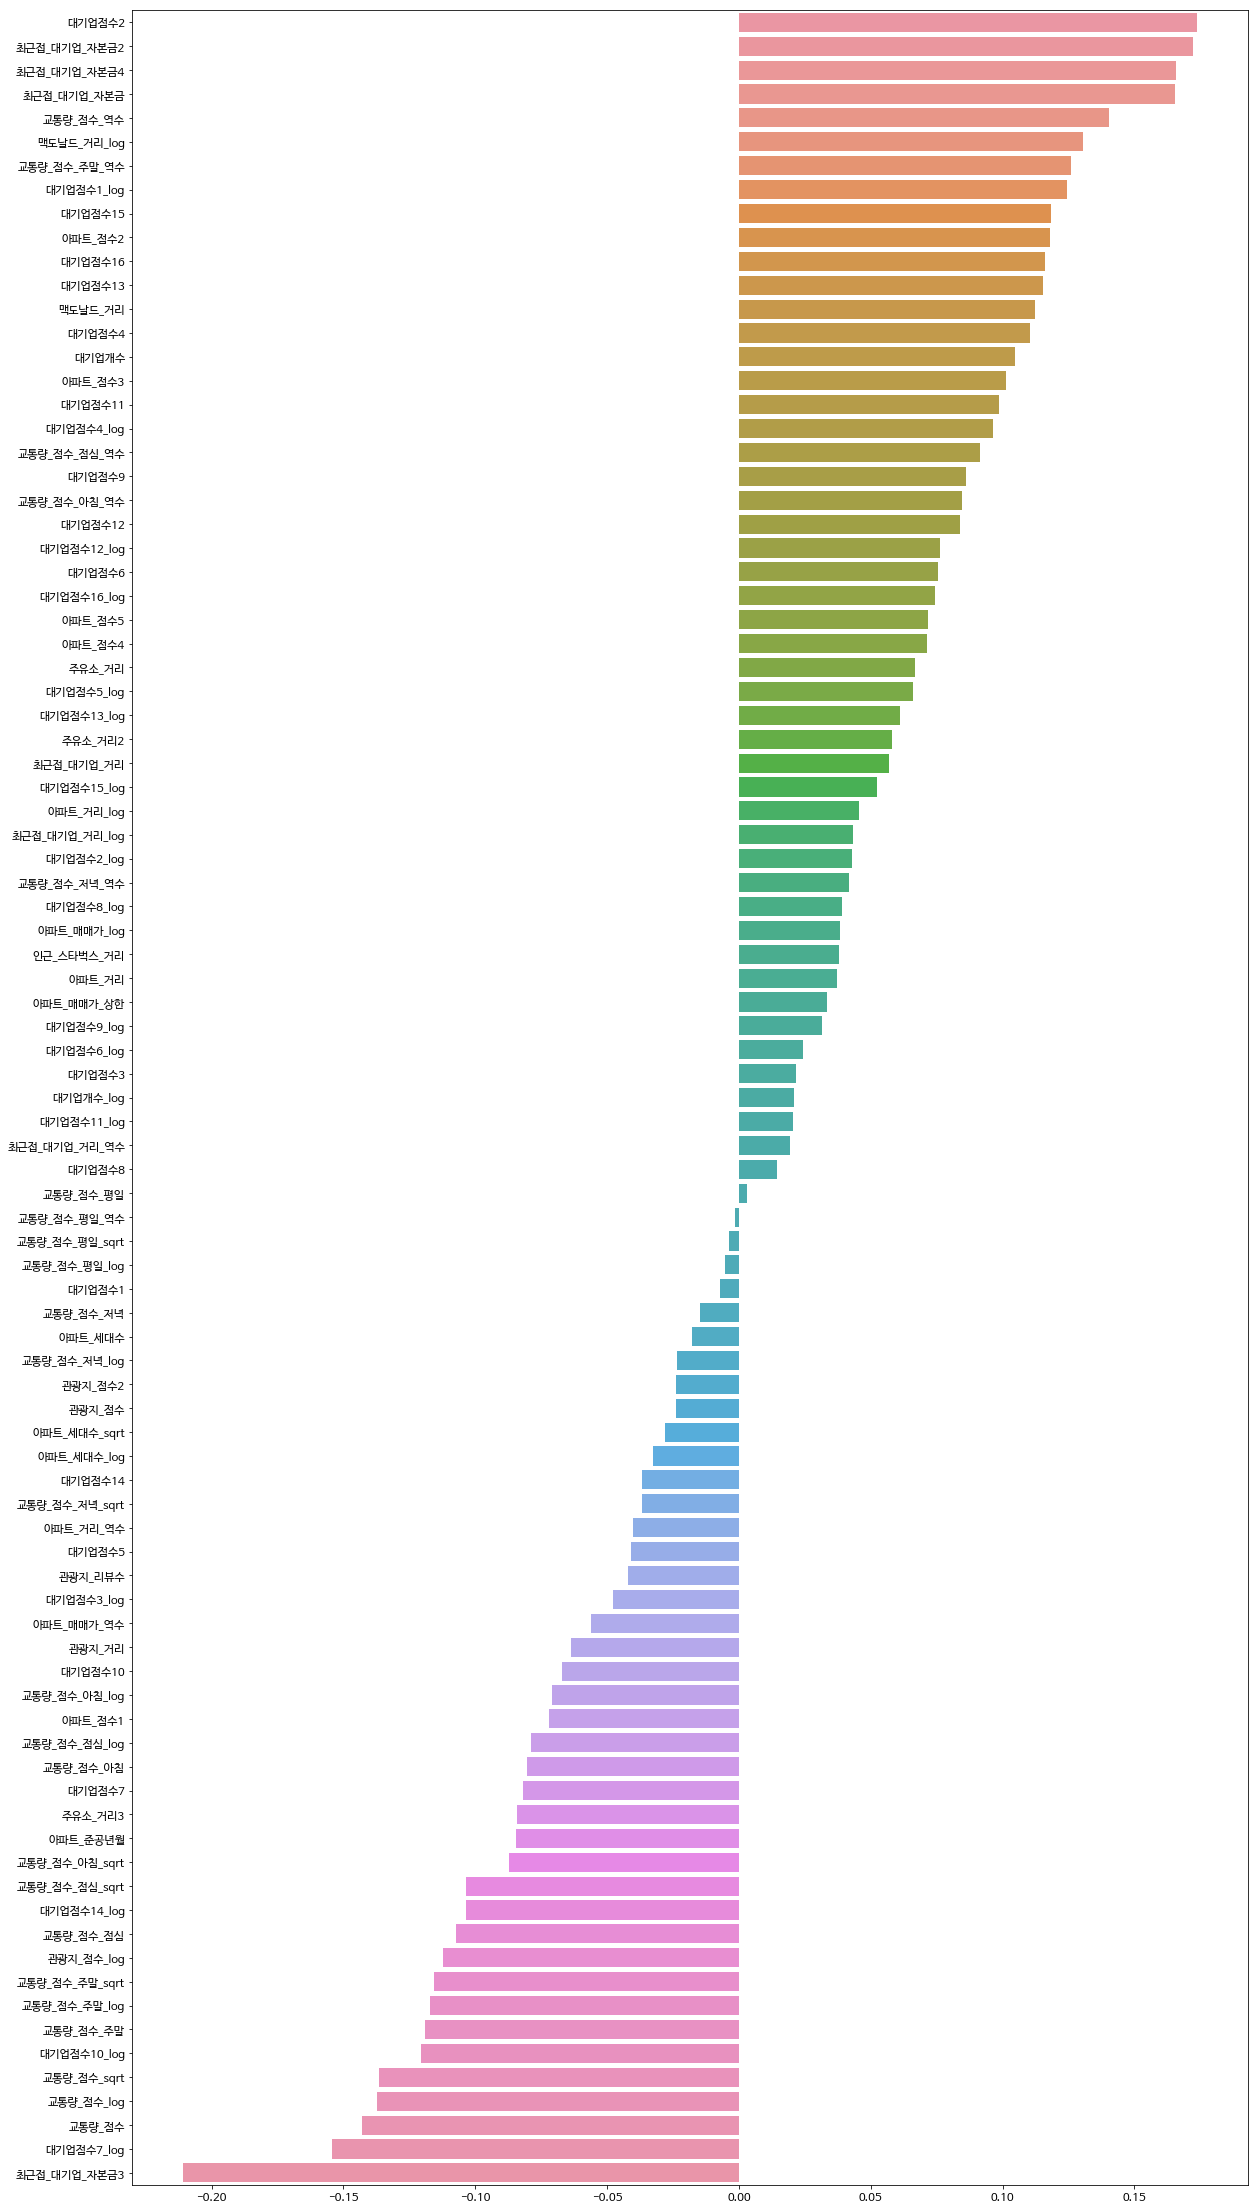

In [868]:
plt.figure(figsize=(20,40))
sns.barplot(y=corr_with_score.index[4:],x= corr_with_score.values[4:])
fig.savefig('../starbucksDT/postprocess/200717_starbucksDt_all_feature_corr.png')

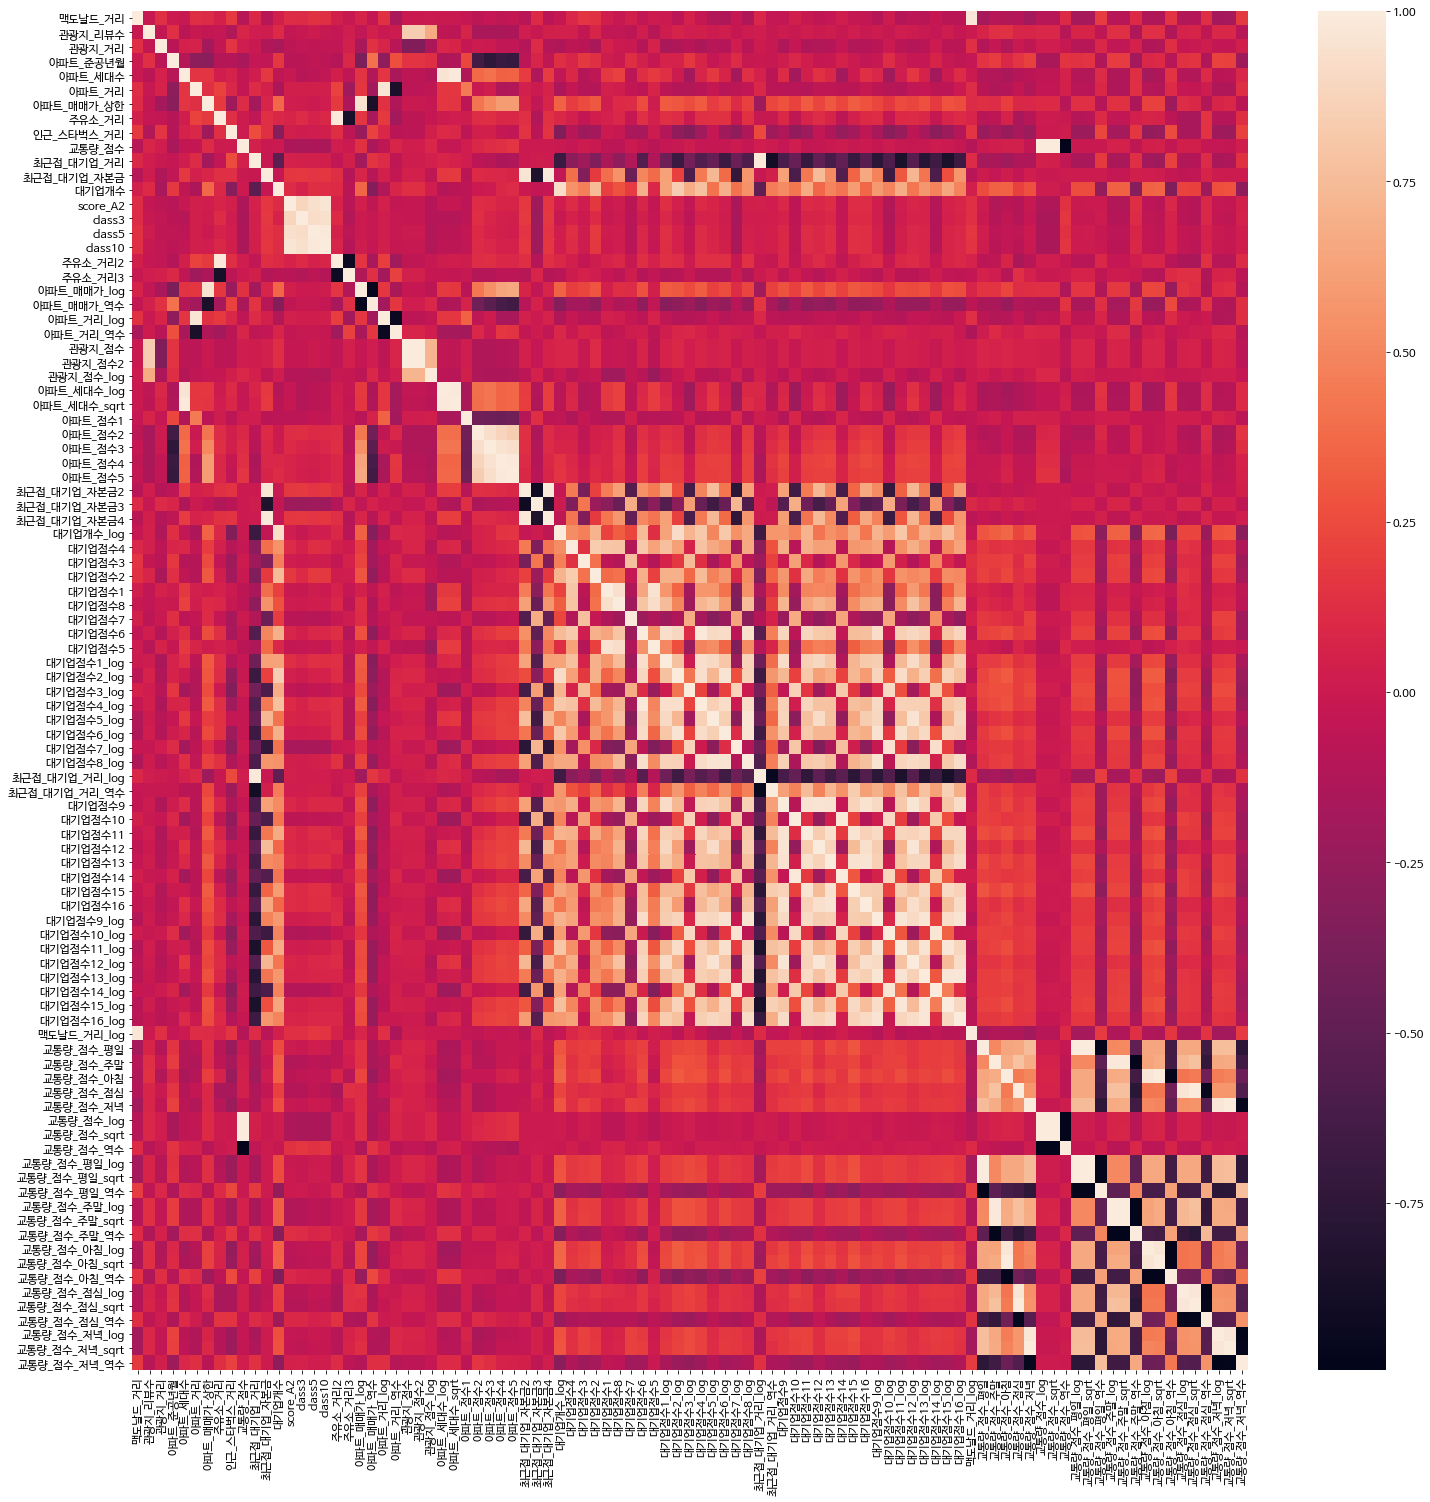

In [867]:
fig = plt.figure(figsize=(25,25))
sns.heatmap(temp_df.corr())
fig.savefig('../starbucksDT/postprocess/200717_starbucksDt_all_feature_corr.png')

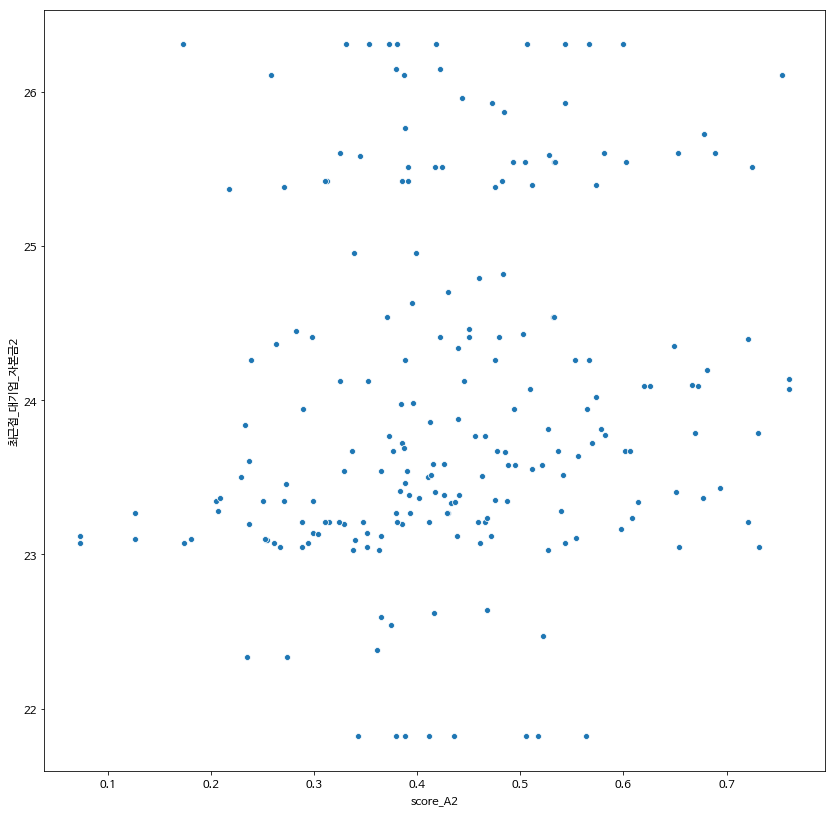

In [885]:
plt.figure(figsize=(14,14))
sns.scatterplot(y=temp_df['최근접_대기업_자본금2'], x=temp_df['score_A2'])

In [895]:
df_select_features = df.corr()['score_A2'][df.corr()['score_A2'].map(lambda x:abs(x)>=0.1)]

In [899]:
df_select_ = pd.DataFrame(df_select_features).sort_values('score_A2', ascending=False).iloc[4:,:]

In [907]:
df_select_feature = df[['score_A2']+list(df_select_.index)]

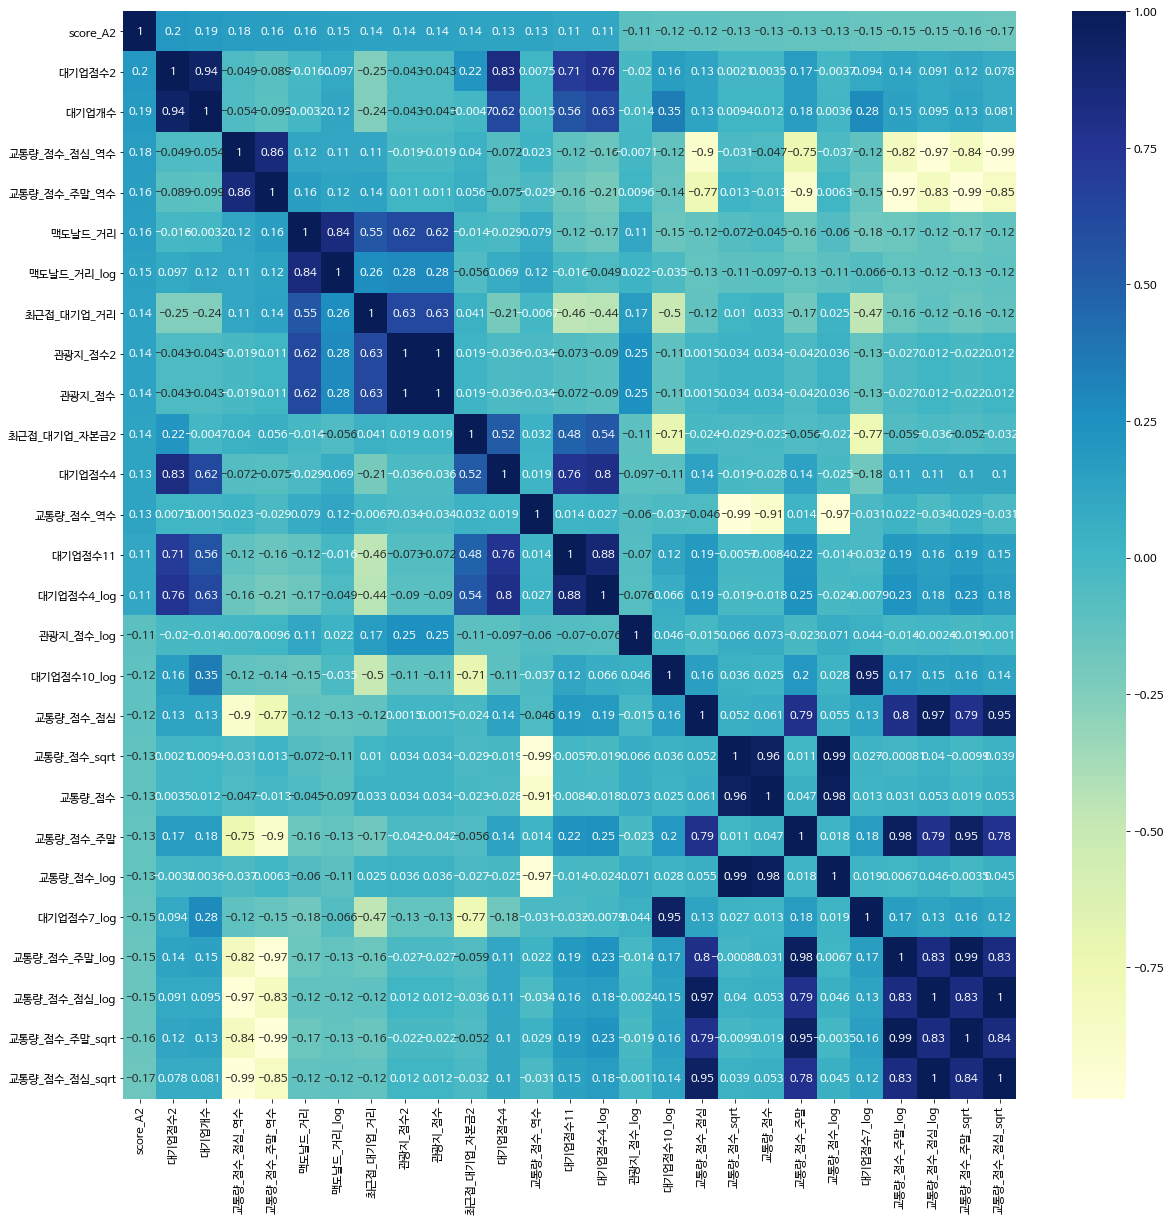

In [912]:
plt.figure(figsize=(20,20))
sns.heatmap(df_select_feature.corr(), cmap='YlGnBu', annot=True)

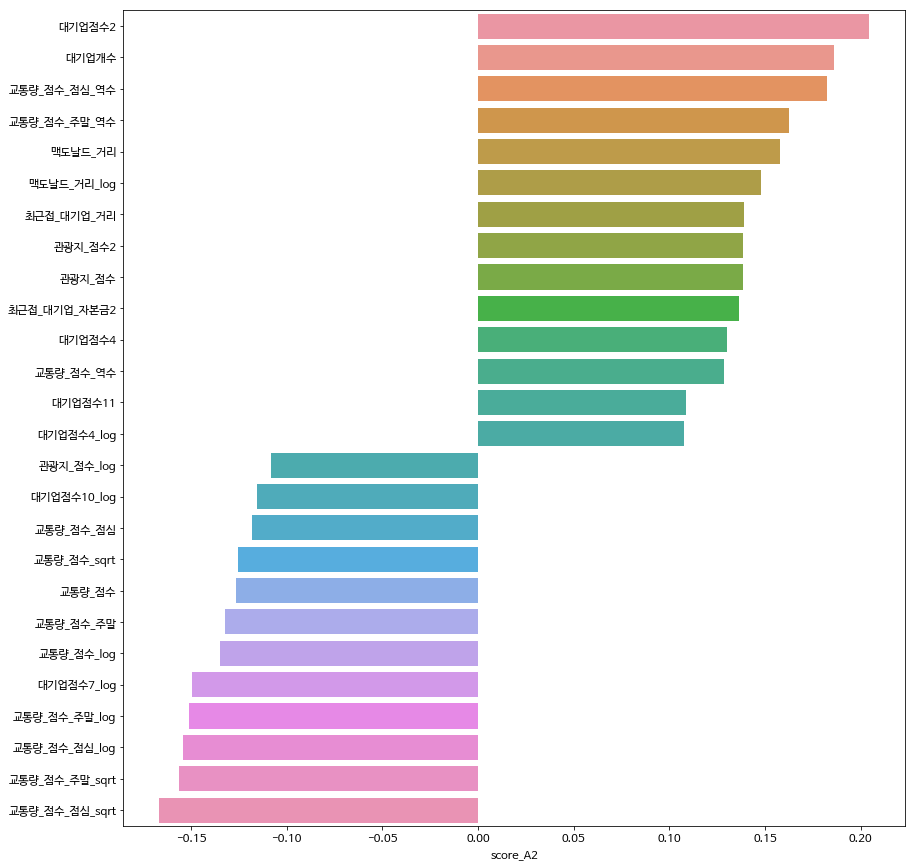

In [903]:
plt.figure(figsize=(14,15))
sns.barplot(y=df_select_.index, x= df_select_['score_A2'])

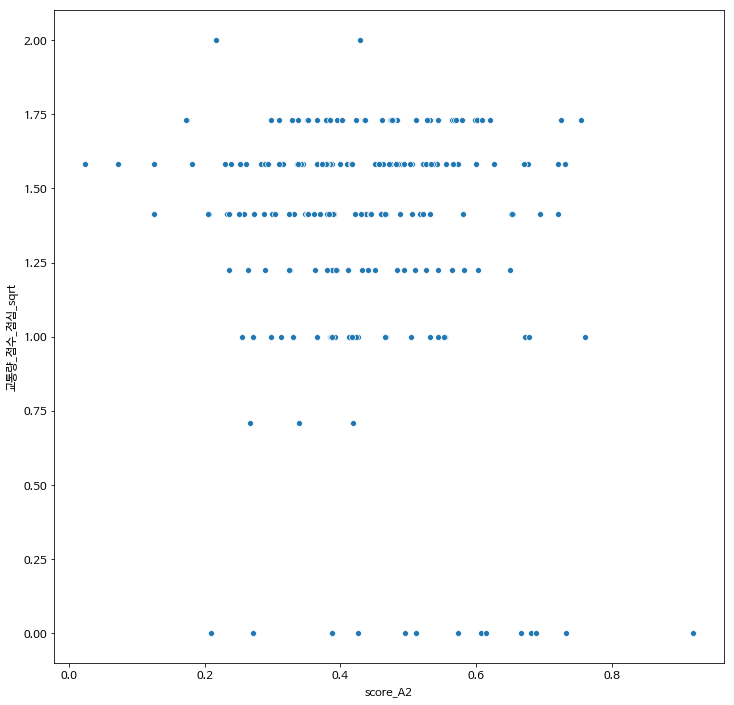

In [925]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=df['score_A2'],y=df['교통량_점수_점심_sqrt'])

In [928]:
import statsmodels.api as sm

In [929]:
sm.OLS.from_formula()

statsmodels.regression.linear_model.OLS

In [937]:
df.drop('지점명',axis=1).values.shape

(213, 95)

In [978]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    select_feature_df.drop('지점명',axis=1).values, i) for i in range(select_feature_df.drop('지점명',axis=1).shape[1])]
vif["features"] = select_feature_df.drop('지점명',axis=1).columns
vif

VIF Factor        features
0      203.840222        score_A2
1      375.382750         class10
2      208.082631          class5
3       71.172034          class3
4       11.816350          대기업점수2
5    11346.065846    최근접_대기업_자본금2
6      295.606595    최근접_대기업_자본금4
7      127.814214     최근접_대기업_자본금
8     3148.202529       교통량_점수_역수
9       85.566899     맥도날드_거리_log
10    7209.672038    교통량_점수_주말_역수
11      33.270156      대기업점수1_log
12      85.159897         대기업점수15
13      17.621931         아파트_점수2
14      72.302885         대기업점수16
15     163.398822         대기업점수13
16      58.974598         맥도날드_거리
17      10.167670          대기업점수4
18      18.962089           대기업개수
19      33.066107         아파트_점수3
20    3244.474812  교통량_점수_점심_sqrt
21     381.310740     대기업점수14_log
22     984.312474       교통량_점수_점심
23       3.805170      관광지_점수_log
24  392329.641178  교통량_점수_주말_sqrt
25  336682.154092   교통량_점수_주말_log
26     345.486941       교통량_점수_주말
27     110.708326     대기업점수10_log
28  128879.083315     교통량_점수_sqrt
29  104429.669997      교통량_점수_log
30     917.274161          교통량_점수
31     292.209209      대기업점수7_log
32      29.145586    최근접_대기업_자본금3

In [987]:
except_cols = vif[vif['VIF Factor']>1e4].features.values

In [982]:
np.percentile(vif['VIF Factor'], 85)

8036.9507993986335

In [949]:
select_feature_df.shape

(213, 33)

In [955]:
select_feature_df['지점명'] = temp_df['지점명']

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [957]:
select_feature_df = select_feature_df[['지점명'] + list(select_feature_df.columns[:-1])]

In [958]:
select_feature_df

지점명  score_A2  class10  class5  class3    대기업점수2  \
0       스타벅스 강동구청DT점  0.680499       10       5       3  0.094838   
1       스타벅스 강동암사DT점  0.482700        7       4       2  0.074608   
2     스타벅스 경기광주신현DT점  0.432452        6       3       2  0.022035   
3       스타벅스 경남사천DT점  0.380050        4       2       2  0.011950   
4       스타벅스 경산중방DT점  0.505294        8       4       3  0.000009   
5    스타벅스 경인교대입구역DT점  0.563726        9       5       3  0.008881   
6      스타벅스 경주보문로DT점  0.387270        4       2       2  0.000000   
7     스타벅스 경주보문호수DT점  0.257775        2       1       1  0.003443   
8      스타벅스 경주터미널DT점  0.753784       10       5       3  0.000000   
9       스타벅스 계룡대로DT점  0.425602        6       3       2  0.000000   
10        스타벅스 고양DT점  0.543313        9       5       3  0.000000   
11        스타벅스 공릉DT점  0.648995       10       5       3  0.015814   
12     스타벅스 공주동학사DT점  0.365057        3       2       1  0.001429   
13        스타벅스 과천DT점  0.282663        2       1       1  0.060389   
14      스타벅스 광명소하DT점  0.459136        6       3       2  0.046150   
15      스타벅스 광주금호DT점  0.270846        2       1       1  0.023615   
16      스타벅스 광주매곡DT점  0.328600        3       2       1  0.014825   
17      스타벅스 광주방림DT점  0.472925        7       4       2  0.036506   
18      스타벅스 광주산정DT점  0.252933        1       1       1  0.029609   
19      스타벅스 광주상무DT점  0.475176        7       4       2  0.026567   
20      스타벅스 광주수완DT점  0.206441        1       1       1  0.021504   
21      스타벅스 광주신가DT점  0.471396        7       4       2  0.028602   
22     스타벅스 광주신세계DT점  0.422507        6       3       2  0.032193   
23      스타벅스 광주신안DT점  0.554310        9       5       3  0.017047   
24      스타벅스 광주용두DT점  0.517577        8       4       3  0.003330   
25      스타벅스 광주운남DT점  0.339606        3       2       1  0.032429   
26      스타벅스 광주운암DT점  0.450600        6       3       2  0.027594   
27      스타벅스 광주월산DT점  0.430133        6       3       2  0.032411   
28      스타벅스 광주화정DT점  0.298150        2       1       1  0.029893   
29      스타벅스 광주흑석DT점  0.254651        1       1       1  0.029609   
..               ...       ...      ...     ...     ...       ...   
183       스타벅스 종암DT점  0.476909        7       4       2  0.104296   
184     스타벅스 진주칠암DT점  0.217498        1       1       1  0.011773   
185     스타벅스 진해자은DT점  0.505996        8       4       3  0.007150   
186      스타벅스 창원역DT점  0.731503       10       5       3  0.011051   
187     스타벅스 창원호계DT점  0.288388        2       1       1  0.002763   
188    스타벅스 천안IC DT점  0.338208        3       2       1  0.021318   
189     스타벅스 천안불당DT점  0.418031        5       3       2  0.041451   
190   스타벅스 천안서부대로DT점  0.173160        1       1       1  0.056995   
191     스타벅스 천안성정DT점  0.399288        5       3       2  0.026647   
192     스타벅스 청주봉명DT점  0.552823        9       5       3  0.010975   
193     스타벅스 청주사직DT점  0.566402        9       5       3  0.010975   
194     스타벅스 청주용담DT점  0.388000        4       2       2  0.002195   
195     스타벅스 청주용암DT점  0.475251        7       4       2  0.000000   
196     스타벅스 청주율량DT점  0.573209        9       5       3  0.006106   
197     스타벅스 춘천석사DT점  0.614059        9       5       3  0.003157   
198     스타벅스 춘천후평DT점  0.436877        6       3       2  0.003157   
199     스타벅스 충남보령DT점  0.379858        4       2       2  0.003466   
200     스타벅스 충주시청DT점  0.236496        1       1       1  0.012283   
201     스타벅스 충주호암DT점  0.666508       10       5       3  0.010444   
202       스타벅스 평내DT점  0.394959        5       3       2  0.002447   
203      스타벅스 평촌역DT점  0.527511        8       4       3  0.074170   
204     스타벅스 평택서정DT점  0.304226        2       1       1  0.005745   
205       스타벅스 포천DT점  0.337803        3       2       1  0.002732   
206     스타벅스 포항쌍용DT점  0.466174        7       4       2  0.031716   
207     스타벅스 포항장성DT점  0.372792        4       2       1  0.001866   
208      스타벅스 풍무역DT점  0.416858        5       3       2  0.015193   
209     스타벅스 하남

In [968]:
temp_df = temp_df.sort_values('지점명', ascending=False).reset_index(drop=True)

In [969]:
select_feature_df = select_feature_df.sort_values('지점명', ascending=False).reset_index(drop=True)

In [970]:
select_feature_df

지점명  score_A2  class10  class5  class3    대기업점수2  \
0       스타벅스 화성병점DT점  0.429184        6       3       2  0.019877   
1         스타벅스 화곡DT점  0.730365       10       5       3  0.112749   
2     스타벅스 해운대달맞이DT점  0.310229        2       1       1  0.005958   
3       스타벅스 하남미사DT점  0.401841        5       3       2  0.009555   
4        스타벅스 풍무역DT점  0.416858        5       3       2  0.015193   
5       스타벅스 포항장성DT점  0.372792        4       2       1  0.001866   
6       스타벅스 포항쌍용DT점  0.466174        7       4       2  0.031716   
7         스타벅스 포천DT점  0.337803        3       2       1  0.002732   
8       스타벅스 평택서정DT점  0.304226        2       1       1  0.005745   
9        스타벅스 평촌역DT점  0.527511        8       4       3  0.074170   
10        스타벅스 평내DT점  0.394959        5       3       2  0.002447   
11      스타벅스 충주호암DT점  0.666508       10       5       3  0.010444   
12      스타벅스 충주시청DT점  0.236496        1       1       1  0.012283   
13      스타벅스 충남보령DT점  0.379858        4       2       2  0.003466   
14      스타벅스 춘천후평DT점  0.436877        6       3       2  0.003157   
15      스타벅스 춘천석사DT점  0.614059        9       5       3  0.003157   
16      스타벅스 청주율량DT점  0.573209        9       5       3  0.006106   
17      스타벅스 청주용암DT점  0.475251        7       4       2  0.000000   
18      스타벅스 청주용담DT점  0.388000        4       2       2  0.002195   
19      스타벅스 청주사직DT점  0.566402        9       5       3  0.010975   
20      스타벅스 청주봉명DT점  0.552823        9       5       3  0.010975   
21      스타벅스 천안성정DT점  0.399288        5       3       2  0.026647   
22    스타벅스 천안서부대로DT점  0.173160        1       1       1  0.056995   
23      스타벅스 천안불당DT점  0.418031        5       3       2  0.041451   
24     스타벅스 천안IC DT점  0.338208        3       2       1  0.021318   
25      스타벅스 창원호계DT점  0.288388        2       1       1  0.002763   
26       스타벅스 창원역DT점  0.731503       10       5       3  0.011051   
27      스타벅스 진해자은DT점  0.505996        8       4       3  0.007150   
28      스타벅스 진주칠암DT점  0.217498        1       1       1  0.011773   
29        스타벅스 종암DT점  0.476909        7       4       2  0.104296   
..               ...       ...      ...     ...     ...       ...   
183     스타벅스 광주흑석DT점  0.254651        1       1       1  0.029609   
184     스타벅스 광주화정DT점  0.298150        2       1       1  0.029893   
185     스타벅스 광주월산DT점  0.430133        6       3       2  0.032411   
186     스타벅스 광주운암DT점  0.450600        6       3       2  0.027594   
187     스타벅스 광주운남DT점  0.339606        3       2       1  0.032429   
188     스타벅스 광주용두DT점  0.517577        8       4       3  0.003330   
189     스타벅스 광주신안DT점  0.554310        9       5       3  0.017047   
190    스타벅스 광주신세계DT점  0.422507        6       3       2  0.032193   
191     스타벅스 광주신가DT점  0.471396        7       4       2  0.028602   
192     스타벅스 광주수완DT점  0.206441        1       1       1  0.021504   
193     스타벅스 광주상무DT점  0.475176        7       4       2  0.026567   
194     스타벅스 광주산정DT점  0.252933        1       1       1  0.029609   
195     스타벅스 광주방림DT점  0.472925        7       4       2  0.036506   
196     스타벅스 광주매곡DT점  0.328600        3       2       1  0.014825   
197     스타벅스 광주금호DT점  0.270846        2       1       1  0.023615   
198     스타벅스 광명소하DT점  0.459136        6       3       2  0.046150   
199       스타벅스 과천DT점  0.282663        2       1       1  0.060389   
200    스타벅스 공주동학사DT점  0.365057        3       2       1  0.001429   
201       스타벅스 공릉DT점  0.648995       10       5       3  0.015814   
202       스타벅스 고양DT점  0.543313        9       5       3  0.000000   
203     스타벅스 계룡대로DT점  0.425602        6       3       2  0.000000   
204    스타벅스 경주터미널DT점  0.753784       10       5       3  0.000000   
205   스타벅스 경주보문호수DT점  0.257775        2       1       1  0.003443   
206    스타벅스 경주보문로DT점  0.387270        4       2       2  0.000000   
207  스타벅스 경인교대입구역DT점  0.563726        9       5       3  0.008881   
208     스타벅스 경산중방DT점  0.505294        8       4       3  0.000009   
209     스타벅스 경남

In [974]:
temp_df = temp_df[['지점명', 'score_A2']+list(set(temp_df.columns).difference({'지점명',' score_A2'}))]

In [975]:
temp_df

지점명  score_A2  관광지_리뷰수   주유소_거리2  대기업점수3_log   대기업점수10  \
0       스타벅스 화성병점DT점  0.429184    24681  0.640274    2.070644  0.044150   
1         스타벅스 화곡DT점  0.730365        0  0.875469    2.993728  0.024601   
2     스타벅스 해운대달맞이DT점  0.310229    42656  0.411447    0.113033  0.001073   
3       스타벅스 하남미사DT점  0.401841     4800  1.629241    1.363328  0.034567   
4        스타벅스 풍무역DT점  0.416858    18720  1.029619    0.241182  0.001442   
5       스타벅스 포항장성DT점  0.372792        0  0.557327    0.279489  0.001430   
6       스타벅스 포항쌍용DT점  0.466174        0  0.615186    1.868986  0.009075   
7         스타벅스 포천DT점  0.337803     7652  0.415415    0.858453  0.015985   
8       스타벅스 평택서정DT점  0.304226    18767  0.788457    1.237976  0.009582   
9        스타벅스 평촌역DT점  0.527511        0  0.656483    0.792185  0.004867   
10        스타벅스 평내DT점  0.394959        0  0.238229    0.126393  0.001229   
11      스타벅스 충주호암DT점  0.666508        0  1.193922    0.767455  0.002498   
12      스타벅스 충주시청DT점  0.236496     3138  1.629241    1.298566  0.010885   
13      스타벅스 충남보령DT점  0.379858     7247  0.671413    0.027416  0.000112   
14      스타벅스 춘천후평DT점  0.436877      518  0.053541    0.688391  0.006600   
15      스타벅스 춘천석사DT점  0.614059      439  0.955511    0.688391  0.005013   
16      스타벅스 청주율량DT점  0.573209     9532  1.335001    0.559883  0.008486   
17      스타벅스 청주용암DT점  0.475251     1214  0.402126    0.000000  0.000000   
18      스타벅스 청주용담DT점  0.388000     2066  0.464363    0.179668  0.000932   
19      스타벅스 청주사직DT점  0.566402    28189  0.955511    0.685165  0.002703   
20      스타벅스 청주봉명DT점  0.552823    28189  0.741937    0.685165  0.004759   
21      스타벅스 천안성정DT점  0.399288      356  0.955511    0.677022  0.006636   
22    스타벅스 천안서부대로DT점  0.173160        0  0.670902    0.000000  0.000000   
23      스타벅스 천안불당DT점  0.418031        0  0.916291    0.000000  0.000000   
24     스타벅스 천안IC DT점  0.338208      356  0.491643    0.573466  0.007017   
25      스타벅스 창원호계DT점  0.288388     1399  0.832909    0.845281  0.009694   
26       스타벅스 창원역DT점  0.731503     1725  0.875469    1.842853  0.044150   
27      스타벅스 진해자은DT점  0.505996        0  0.185649    0.045573  0.000175   
28      스타벅스 진주칠암DT점  0.217498        0  0.832909    0.225413  0.001840   
29        스타벅스 종암DT점  0.476909    22472  0.875469    3.076662  0.028078   
..               ...       ...      ...       ...         ...       ...   
183     스타벅스 광주흑석DT점  0.254651    16808  0.832909    2.665061  0.032154   
184     스타벅스 광주화정DT점  0.298150     1718  1.098612    1.158960  0.009014   
185     스타벅스 광주월산DT점  0.430133     1718  0.875469    0.967955  0.004260   
186     스타벅스 광주운암DT점  0.450600        0  1.064711    1.104732  0.005635   
187     스타벅스 광주운남DT점  0.339606    16808  1.064711    2.749962  0.023894   
188     스타벅스 광주용두DT점  0.517577    17256  0.681075    2.682949  0.044150   
189     스타벅스 광주신안DT점  0.554310        0  1.223775    2.142260  0.028545   
190    스타벅스 광주신세계DT점  0.422507     1718  1.163151    1.210397  0.011777   
191     스타벅스 광주신가DT점  0.471396    16808  0.250759    2.591881  0.019247   
192     스타벅스 광주수완DT점  0.206441    16808  1.098612    2.126531  0.024830   
193     스타벅스 광주상무DT점  0.475176        0  0.650240    0.445601  0.003113   
194     스타벅스 광주산정DT점  0.252933    16808  0.202124    2.665061  0.037975   
195     스타벅스 광주방림DT점  0.472925       16  0.788457    0.327208  0.002293   
196     스타벅스 광주매곡DT점  0.328600        0  0.456792    1.904100  0.014934   
197     스타벅스 광주금호DT점  0.270846    17609  0.788457    0.404830  0.003948   
198     스타벅스 광명소하DT점  0.459136        0  1.629241    2.920367  0.022952   
199       스타벅스 과천DT점  0.282663      294  1.131402    1.653102  0.009185   
200    스타벅스 공주동학사DT점  0.365057     1103  0.345715    0.481835  0.002315   
201       스타벅스 공릉DT점  0.648995        0  0.741937    0.811446  0.004584   
202       스타벅스 고양DT점  0.543313      119  0.741937    0.000000  0.000000   
203     스타벅스 계룡대로DT점  0.425602    25998  0.502592    0.000000  0.000000   
204    스타벅스 경주터미널DT점  0.753784        0  0

In [976]:
select_feature_df.to_excel('../starbucksDT/postprocess/select_feature_df_200720.xlsx', index=False)
temp_df.to_excel('../starbucksDT/postprocess/all_feature_200720.xlsx', index=False)

In [989]:
select_feature_df[list(set(select_feature_df.columns).difference(set(except_cols)))].to_excel('../starbucksDT/postprocess/select_feature_df_vif_delete_200720.xlsx', index=False)

In [1004]:
df7 = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/total/20200720_starbucksDT_beformNorm2.xlsx')

In [1008]:
select_feature_df = select_feature_df.sort_values('지점명').reset_index(drop=True)
temp_df = temp_df.sort_values('지점명').reset_index(drop=True)
df7 = df7.sort_values('지점명').reset_index(drop=True)

In [1020]:
select_feature_df = pd.read_excel('../starbucksDT/postprocess/select_feature_df_200720.xlsx')

In [1022]:
select_feature_df.columns

Index(['지점명', 'score_A2', 'class10', 'class5', 'class3', '대기업점수2',
       '최근접_대기업_자본금2', '최근접_대기업_자본금4', '최근접_대기업_자본금', '교통량_점수_역수',
       '맥도날드_거리_log', '교통량_점수_주말_역수', '대기업점수1_log', '대기업점수15', '아파트_점수2',
       '대기업점수16', '대기업점수13', '맥도날드_거리', '대기업점수4', '대기업개수', '아파트_점수3',
       '교통량_점수_점심_sqrt', '대기업점수14_log', '교통량_점수_점심', '관광지_점수_log',
       '교통량_점수_주말_sqrt', '교통량_점수_주말_log', '교통량_점수_주말', '대기업점수10_log',
       '교통량_점수_sqrt', '교통량_점수_log', '교통량_점수', '대기업점수7_log', '최근접_대기업_자본금3'],
      dtype='object')

In [1014]:
col_map = {}
for col in df7.columns:
    col_map[col] = '_'.join(col.split(' '))

In [1016]:
df7 = df7.rename(columns=col_map)

In [1023]:
for col in ['대기업점수2', '최근접_대기업_자본금2', '최근접_대기업_자본금3', '최근접_대기업_자본금4', '대기업점수7_log',
       '대기업점수1_log', '대기업점수15', '대기업점수16', '대기업점수13', '대기업점수4', '대기업점수14_log', '대기업점수10_log', 
       '관광지_점수_log', '맥도날드_거리_log', 
       '아파트_점수2', '아파트_점수3',
       '교통량_점수_점심_sqrt', '교통량_점수_주말_역수', 
       '교통량_점수_역수', '교통량_점수_주말_sqrt', '교통량_점수_주말_log',
       '교통량_점수_sqrt', '교통량_점수_log']:
    df7[col] = select_feature_df[col]

In [1025]:
df7.to_excel('/Users/dhkim/PycharmProjects/starbucksDT/total/20200720_starbucksDT_beformNorm_transfromAdd.xlsx', index=False)